# Imports

In [41]:
import numpy as np
import pandas as pd

# Text Preprocessing libraries
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Vectorization of texts
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec
from gensim.models.callbacks import CallbackAny2Vec

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, Embedding, Activation, TextVectorization, Concatenate, SimpleRNN, Conv1D, GlobalMaxPooling1D
from attention import Attention
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TerminateOnNaN
# import keras_tuner
from tensorflow.random import set_seed

# Metrics
from sklearn.metrics import classification_report

# Traning helper functions
from sklearn.model_selection import train_test_split

# Utility Functions
import pickle
import shutil
from tqdm.auto import tqdm # Showing progress bar
tqdm.pandas()

import os

In [46]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'data')
# import data
imdb_df = pd.read_csv(os.path.join(data_path, 'IMDB Dataset.csv'))

# EDA

In [47]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


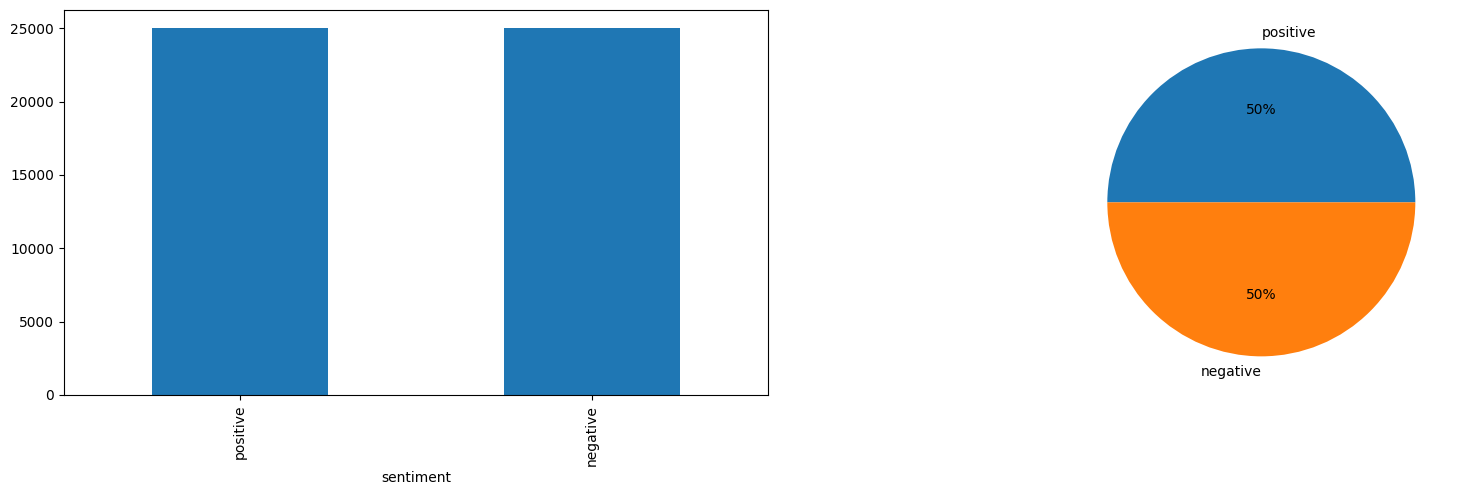

In [62]:
label_info = imdb_df['sentiment'].value_counts()
print(label_info)
plt.figure(figsize=((20,5)))

plt.subplot(1,2,1)
label_info.plot.bar()

plt.subplot(1,2,2)
plt.pie(label_info,labels = label_info.index,autopct='%.0f%%')

plt.show()

# Text-Preproccessing

## Text Cleaning Utility Function

In [49]:
def clean_text(text):
  # Apostrophe
  text = re.sub(r'\x89Ûª', "'", text)
  text = re.sub(r'\x89Û÷', "'", text)

  # Quotation
  text = re.sub(r'\x89ÛÏ', '"', text)
  text = re.sub(r'\x89Û\x9d', '"', text)

  # Hyphen
  text = re.sub(r'\x89ÛÒ', '-', text)
  text = re.sub(r'\x89ÛÓ', '—', text)

  # Euro
  text = re.sub(r'\x89âÂ', '€', text)

  # Ellipsis
  text = re.sub(r'\x89Û_', '...', text)

  # Ampersand
  text = re.sub(r'&', 'and', text)

  # Bullet
  text = re.sub(r"\x89Û¢åÊ", "", text)
  text = re.sub(r'\x89Û¢', '', text)

  # Wrong encodings
  text = re.sub(r"fromåÊwounds", "from wounds", text)
  text = re.sub(r"åÊ", "", text)
  text = re.sub(r"åÈ", "", text)
  text = re.sub(r"JapÌ_n", "Japan", text)
  text = re.sub(r"Ì©", "e", text)
  text = re.sub(r"å¨", "", text)
  text = re.sub(r"SuruÌ¤", "Suruc", text)
  text = re.sub(r"åÇ", "", text)
  text = re.sub(r"å£3million", "3 million ", text)
  text = re.sub(r"åÀ", "", text)

  return text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'This is a website.',text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Creating Corpus

### Stop Word Removal
Removing common words that don't provide much semantic meanings

In [50]:
imdb_cleaned = imdb_df.copy()
stop_words = stopwords.words('english')
imdb_cleaned['sentiment'] = imdb_cleaned['sentiment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

- The texts will be lowercased
- Short forms will be converted to the right word
- Punctuations will be removed
- The words are stemmed

reference : https://www.kaggle.com/code/quentinsarrazin/tweets-preprocessing/notebook

In [51]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "la" : "los angeles",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [52]:
def to_lower(text):
    return text.lower()

def remove_punc(text):
    return re.sub(r"[^\w\s]","", text)

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

stemmer = SnowballStemmer("english")
def stem(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [53]:
def preprocess_text(input_data):
    r = clean_text(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    r = to_lower(r)
    r = replace_abbrev(r)
    r = stem(r)
    return r

In [54]:
imdb_cleaned['review'] = imdb_cleaned['review'].progress_apply(lambda x: preprocess_text(x))

100%|██████████| 50000/50000 [01:38<00:00, 508.06it/s]


In [55]:
imdb_cleaned.head()

,review,sentiment
0,one of the other review has mention that after...,positive
1,a wonder littl production. the film techniqu i...,positive
2,i thought this was a wonder way to spend time ...,positive
3,basic there a famili where a littl boy (jake) ...,negative
4,"petter mattei ""love in the time of money"" is a...",positive


## Data Cleaning
- Some of the texts maybe completely blank after preprocessing, need to remove those
- Also removing texts that are shorter than 40 characters which may not provide much information

In [56]:
imdb_cleaned.isnull().sum()

review       0
sentiment    0
dtype: int64

In [17]:
# remove duplicates
imdb_cleaned.drop_duplicates(inplace=True)
imdb_cleaned.reset_index(drop=True, inplace=True)
imdb_cleaned

,review,sentiment
0,one of the other review has mention that after...,1
1,a wonder littl production. the film techniqu i...,1
2,i thought this was a wonder way to spend time ...,1
3,basic there a famili where a littl boy (jake) ...,0
4,"petter mattei ""love in the time of money"" is a...",1
...,...,...
49575,i thought this movi did a down right good job....,1
49576,"bad plot, bad dialogue, bad acting, idiot dire...",0
49577,i am a cathol taught in parochi elementari sch...,0
49578,i'm go to have to disagre with the previous co...,0


In [21]:
imdb_filtered = imdb_cleaned[imdb_cleaned["review"].str.len() > 40]
imdb_filtered.head()

,review,sentiment
0,one of the other review has mention that after...,1
1,a wonder littl production. the film techniqu i...,1
2,i thought this was a wonder way to spend time ...,1
3,basic there a famili where a littl boy (jake) ...,0
4,"petter mattei ""love in the time of money"" is a...",1


49580
sentiment
1    24884
0    24696
Name: count, dtype: int64


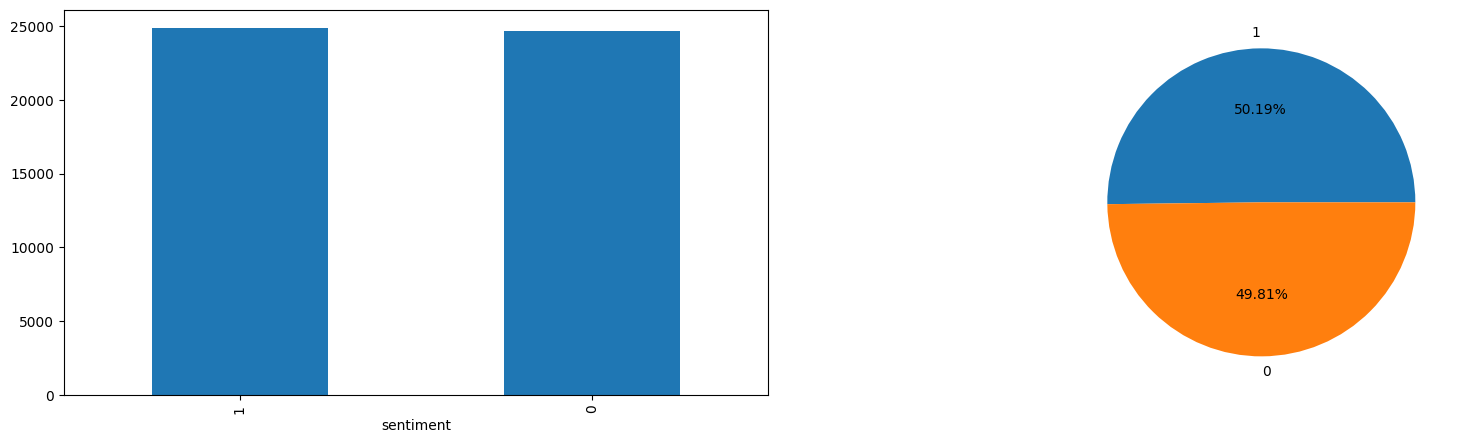

In [26]:
print(len(imdb_filtered))
label_info = imdb_filtered['sentiment'].value_counts()
print(label_info)

plt.figure(figsize=((20,5)))
plt.subplot(1,2,1)
label_info.plot.bar()

plt.subplot(1,2,2)
plt.pie(label_info,labels = label_info.index,autopct='%.2f%%')

plt.show()

## Output Clean intermediate data
Saving the preprocessed data produced into a csv file, allowing the cleaned data to be reaccessed quickly and easily.

In [27]:
imdb_filtered.to_csv("./data/cleaned_IMDB_data.csv", index=False)

In [28]:
# import df in utf-8 format
imdb_filtered = pd.read_csv("./data/cleaned_IMDB_data.csv")
imdb_filtered.head()

,review,sentiment
0,one of the other review has mention that after...,1
1,a wonder littl production. the film techniqu i...,1
2,i thought this was a wonder way to spend time ...,1
3,basic there a famili where a littl boy (jake) ...,0
4,"petter mattei ""love in the time of money"" is a...",1


# Text Visualization
Visualizes the frequency of the words for each category

## Word Clouds
### Positive Word Cloud

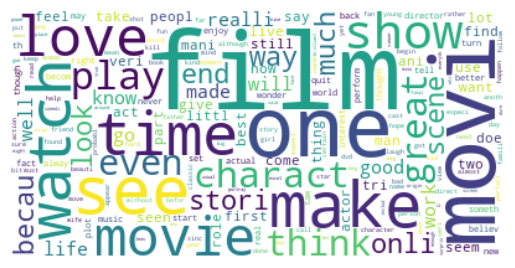

In [104]:
text_positive = " ".join(review for review in imdb_filtered[imdb_filtered["sentiment"] == "positive"]["review"])
wordcloud_positive = WordCloud(background_color="white").generate(text_positive)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative Word Cloud

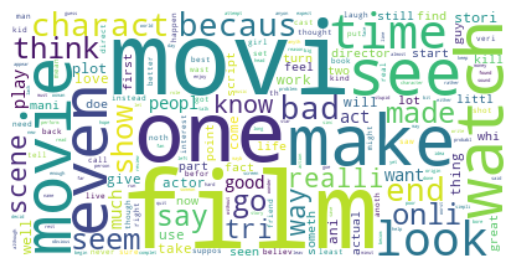

In [105]:
text_negative = " ".join(review for review in imdb_filtered[imdb_filtered["sentiment"] == "negative"]["review"])
wordcloud_negative = WordCloud(background_color="white").generate(text_negative)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorization
Creating a keras layer that vectorizes the texts into tokens

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
# Configurations: max_features (vocabs), max length (sequence length)
configurations = [(20_000, 500), (20_000, 200), (10_000, 200), (10_000, 500)]

In [7]:
vectorize_layers = [
    TextVectorization(
    max_tokens=max_feat,
    output_mode='int',
    output_sequence_length=max_len)
    for max_feat, max_len in configurations
]

In [8]:
[vectorize_layer.adapt(imdb_filtered['review']) for vectorize_layer in vectorize_layers]

[None, None, None, None]

In [ ]:
# Exporting the vectorize_layer for future use
pickle.dump([{'config': vectorize_layer.get_config(),
             'weights': vectorize_layer.get_weights(),
             'vocabs': vectorize_layer.get_vocabulary(),
             'parameter': configurations[i]} for i, vectorize_layer in enumerate(vectorize_layers)]
            , open("./vectorised_model/vectorizers.pkl", "wb"))

In [10]:
#  import the vectorizer
vectorizers = pickle.load(open("./vectorised_model/vectorizers.pkl", "rb"))

In [11]:
vectorizers

[{'config': {'name': 'text_vectorization',
   'trainable': True,
   'dtype': 'string',
   'batch_input_shape': (None, None),
   'max_tokens': 20000,
   'standardize': 'lower_and_strip_punctuation',
   'split': 'whitespace',
   'ngrams': None,
   'output_mode': 'int',
   'output_sequence_length': 500,
   'pad_to_max_tokens': False,
   'sparse': False,
   'ragged': False,
   'vocabulary': None,
   'idf_weights': None,
   'encoding': 'utf-8',
   'vocabulary_size': 20000},
  'weights': [array([b'the', b'and', b'a', ..., b'harpo', b'hanki', b'halo'],
         dtype=object)],
  'vocabs': ['',
   '[UNK]',
   'the',
   'and',
   'a',
   'of',
   'to',
   'is',
   'it',
   'in',
   'this',
   'i',
   'that',
   'was',
   'as',
   'film',
   'with',
   'for',
   'but',
   'movi',
   'on',
   'be',
   'have',
   'not',
   'you',
   'are',
   'he',
   'his',
   'one',
   'at',
   'all',
   'by',
   'like',
   'an',
   'who',
   'they',
   'from',
   'so',
   'there',
   'or',
   'just',
   'her',


# Modelling

In [29]:
#  change positive sentimanet to 1 and negative to 0
imdb_filtered['sentiment'] = imdb_filtered['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
imdb_filtered

,review,sentiment
0,one of the other review has mention that after...,0
1,a wonder littl production. the film techniqu i...,0
2,i thought this was a wonder way to spend time ...,0
3,basic there a famili where a littl boy (jake) ...,0
4,"petter mattei ""love in the time of money"" is a...",0
...,...,...
49575,i thought this movi did a down right good job....,0
49576,"bad plot, bad dialogue, bad acting, idiot dire...",0
49577,i am a cathol taught in parochi elementari sch...,0
49578,i'm go to have to disagre with the previous co...,0


## Train Test Split

In [31]:
#  train test split
X_train, X_test, y_train, y_test = train_test_split(imdb_filtered['review'], imdb_filtered['sentiment'], test_size=0.2, random_state=42, stratify=imdb_filtered['sentiment'])

## Helper Functions for Modelling

In [32]:
## This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric='auc'):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

In [33]:
lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False, restore_best_weights=True)
tn = TerminateOnNaN()

## LSTM Model

## CNN-1D Model

In [44]:
# create CNN model
def create_CNN1D(config_index):
    max_features, _ = configurations[config_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text_input'))
    model.add(vectorizers[config_index])
    model.add(Embedding(max_features + 1, 128))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [45]:
CNN1D = create_CNN1D(0)

CNN1D.summary()

TypeError: The added layer must be an instance of class Layer. Received: layer={'config': {'name': 'text_vectorization', 'trainable': True, 'dtype': 'string', 'batch_input_shape': (None, None), 'max_tokens': 20000, 'standardize': 'lower_and_strip_punctuation', 'split': 'whitespace', 'ngrams': None, 'output_mode': 'int', 'output_sequence_length': 500, 'pad_to_max_tokens': False, 'sparse': False, 'ragged': False, 'vocabulary': None, 'idf_weights': None, 'encoding': 'utf-8', 'vocabulary_size': 20000}, 'weights': [array([b'the', b'and', b'a', ..., b'harpo', b'hanki', b'halo'],
      dtype=object)], 'vocabs': ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'this', 'i', 'that', 'was', 'as', 'film', 'with', 'for', 'but', 'movi', 'on', 'be', 'have', 'not', 'you', 'are', 'he', 'his', 'one', 'at', 'all', 'by', 'like', 'an', 'who', 'they', 'from', 'so', 'there', 'or', 'just', 'her', 'about', 'has', 'out', 'if', 'what', 'some', 'good', 'make', 'more', 'get', 'time', 'when', 'see', 'veri', 'she', 'watch', 'even', 'up', 'no', 'would', 'my', 'which', 'their', 'onli', 'had', 'movie', 'can', 'realli', 'charact', 'were', 'me', 'do', 'other', 'than', 'much', 'well', 'most', 'look', 'we', 'show', 'will', 'bad', 'stori', 'scene', 'been', 'great', 'into', 'also', 'go', 'love', 'how', 'becaus', 'him', 'think', 'first', 'dont', 'play', 'end', 'way', 'peopl', 'made', 'then', 'them', 'your', 'thing', 'could', 'ani', 'too', 'know', 'seem', 'after', 'say', 'act', 'seen', 'mani', 'two', 'want', 'plot', 'never', 'take', 'come', 'work', 'where', 'did', 'best', 'littl', 'tri', 'life', 'ever', 'give', 'actor', 'over', 'better', 'man', 'off', 'doe', 'find', 'still', 'these', 'here', 'year', 'such', 'while', 'use', 'feel', 'part', 'lot', 'should', 'through', 'back', 'actual', 'those', 'im', 'real', 'whi', 'someth', 'doesnt', 'director', 'didnt', 'now', 'though', 'guy', 'cast', 'new', 'perform', 'same', 'interest', 'music', 'few', 'everi', 'old', 'start', 'enjoy', 'us', 'anoth', 'noth', 'cant', 'point', 'live', 'quit', 'again', 'turn', 'role', 'world', 'thought', 'fact', 'pretti', 'down', 'around', 'girl', 'young', 'got', 'befor', 'horror', 'own', 'star', 'set', 'enough', 'right', 'big', 'both', 'believ', 'may', 'kill', 'iv', 'between', 'long', 'action', 'bit', 'wonder', 'without', 'saw', 'need', 'isnt', 'day', 'must', 'almost', 'put', 'becom', 'script', 'whole', 'origin', 'least', 'last', 'tell', 'alway', 'high', 'kind', 'fan', 'done', 'hard', 'sure', 'complet', 'direct', 'person', 'far', 'might', 'happen', 'am', 'reason', 'line', 'friend', 'probabl', 'place', 'let', 'effect', 'name', 'tv', 'main', 'shot', 'help', 'sinc', 'away', 'call', 'final', 'minut', 'rather', 'yet', 'worst', 'woman', 'funni', 'mean', 'story', 'found', 'expect', 'each', 'kid', 'fun', 'book', 'read', 'laugh', 'beauti', 'lead', 'keep', 'our', 'differ', 'poor', 'run', 'screen', 'idea', 'however', 'anyth', 'hope', 'anyon', 'famili', 'begin', 'american', 'especi', 'comedi', 'dvd', 'although', 'worth', 'job', 'appear', 'wasnt', 'goe', 'certain', 'three', 'war', 'someon', 'sound', 'money', 'true', 'moment', 'special', 'version', 'seri', 'said', 'movies', 'dure', 'mayb', 'suppos', 'perfect', 'nice', 'move', 'night', '10', '2', 'instead', 'leav', 'understand', 'short', 'everyth', 'later', 'left', 'john', 'recommend', 'obvious', 'himself', 'second', 'black', 'follow', 'wast', 'problem', 'open', 'death', 'total', 'classic', 'mind', 'face', 'talk', 'human', 'wife', 'boy', 'everyon', 'entir', 'onc', 'miss', 'father', 'fall', 'review', 'dead', 'care', 'audienc', 'attempt', 'surpris', 'films', 'simpli', 'head', 'includ', 'usual', 'men', 'view', 'stupid', 'along', 'home', 'absolut', 'rememb', 'entertain', 'decid', 'hollywood', 'less', 'hour', 'episod', 'wrong', 'rest', 'fight', 'definit', 'half', 'given', 'viewer', 'sens', 'lack', 'murder', 'coupl', 'until', 'women', 'hand', 'excel', 'product', 'either', 'involv', 'portray', 'particular', 'school', 'chang', 'camera', 'truli', 'piec', 'next', 'write', 'video', 'save', 'came', 'power', 'characters', 'bring', 'full', 'bore', 'anim', 'sever', 'clear', 'talent', 'sex', 'featur', 'sort', 'song', 'die', 'top', 'budget', 'mother', 'case', 'funny', 'itself', 'except', 'humor', 'game', 'often', 'small', 'couldnt', 'serious', 'near', 'meet', 'guess', 'rate', 'style', 'went', 'creat', 'eye', 'acting', 'children', 'dark', 'base', 'word', 'earli', 'consid', 'comment', 'possibl', 'produc', 'perhap', 'togeth', 'felt', 'hous', 'manag', 'lost', 'close', 'emot', 'cinema', 'releas', 'flick', 'character', 'written', 'against', 'art', 'els', 'killer', 'stop', 'drama', 'ask', 'extrem', 'brother', 'actress', 'mention', 'car', 'learn', 'brilliant', 'support', 'low', 'matter', 'under', 'terribl', 'side', 'evil', 'wont', 'son', 'white', 'sad', 'cut', 'yes', 'pictur', 'youll', 'amaz', 'wait', '3', 'forc', 'hit', 'writer', 'joke', 'id', 'throughout', 'abl', 'cours', 'titl', 'present', 'fine', 'age', 'oh', 'heart', 'deal', 'fail', 'wish', 'walk', 'today', 'light', 'basic', 'despit', 'Â\x96', 'michael', 'type', 'stand', 'strong', 'theyr', 'hate', 'sit', 'past', 'town', 'rent', 'group', 'gave', 'stay', 'people', 'relationship', 'favorit', 'alreadi', 'daughter', 'score', 'hero', 'number', 'behind', 'scenes', 'impress', 'major', 'add', '1', 'realiz', 'stuff', 'question', 'child', 'success', 'sequenc', 'late', 'god', 'general', 'exact', 'myself', 'course', 'qualiti', 'order', 'decent', 'imagin', 'ill', 'soon', 'took', 'dialogu', 'develop', 'robert', 'theme', 'heard', 'twist', 'hell', 'deserv', 'mr', 'sometim', 'return', 'horribl', 'disappoint', 'touch', 'voic', 'times', 'blood', 'fair', 'aw', 'wouldnt', 'credit', 'cannot', 'told', 'pick', 'british', 'incred', 'experi', 'slow', 'hold', 'huge', 'appar', 'event', 'compar', 'shown', 'continu', 'opinion', 'taken', 'cool', 'natur', 'level', 'comedy', 'similar', 'comic', 'import', 'career', 'novel', 'danc', 'provid', 'husband', 'david', 'mysteri', 'allow', 'across', 'speak', 'known', 'filmmak', 'relat', 'local', 'hear', 'years', 'offer', 'element', 'ago', 'buy', 'monster', 'figur', 'caus', 'shoot', 'crap', 'ok', 'pain', 'whose', 'english', 'break', 'recent', 'jame', 'thank', 'actors', 'none', 'gore', 'check', 'result', 'effort', 'room', 'yourself', 'wors', 'subject', 'polic', 'focus', 'team', 'series', 'femal', 'pull', 'sister', 'somewhat', 'knew', 'etc', 'critic', 'annoy', 'chanc', 'beyond', 'visual', 'citi', 'dialog', 'explain', 'deliv', 'anyway', 'sequel', 'exampl', 'strang', 'cover', 'state', 'due', 'remind', 'theater', 'jack', 'convinc', 'dog', 'bodi', 'toward', 'pace', 'cheap', 'upon', '5', 'pay', 'carri', 'prove', 'king', 'form', 'arent', 'four', 'modern', 'tale', 'singl', 'shock', 'edit', 'cop', '4', 'pleas', 'doubt', 'dream', 'sexual', 'avoid', 'fit', 'typic', 'thriller', 'remain', 'note', 'rock', 'season', 'pass', 'fill', 'happi', 'spend', 'earth', 'quick', 'french', 'whether', 'soundtrack', 'polit', 'havent', 'win', 'ten', 'space', 'previous', 'georg', 'ladi', 'discov', 'histori', 'bunch', 'class', 'street', 'weak', 'train', 'captur', 'howev', 'ridicul', 'forget', 'themselv', 'within', 'apart', 'unlik', 'five', 'greatest', 'peter', 'dull', 'stage', 'situat', 'member', 'unfortun', 'simpl', 'plan', 'mark', 'angel', 'zombi', 'william', 'among', 'villain', 'richard', 'honest', 'crime', 'western', 'drive', 'fire', 'admit', 'doctor', 'documentari', 'build', 'sing', 'easili', 'minutes', 'kept', 'air', 'lose', 'york', 'detail', 'ad', 'gone', 'respect', 'overal', 'aspect', 'charm', 'famous', 'countri', 'appreci', 'period', 'hilari', 'chase', 'romant', 'secret', 'attack', 'straight', 'gun', 'brought', 'artist', 'throw', 'master', 'escap', 'middl', 'herself', 'truth', 'contain', 'box', 'dr', 'oscar', 'odd', 'larg', 'youv', 'intellig', 'utter', 'silli', 'marri', 'mess', 'posit', 'parent', 'somehow', 'suggest', 'pure', 'realiti', 'shame', 'bill', 'paul', 'genr', 'notic', 'agre', 'water', 'rare', 'soldier', 'accept', 'excit', 'alien', 'america', 'imag', 'together', 'suffer', 'describ', 'boring', 'messag', 'confus', 'tom', 'finish', 'match', 'teenag', 'date', 'normal', 'mix', 'easi', 'list', 'adult', 'predict', 'red', 'bother', 'abov', 'reveal', 'before', 'copi', 'battl', 'difficult', 'deep', 'crew', 'offic', 'attent', 'fast', 'lame', 'televis', 'suspens', 'sudden', 'okay', 'male', 'ending', 'eventu', 'drug', 'treat', 'slight', 'gay', 'weird', 'island', 'constant', 'valu', 'imdb', 'cartoon', 'becam', 'student', 'cinematographi', 'clever', 'background', 'awful', 'victim', 'scifi', 'lee', 'performance', 'color', 'third', 'german', 'alon', 'screenplay', 'hot', 'interesting', 'ultim', 'depict', 'fear', 'rich', 'wear', 'refer', 'adapt', 'family', 'whom', 'prison', 'nor', 'narrat', 'effects', '20', 'public', 'unless', 'superb', 'appeal', 'week', 'violenc', 'studio', 'project', 'forward', 'inspir', 'dumb', 'grow', 'exist', 'control', 'de', 'amount', 'free', 'various', 'plus', 'spirit', 'ride', 'scari', 'dramat', 'older', 'earlier', 'design', 'disney', 'joe', 'wit', 'mad', 'struggl', 'steal', 'fiction', 'express', 'girlfriend', 'stick', 'plain', 'front', 'unfortunately', 'attract', 'atmospher', 'b', 'popular', 'troubl', 'fantast', 'bare', 'original', 'magic', 'plenti', 'spent', 'lie', 'accent', 'standard', 'jump', 'catch', 'land', 'meant', 'locat', 'equal', 'japanes', 'track', 'serv', 'moral', 'frank', 'scream', 'beat', 'premis', 'concept', 'caught', 'realist', 'connect', 'uniqu', 'band', 'cute', 'listen', 'fli', 'memor', 'italian', 'histor', 'averag', 'combin', 'whatev', 'familiar', 'insid', 'scare', 'store', 'travel', 'issu', 'social', 'house', 'example', 'why', 'share', 'futur', 'cri', 'award', 'outsid', 'vampir', 'eat', 'storylin', 'else', 'channel', 'brain', 'answer', 'wer', 'audience', 'term', 'dress', 'sweet', 'sense', 'repeat', 'wood', 'ghost', 'sorri', 'further', 'cat', 'former', 'van', 'footag', 'busi', 'remak', 'tension', 'nation', 'reach', 'lover', 'common', 'search', 'depth', 'park', 'materi', 'terrible', 'violent', 'era', 'destroy', 'really', 'hair', 'cheesi', 'los', 'record', 'fake', 'sick', 'flat', 'scott', 'clichÃ©', 'harri', 'spoiler', 'compani', 'roll', 'wrote', 'kick', 'drag', 'wild', 'mere', 'claim', 'camp', 'danger', 'soul', 'cold', 'younger', 'neither', 'biggest', 'tone', 'complex', 'blue', 'approach', 'adventur', 'introduc', 'jane', 'cultur', 'teen', 'choic', 'inform', 'indian', 'gang', 'pointless', 'amus', 'friends', 'ruin', 'parti', 'trash', 'trip', 'solid', 'mari', 'door', 'potenti', 'crazi', 'step', 'million', 'desper', 'central', '30', 'genuin', '80', 'ann', 'pop', 'others', 'sleep', 'longer', 'babi', 'concern', 'race', 'werent', 'romanc', 'innoc', 'maker', 'glad', 'promis', 'physic', 'mental', 'ship', 'costum', 'things', 'worse', 'ben', '15', 'receiv', 'creepi', '12', 'suck', 'hurt', 'moments', 'ignor', 'humour', 'days', 'road', 'flaw', 'disturb', 'delight', 'genius', 'stereotyp', 'respons', 'bond', 'surviv', 'player', 'minor', 'execut', 'commit', 'spot', 'genre', 'suit', 'fantasi', 'journey', 'engag', 'visit', 'mood', 'drop', 'yeah', 'manner', 'rais', 'dialogue', 'consist', 'bought', 'occasion', 'regard', 'abil', 'warn', 'fascin', 'intens', 'faith', 'immedi', 'intent', 'performances', 'law', 'bed', 'entertaining', 'limit', 'rape', 'silent', 'slasher', 'memori', 'scientist', 'west', 'south', 'judg', 'creatur', 'sign', 'something', 'brutal', 'dad', 'planet', 'imposs', 'achiev', 'suspect', 'giant', 'seriously', 'excus', 'scienc', 'random', 'extra', 'display', 'univers', 'tough', 'sam', 'enter', 'embarrass', 'count', 'haunt', 'arriv', 'jim', 'burn', 'liter', 'skill', 'nobodi', 'handl', 'societi', 'remark', '7', 'history', 'cult', 'otherwis', '8', 'direction', 'won', 'redeem', 'bizarr', 'fashion', '90', 'london', 'cinemat', 'rip', 'paint', 'passion', '100', 'smart', 'christian', 'ring', 'agent', 'hole', 'collect', 'draw', 'toni', 'ray', 'picture', 'send', 'trailer', 'stars', 'loud', 'anything', 'charl', 'interview', 'comput', 'club', 'sell', 'thrown', 'episode', 'stun', 'excellent', 'intrigu', 'colleg', 'tortur', 'push', 'cross', 'steve', 'green', 'bar', 'area', 'affair', 'explor', 'detect', 'grace', 'gem', 'blow', 'tire', 'boss', 'author', 'ground', 'boyfriend', 'roles', 'plane', 'opera', 'climax', 'seek', 'report', 'damn', 'hang', 'self', 'requir', 'inde', 'content', 'chemistri', 'chris', 'brief', 'assum', 'wind', 'fresh', 'kids', 'generat', 'broadcast', 'key', 'idiot', 'makeup', 'technic', 'intend', 'blame', 'russian', 'insult', 'conflict', 'smith', 'hey', 'smile', 'thus', 'practic', 'hilarious', 'current', 'christma', 'motion', 'demon', 'compel', 'bruce', 'beautiful', 'sent', 'succeed', 'youd', 'wall', 'hide', 'arm', 'studi', 'ed', '80s', 'vote', 'hire', 'watching', 'rule', 'lines', 'join', 'avail', 'martin', 'tradit', 'masterpiec', 'everybodi', 'phone', 'opportun', 'obsess', 'purpos', 'militari', 'govern', 'fulli', 'loos', 'creativ', 'teacher', 'exploit', 'desert', 'initi', 'violence', 'station', 'mistak', 'charli', 'center', 'graphic', 'tast', 'prepar', 'frame', 'fell', 'crimin', 'bottom', 'armi', 'tape', '9', 'experience', 'billi', 'resembl', 'overall', 'admir', '6', 'serial', 'affect', 'trap', 'profession', 'mom', 'protagonist', 'horrible', 'hunt', 'wow', 'repres', 'production', 'hitchcock', 'crash', 'summer', 'strike', 'stewart', 'impact', 'edg', 'system', 'surround', 'spoil', 'christoph', 'nake', 'tear', 'radio', 'born', 'rise', 'news', 'reflect', 'gorgeous', 'disappointed', 'investig', 'twice', 'essenti', 'batman', 'prefer', 'captain', 'queen', 'besid', 'negat', 'lesson', 'flashback', '50', 'tragic', 'epic', 'month', 'bear', 'centuri', 'pair', 'fellow', 'independ', 'funniest', 'ahead', 'gag', 'evid', 'choos', 'skip', 'paid', 'mouth', 'drink', 'languag', 'church', 'hasnt', 'board', 'motiv', 'unbeliev', 'subtl', 'somewher', 'process', 'pathet', 'hotel', 'terrif', 'tend', 'nothing', 'accident', 'absurd', 'intern', 'vs', 'trust', 'post', 'logic', 'led', 'field', 'stone', 'bomb', 'ii', 'unit', 'reaction', 'six', 'sight', 'page', 'shouldnt', 'model', '70s', 'thorough', 'remot', 'discuss', 'themselves', 'stuck', 'onto', 'grade', 'sexi', 'program', 'drawn', 'cameo', 'reveng', 'tie', 'dub', 'city', 'challeng', 'asid', 'sport', 'shop', 'jackson', 'forgotten', 'heavi', 'eyes', 'superior', 'does', 'youth', 'porn', 'guys', 'mine', 'addit', 'vision', 'nuditi', 'another', 'super', 'slowli', 'pleasant', 'teach', 'latter', 'adam', 'recogn', 'fool', 'corpor', 'presenc', 'encount', 'quiet', 'dollar', 'desir', 'wooden', 'thrill', 'refus', 'mile', 'leader', 'highlight', 'psycholog', 'joy', 'beginning', 'round', 'don', 'regular', 'blind', 'jason', 'folk', 'cgi', 'noir', 'ford', 'sea', 'depress', 'proper', 'pilot', 'childhood', 'lord', 'title', 'kevin', 'entertainment', 'replac', 'individu', '70', 'fans', 'object', 'heaven', 'cost', 'thin', 'lives', 'nomin', 'fox', 'clue', 'cloth', 'occur', 'clean', 'afraid', 'ryan', 'awesom', 'influenc', 'witch', 'predictable', 'correct', 'held', 'began', 'iron', 'terror', 'readi', 'pack', 'hors', 'market', 'comparison', 'henri', 'friendship', 'wide', 'singer', 'favourit', 'decad', 'rescu', 'favor', 'food', 'crowd', 'doubl', 'amazing', 'words', 'hidden', 'laughabl', 'brown', 'zero', 'test', 'legend', 'hill', 'window', 'tim', 'rating', 'load', 'gangster', 'dare', 'shine', 'machin', 'unknown', 'fat', 'stock', 'seven', 'ridiculous', 'mask', 'worthi', 'industri', 'hunter', 'jr', 'river', 'possible', 'ball', 'price', 'outstand', 'boat', 'mike', 'formula', 'abus', 'satisfi', 'rob', 'partner', 'moon', 'convey', 'bland', 'unusu', 'sat', 'martial', 'owner', 'stephen', 'length', 'kelli', 'grand', 'writing', 'kiss', 'buddi', 'sceneri', 'once', 'contrast', 'rang', 'improv', 'religi', 'commerci', 'steven', 'gold', 'disgust', 'danni', 'blond', 'johnni', 'dirti', 'mission', 'jean', 'alone', 'thousand', 'segment', 'mister', 'floor', 'establish', 'mediocr', 'howard', 'fate', 'symbol', 'reality', 'protect', 'priest', 'jerri', 'dread', 'rush', 'bright', 'bloodi', 'jone', 'hospit', 'cinematography', 'awkward', 'arthur', 'photographi', 'hint', '40', 'nowher', 'european', 'foreign', 'virtual', 'target', 'met', 'comed', 'roger', 'photograph', 'eddi', 'brian', 'behavior', 'tune', 'research', 'fault', 'convers', 'nasti', 'al', 'insight', 'accord', 'alan', 'bob', 'allen', 'ways', 'devil', 'davi', 'nativ', 'masterpiece', 'hundr', 'chick', 'vhs', 'trick', 'transform', 'sum', 'demand', 'awar', 'whilst', 'frustrat', 'patient', 'loss', 'grant', 'strength', 'golden', 'fame', 'lone', 'endless', 'lowbudget', 'deepli', 'robot', 'irrit', 'everything', 'possess', 'ms', 'girls', 'wise', 'separ', 'pleasur', 'chines', 'weapon', 'privat', 'mild', 'dozen', 'satir', 'parts', 'heroin', 'hadnt', 'accur', 'warm', 'somebodi', 'shows', 'marriag', 'decis', 'celebr', 'belong', 'aim', 'movement', 'curious', 'bank', 'aliv', 'scary', 'robin', 'indeed', 'subplot', 'speech', 'anyone', 'anybodi', 'pretend', 'mrs', 'interact', 'seat', 'disappear', 'wed', 'ie', 'suspense', 'soap', 'gotten', 'festiv', 'spectacular', 'flow', 'sean', 'ones', 'confront', 'account', 'debut', 'below', 'revolv', 'bigger', 'therefor', 'different', 'taylor', 'worri', 'mountain', 'juli', 'finest', 'lock', 'kidnap', 'jokes', 'england', 'broken', 'thoma', 'stories', 'numer', 'media', 'insan', 'unexpect', 'site', 'realism', 'opposit', 'kinda', 'marvel', 'stretch', 'lynch', 'likabl', 'compet', 'commentari', 'reli', 'rank', 'invent', 'everyone', 'speed', 'annoying', 'recal', 'drunk', 'whenev', 'pari', 'flesh', 'feet', 'angl', 'sheer', 'increas', 'c', 'stranger', 'jeff', 'australian', 'academi', 'abandon', 'shadow', 'nick', 'joan', 'actually', 'max', 'knock', 'wev', 'rubbish', 'root', 'happened', 'command', 'capabl', 'ugli', 'notabl', 'network', 'ice', 'andi', 'wonderful', 'uncl', 'twenti', 'realis', 'future', 'garbag', 'country', 'shallow', 'quality', 'higher', 'craft', 'spanish', 'conclus', 'angri', 'suicid', 'magnific', 'ident', 'storyline', 'crappi', 'civil', 'theatr', 'explan', 'progress', 'hook', 'grab', 'freak', 'breath', 'attitud', 'jennif', 'complain', 'flash', 'unabl', 'spoof', 'release', 'beach', 'surreal', 'gain', 'dislik', 'contribut', 'context', 'veteran', 'knowledg', 'driver', 'dan', 'punch', 'factor', 'signific', 'eric', 'cage', 'nightmar', 'determin', 'sheriff', 'lesbian', 'interpret', 'hall', 'safe', 'matt', 'surprise', 'fish', 'threaten', 'gari', 'regret', 'ran', 'hours', 'freedom', 'bet', 'cash', 'villag', 'rose', 'd', 'anthoni', 'smoke', 'paper', 'jimmi', 'trek', 'piti', 'associ', 'works', 'snake', 'shakespear', 'nazi', 'guard', 'luck', 'wake', 'theyv', 'please', 'parodi', 'gonna', 'energi', 'depend', 'laughs', 'grew', 'empti', 'believable', 'asian', 'guest', 'material', 'experienc', 'belief', 'society', 'print', 'prais', 'ordinari', 'episodes', 'heck', 'demonstr', 'charg', 'assist', 'statement', 'appropri', 'sharp', 'stunt', 'killed', 'documentary', 'sole', 'alex', 'sake', 'keaton', 'japan', 'disast', 'chance', 'buck', 'barbara', 'assassin', 'aka', 'specif', 'problems', 'frequent', 'fred', 'relief', 'moor', 'justic', 'happens', 'wander', 'treatment', 'simple', 'rough', 'presid', 'invit', 'edward', 'tight', 'rain', 'enemi', 'credibl', 'comfort', 'switch', 'hitler', 'editing', 'tedious', 'religion', 'necessari', 'instant', 'chaplin', 'hat', 'daniel', 'north', 'bug', 'stumbl', 'soft', 'jesus', 'ancient', 'frighten', 'finally', 'altern', 'tree', 'promot', 'halloween', 'gene', 'dick', 'clip', 'tragedi', 'topic', 'sourc', 'skin', 'realistic', 'laughter', 'fortun', 'crack', 'andrew', 'built', 'theatric', 'sky', 'host', 'chill', 'pile', 'anna', 'amateurish', 'wayn', 'lower', 'footbal', 'chief', 'advanc', 'translat', 'seagal', 'letter', 'kong', 'corrupt', 'observ', 'chan', 'ass', 'anymore', 'secur', 'quot', 'prime', 'betti', 'winner', 'sitcom', 'section', 'proceed', 'grip', 'gift', 'earn', 'development', 'comedian', 'accomplish', 'uk', 'tini', 'path', 'situation', 'silly', 'amateur', 'professor', 'grave', 'attention', 'simon', 'complic', 'sentiment', 'honor', 'expert', 'cheat', 'canadian', 'attend', 'accompani', 'wave', 'r', 'harsh', 'consider', 'rental', 'truck', 'techniqu', 'romance', 'glass', 'welcom', 'slapstick', 'distract', 'sorry', 'gordon', 'fare', 'cell', 'oper', 'distinct', 'contemporari', 'anderson', 'dude', 'domin', 'core', 'underr', 'solv', 'involved', 'chosen', 'alive', 'scenario', 'till', 'recommended', 'psycho', 'proud', 'meaning', 'aid', 'shape', 'remov', 'wilson', 'morgan', 'jacki', 'identifi', 'convent', 'albert', '60', 'whatsoever', 'werewolf', 'walter', 'lake', 'holm', 'nevertheless', 'manipul', 'maintain', '1010', 'indic', 'educ', 'risk', 'patrick', 'massiv', 'defin', 'curs', 'propaganda', 'washington', 'activ', 'wound', 'television', 'saturday', 'latest', 'grown', 'explos', 'clark', 'balanc', 'unnecessari', 'turkey', 'mi', 'denni', 'viewing', 'tarzan', 'shots', 'leg', 'expos', 'accid', 'nonsens', 'sequence', 'lucki', 'vehicl', 'rival', 'reasons', 'larri', 'halfway', 'anger', 'very', 'scale', 'borrow', 'toy', 'joseph', 'wrap', 'servic', 'mirror', 'construct', 'colour', 'lane', 'la', 'atmosphere', 'african', 'lawyer', 'garbage', 'unintent', 'task', 'prevent', 'asleep', 'enjoyable', 'dean', 'compos', 'organ', 'jewish', 'gratuit', 'friday', 'emerg', 'sadly', 'ripoff', 'message', 'ted', 'stare', 'says', 'princ', 'otherwise', 'morn', 'kate', 'franc', 'contact', 'spi', 'nudity', 'johnson', 'foot', 'body', 'blend', 'link', 'hood', 'chose', 'anywher', 'thinking', 'forgiv', 'addict', 'songs', 'sensit', 'monkey', 'weekend', 'mexican', 'finger', 'conclusion', 'texa', 'vietnam', 'nurs', 'melodrama', 'glimps', 'cook', 'unfold', 'spell', 'reminisc', 'loui', 'inept', 'f', 'communiti', 'clichÃ©d', 'broadway', 'bmovi', 'spoilers', 'roy', 'parker', 'lift', 'elizabeth', 'andor', 'urban', 'cruel', 'matur', 'irish', 'refresh', 'pretenti', 'forth', 'donald', 'brave', 'purchas', 'prior', 'forest', 'fantastic', 'disappointment', 'trial', 'neighbor', 'forgot', 'contriv', 'closer', 'brook', 'sequences', 'parents', 'overthetop', 'indi', 'flight', 'dracula', 'court', 'china', 'alic', 'ador', '60s', '13', 'puppet', 'mainstream', 'intellectu', 'aint', 'sympathet', 'subtitl', 'southern', 'sir', 'insist', 'cynic', 'cabl', 'helen', 'creator', 'drew', 'dig', 'cooper', 'card', 'wolf', 'upset', 'forev', 'eastwood', 'castl', '25', 'witti', 'sun', 'profound', 'julia', 'handsom', 'argu', 'spite', 'lousi', 'guid', 'directing', 'accus', 'sympathi', 'structur', 'mass', 'format', 'unfunni', 'routin', 'beast', 'africa', 'stolen', 'medic', 'gross', 'citizen', 'business', 'willi', 'superman', 'lewi', 'dougla', 'dancer', 'cousin', '11', 'strip', 'string', 'inner', 'cowboy', 'victor', 'captiv', 'watchabl', 'outrag', 'multipl', 'greater', 'gori', 'freddi', 'cheer', 'usa', 'screenwrit', 'downright', 'birth', 'benefit', 'shut', 'lay', 'laughable', 'jail', 'california', 'vagu', 'shake', 'offend', 'junk', 'instance', 'eight', 'devic', 'credits', 'controversi', 'bird', 'advic', 'wouldv', 'via', 'points', 'bag', 'acted', 'whoever', 'underground', 'twin', 'princess', 'overlook', 'offens', 'forever', 'code', 'warner', 'slap', 'justifi', 'ideal', 'driven', 'dragon', 'storm', 'poster', 'east', 'deeper', 'concert', 'san', 'mystery', 'little', 'vast', 'technolog', 'situations', 'satan', 'reject', 'method', 'deni', 'press', 'peac', 'alright', 'legendari', 'ton', 's', 'russel', 'mickey', 'inevit', 'india', 'crude', 'bitter', 'bell', 'terrorist', 'teeth', 'neat', 'kim', 'doom', 'beauty', 'arrest', 'menac', 'guilti', 'facial', 'dri', 'corni', 'select', 'sarah', 'metal', 'encourag', 'bite', 'santa', 'resid', 'plant', 'luke', 'hed', 'depart', 'century', 'blown', 'viewers', 'status', 'raw', 'mob', 'complaint', 'bus', 'barri', 'understood', 'sucks', 'laura', 'fu', 'entri', 'endur', 'defeat', 'vincent', 'necessarili', 'miller', 'fulci', 'fals', 'convict', 'fatal', 'failur', 'doll', 'creation', 'coach', 'chuck', 'bullet', 'heavili', 'dinner', 'couldv', 'voice', 'st', 'seeing', 'nude', 'mgm', 'concentr', 'bridg', 'awesome', 'animation', 'sunday', 'overcom', 'oppos', 'hoffman', 'funnier', 'employ', 'sword', 'sink', 'sinatra', 'language', 'kane', 'imit', 'fbi', 'everyday', 'events', 'defend', '2001', 'writerdirector', 'j', 'corner', 'afternoon', 'advertis', 'susan', 'strict', 'settl', 'released', 'perspect', 'offici', 'loser', 'bone', 'advis', 'subsequ', 'nuclear', 'confess', 'varieti', 'tour', 'pregnant', 'hopeless', 'expens', 'yell', 'value', 'reput', 'carpent', 'swim', 'supernatur', 'racist', 'ocean', 'border', 'winter', 'sets', 'revel', 'racism', 'quest', 'nail', 'mindless', 'merit', 'lisa', 'elder', 'dinosaur', 'baby', 'pursu', 'extraordinari', 'extend', 'chair', 'pitch', 'ninja', 'lloyd', 'hong', 'devot', 'closeup', 'blatant', 'amongst', '1950s', 'gas', 'blair', 'screw', 'lion', 'degre', 'address', 'virgin', 'render', 'oliv', 'needless', 'hype', 'beg', 'always', 'liber', 'eg', '1970s', 'worker', 'warrior', 'transfer', 'terrifi', 'many', 'excess', 'walker', 'standards', 'spin', 'sincer', 'jungl', 'internet', 'gather', 'fourth', 'bollywood', 'union', 'showcas', 'reward', 'rage', 'pose', 'overact', 'extent', 'blah', 'wwii', 'preview', 'naiv', 'karen', 'spare', 'size', 'poignant', 'nature', 'disbelief', 'columbo', 'bound', 'swear', 'dear', 'condit', 'burton', 'buri', 'tremend', 'o', 'bat', 'widow', 'unbelievable', 'sin', 'parallel', 'holiday', 'belov', 'expected', 'consequ', 'chain', 'trade', 'theori', 'culture', 'argument', 'wing', 'unrealist', 'stylish', 'moving', 'gruesom', 'dedic', 'behav', 'alcohol', 'stomach', 'stab', 'soviet', 'party', 'par', 'le', 'going', 'descript', 'contest', 'authent', 'aunt', 'albeit', 'remember', 'piece', 'icon', 'gut', 'farm', 'cure', 'von', 'sutherland', 'silver', 'scheme', 'nose', 'incid', 'carol', 'cain', 'boys', 'jon', 'jerk', 'festival', 'catherin', 'attach', 'tabl', 'shed', 'ron', 'presum', 'agenc', '810', 'wreck', 'pathetic', 'fix', 'costar', 'chop', 'australia', 'split', 'relev', 'proof', 'greek', 'daili', 'believe', 'sold', 'row', 'particip', 'overwhelm', 'hank', 'goal', 'fallen', 'dawn', 'dave', 'portrait', 'nonetheless', 'miscast', 'itth', 'filmth', 'crush', 'communic', 'books', 'x', 'tommi', 'toler', 'shower', 'premise', 'pan', 'pacino', 'movieth', 'fade', 'ear', 'boot', 'text', 'socal', 'snow', 'murphi', 'erot', 'block', 'woodi', 'setting', 'reduc', 'moron', 'examin', 'appli', 'popul', 'mexico', 'suitabl', 'plastic', 'corps', 'betray', 'stanwyck', 'potential', 'foster', 'courag', 'treasur', 'thumb', 'shark', 'resort', 'jay', 'feed', 'pet', 'matrix', 'firm', 'cameron', 'wherea', 'resist', 'leagu', 'buff', 'blockbust', 'bergman', 'user', 'thirti', 'setup', 'notori', 'mate', 'maria', 'duke', 'victoria', 'uniform', 'miser', 'hammer', 'drugs', 'button', 'adopt', 'ranger', 'guarante', 'damag', 'candi', 'burt', 'blade', 'beer', 'basebal', 'backdrop', 'photo', 'kung', 'heat', 'hands', 'britain', 'ticket', 'punish', 'mst3k', 'grim', 'dance', '1980s', 'recreat', 'midnight', 'michell', 'introduct', 'costs', 'threat', 'reviews', 'regardless', 'meanwhile', 'isol', 'inhabit', 'hack', 'change', 'brand', '14', 'useless', 'slip', 'shift', 'rachel', 'flynn', 'europ', 'comments', 'cave', 'weight', 'retard', 'react', '45', 'thief', 'spoken', 'pitt', 'office', 'jess', 'jami', 'iti', 'dump', 'campi', 'wash', 'values', 'shout', 'pool', 'polish', 'knight', 'float', 'enhanc', 'crazy', 'brad', 'wealthi', 'philip', 'pat', 'korean', 'imagination', 'freeman', 'already', 'survivor', 'stalk', 'n', 'fond', 'birthday', 'bath', '2005', 'taste', 'nowhere', 'goofi', 'cheesy', 'bobbi', '710', 'zone', 'vivid', 'non', 'moviei', 'jessica', 'horrif', 'stan', 'khan', 'announc', 'website', 'tribut', 'toilet', 'punk', 'eager', 'deliber', 'con', 'broke', '1980', 'surfac', 'storytel', 'spark', 'nine', 'jonathan', 'gotta', 'fx', 'died', 'arnold', 'torn', 'sentenc', 'quirki', 'hbo', 'gritti', 'garden', 'elev', 'digit', 'bride', 'sinist', 'ha', 'clich', 'trail', 'strange', 'sandra', 'landscap', 'knife', 'fabul', 'exagger', 'enorm', 'dealt', 'creepy', 'tarantino', 'notch', 'memorable', 'fighter', 'experiment', 'circumst', 'assign', 'outer', 'norman', 'march', 'lesli', 'justice', 'homag', 'flaws', 'struck', 'pride', 'nois', 'lady', 'g', 'flicks', 'editor', '110', 'sophist', 'rebel', 'neck', 'musician', 'muppet', 'filmmaking', 'explicit', 'ends', 'wick', 'goes', 'fanci', 'error', 'disappointing', 'asham', 'wanna', 'spiritu', 'shall', 'purpose', 'lesser', 'exchang', 'diamond', 'appal', 'amusing', '90s', 'zombies', 'laurel', 'fairi', 'emma', 'dian', 'deliveri', 'afford', 'theyd', 'obscur', 'mistake', 'integr', 'hugh', 'heist', 'germani', 'directed', 'basement', 'advantag', 'sleazi', 'rid', 'piano', 'neighborhood', 'mel', 'matthau', 'jake', 'heroic', 'alter', '2000', 'relax', 'precious', 'oil', 'exercis', 'comedies', 'cardboard', 'boredom', 'assur', 'scarecrow', 'portion', 'per', 'paris', 'meat', 'label', 'infam', 'christ', 'ward', 'roman', 'oz', 'nanci', 'camerawork', '1950', 'unconvinc', 'sub', 'stood', 'spring', 'silenc', 'outfit', 'lazi', 'ideas', 'explod', 'escape', 'electr', 'creep', 'aspir', '20th', '2006', 'worthwhil', 'vacat', 'tender', 'sidney', 'restor', 'predat', 'ludicr', 'immens', 'ape', 'rat', 'pulp', 'prostitut', 'laid', 'honestly', 'fulfil', 'cannib', 'because', 'trite', 'sneak', 'ralph', 'obnoxi', 'notion', 'henc', 'health', 'easier', 'clint', 'adventure', '18', 'saying', 'retir', 'photography', 'persona', 'invis', 'happy', 'gate', 'police', 'minim', 'homosexu', 'hal', 'financi', 'expectations', 'carl', 'calm', 'butt', 'blast', 'threw', 'stole', 'smooth', 'remake', 'puzzl', 'instal', 'illustr', 'company', 'broad', '1st', 'urg', 'toss', 'tens', 'stress', 'spread', 'salli', 'matthew', 'mansion', 'linda', 'guilt', 'frankenstein', 'flawless', 'conveni', 'cinderella', 'woods', 'wars', 'substanc', 'pie', 'nelson', 'inspector', 'footage', 'fifteen', 'deriv', 'combat', 'cabin', 'astonish', 'swing', 'spielberg', 'sadist', 'lyric', 'impressive', 'imageri', 'hyster', 'grey', 'disguis', 'bush', 'breast', 'austen', 'uninterest', 'racial', 'princip', 'pound', 'owen', 'only', 'metaphor', 'lovabl', 'hudson', 'horrid', 'hardi', 'gothic', 'dynam', 'directori', 'assault', 'access', '410', 'uncomfort', 'spike', 'sidekick', 'shoulder', 'revenge', 'owe', 'lugosi', 'lifetim', 'flop', 'feature', 'duti', 'couple', 'charisma', 'apparently', '50s', 'ruthless', 'disagre', 'climb', 'cathol', 'brazil', 'suicide', 'stiff', 'slaughter', 'since', 'provok', 'mistaken', 'mid', 'medium', 'kubrick', 'hip', 'generous', 'brothers', 'bleak', '910', '1970', 'web', 'tall', 'steel', 'stanley', 'staff', 'journalist', 'jones', 'folks', 'destruct', 'countless', 'audiences', 'miniseri', 'hamlet', 'distant', 'contract', 'confid', 'vicious', 'scenery', 'reallif', 'hawk', 'fund', 'ex', 'eve', 'environ', 'elabor', 'dreams', 'chicago', 'baker', 'aside', 'premier', 'perfectly', 'issues', 'hippi', 'gentl', 'evok', 'doing', 'cring', 'alli', 'shoe', 'seduc', 'prop', 'happening', 'glenn', 'dies', 'circl', 'abrupt', 'throat', 'theyll', 't', 'scratch', 'maniac', 'ensembl', 'emili', 'butcher', 'timeless', 'tag', 'shell', 'rick', 'quickly', 'qualifi', 'lust', 'emotion', 'document', 'cup', 'clown', 'clair', 'burst', 'beaten', 'precis', 'peak', 'drunken', 'confusing', 'cole', 'audio', 'wax', 'triumph', 'tap', 'selfish', 'penn', 'knows', 'flip', 'elements', 'collection', 'capit', 'bruno', 'bi', 'amanda', 'tower', 'swedish', 'summari', 'powel', 'lab', 'horrifi', 'gray', 'function', 'companion', 'virus', 'try', 'transport', 'reader', 'pink', 'perhaps', 'maybe', 'ken', 'justin', 'ireland', 'cinematograph', 'breathtak', 'bang', 'savag', 'phrase', 'personally', 'naturally', 'lend', 'invest', 'instanc', 'hideous', 'gradual', 'disc', 'average', '17', 'wrestl', 'valley', 'uninspir', 'transit', 'tank', 'stronger', 'splendid', 'slave', 'poison', 'measur', 'jealous', 'happili', 'atroci', 'tourist', 'suppli', 'madonna', 'legal', 'larger', 'iii', 'hopper', 'hardcor', 'exciting', 'essenc', 'carter', 'bold', 'stoog', 'rural', 'lou', 'insert', 'industry', 'h', 'disturbing', 'dancing', 'costumes', 'carrey', 'basically', 'walken', 'scarlett', 'russia', 'navi', 'magazin', 'important', 'games', 'et', 'emperor', 'directors', 'difficulti', 'warning', 'tragedy', 'places', 'nonsense', 'marin', 'jeremi', 'harm', 'forgett', 'em', 'basi', 'angela', 'airport', 'shirt', 'nod', 'ned', 'meaningless', 'jazz', 'item', 'ian', 'franco', 'divorc', 'craig', 'colonel', 'choice', 'aforement', 'worthless', 'thread', 'lip', 'leads', 'layer', 'itll', 'innov', 'images', 'canada', 'bored', 'blank', '24', 'watchable', 'stinker', 'means', 'incredible', 'generic', 'filmed', 'devoid', 'convincing', 'brando', 'unforgett', 'tip', 'tame', 'streep', 'kitchen', 'endear', 'crook', 'conneri', 'trio', 'smash', 'scientif', 'reel', 'rabbit', 'pray', 'philosoph', 'phillip', 'intelligent', 'hitch', 'fonda', 'dismiss', 'chapter', 'celluloid', 'bud', 'babe', 'anticip', 'thug', 'shi', 'rap', 'newspap', 'murray', 'l', 'hospital', 'grasp', 'engin', 'duo', 'clichÃ©s', 'che', 'charming', 'categori', 'album', 'yellow', 'mechan', 'impli', 'graduat', 'frankly', 'dire', 'conclud', 'childish', 'casual', 'above', 'vari', 'todd', 'slick', 'slice', 'pad', 'musical', 'museum', 'dorothi', 'disaster', 'cusack', 'conceiv', 'competit', 'being', 'bathroom', 'arrog', '310', 'wine', 'victims', 'simpson', 'pictures', 'noon', 'minute', 'ham', 'fiancÃ©', 'distribut', 'undoubt', 'sacrific', 'reed', 'rave', 'porno', 'pearl', 'mute', 'mentioned', 'glorious', 'details', 'derek', 'briefli', 'boast', 'afterward', 'vega', 'mario', 'lighting', 'harder', 'eeri', 'bin', 'animals', 'alfr', 'upper', 'repetit', 'primarili', 'popcorn', 'mock', 'laughing', 'ironi', 'graham', 'franki', 'feeling', 'fantasy', 'declar', 'closet', 'chees', 'arrang', 'ages', 'surf', 'superbl', 'somewhere', 'obviously', 'cruis', 'cancel', 'alexand', 'terri', 'jew', 'grate', 'cry', 'cliff', 'ambiti', '2004', '1999', 'traci', 'thick', 'suspend', 'slightest', 'romantic', 'reluct', 'relationships', 'patriot', 'melt', 'kennedi', 'humanity', 'e', 'discoveri', 'argento', 'rocket', 'recov', 'pal', 'massacr', 'eva', 'etern', 'beneath', 'befriend', '1930s', 'wallac', 'sandler', 'randi', 'prize', 'nut', 'marriage', 'manhattan', 'machine', 'holli', 'griffith', 'devast', 'blake', 'yesterday', 'unfair', 'trilog', 'splatter', 'rita', 'respond', 'neil', 'making', 'lincoln', 'kudo', 'exception', 'enthusiast', 'ego', 'crystal', 'communist', 'coast', 'ambigu', 'altman', 'poke', 'poetic', 'mixtur', 'mill', 'jaw', 'horrend', 'hamilton', 'defi', 'chicken', 'chest', 'branagh', 'boll', 'bless', 'alas', '2nd', 'trouble', 'sometimes', 'solo', 'ought', 'martha', 'leonard', 'kirk', 'holi', 'highest', 'emotions', 'drown', 'wilder', 'wet', 'turner', 'tea', 'surprised', 'stark', 'reynold', 'pun', 'plagu', 'pit', 'nobl', 'montag', 'jet', 'humbl', 'holes', 'descend', 'darker', 'abc', 'quinn', 'questions', 'luci', 'junior', 'fay', 'drivel', 'doc', 'cope', 'conspiraci', 'versus', 'unpleas', 'reunion', 'rapid', 'pressur', 'glover', 'effective', 'eccentr', 'dust', 'da', 'coher', '16', 'wannab', 'launch', 'kurt', 'inexplic', 'incompet', 'ami', '0', 'trace', 'termin', 'superhero', 'melodramat', 'married', 'lili', 'leap', 'favour', 'crucial', 'charismat', 'bulli', 'wipe', 'sketch', 'sale', 'ruth', 'primari', 'onscreen', 'mafia', 'keith', 'flee', 'divers', 'detract', 'debat', 'bottl', 'bett', 'anymor', 'adults', 'adequ', 'theaters', 'sexy', 'nervous', 'margaret', 'instinct', 'height', 'france', 'confirm', 'absorb', 'whatsoev', 'uneven', 'sucked', 'strand', 'reviv', 'psychiatrist', 'nerd', 'mummi', 'likable', 'inject', 'huh', 'hollow', 'giallo', 'force', 'dash', 'copy', 'chew', 'ban', 'acclaim', 'squad', 'smaller', 'personality', 'm', 'loyal', 'levels', 'hart', 'granted', 'ya', 'watched', 'twists', 'superfici', 'stellar', 'servant', 'reserv', 'promin', 'numbers', 'mar', 'locations', 'jewel', 'ended', 'dentist', 'bull', 'bash', '1960s', 'ventur', 'shirley', 'publish', 'nonstop', 'nearbi', 'glow', 'eaten', 'eastern', 'alltim', 'woo', 'tribe', 'strain', 'sensibl', 'rendit', 'jar', 'immigr', 'embrac', 'crawl', 'christi', 'casting', 'sheen', 'region', 'illeg', 'homeless', 'community', 'wore', 'whatever', 'theatre', 'spooki', 'royal', 'recently', 'prompt', 'outstanding', 'nuanc', 'mous', 'living', 'lawrenc', 'franchis', 'fifti', 'evan', 'environment', 'eleg', 'buster', 'bo', 'blew', '911', '2002', 'used', 'trademark', 'torment', 'states', 'produced', 'pirat', 'mistress', 'min', 'mayor', 'helicopt', 'gear', 'distanc', 'barney', 'anywhere', 'tonight', 'stunning', 'streisand', 'spit', 'psychic', 'itali', 'imperson', 'global', 'duck', 'custer', 'cox', 'cars', 'bonus', '2003', 'taught', 'squar', 'rotten', 'robinson', 'psychot', 'onelin', 'juvenil', 'josh', 'jeffrey', 'incoher', 'implaus', 'dealer', 'chuckl', 'bias', 'updat', 'sullivan', 'steam', 'someone', 'rubber', 'recycl', 'producer', 'powerful', 'lean', 'garner', 'francisco', 'dive', 'despair', 'cagney', 'baldwin', 'tyler', 'sand', 'revolut', 'pale', 'nicol', 'natali', 'luca', 'garbo', 'florida', 'delici', 'coming', 'clone', 'await', 'acknowledg', '3d', 'ugly', 'tad', 'skit', 'resolut', 'recruit', 'intelligence', 'frost', 'figure', 'feast', 'evolv', 'ensur', 'edgar', 'christmas', 'subtleti', 'retain', 'resolv', 'relentless', 'marion', 'judi', 'intim', 'filmi', 'echo', 'damm', 'cue', 'bronson', 'bowl', '1990', 'troma', 'tackl', 'suspici', 'samuel', 'runner', 'phil', 'partial', 'grandfath', 'franci', 'fist', 'faces', 'destin', 'clothes', 'bean', 'alongsid', 'absenc', 'writers', 'shelf', 'presence', 'pig', 'neglect', 'milk', 'mason', 'ingredi', 'indulg', 'harvey', 'fed', 'existence', 'emphasi', 'distinguish', 'unique', 'straightforward', 'stereotypes', 'standout', 'revers', 'restaur', 'rant', 'prey', 'myth', 'inherit', 'hesit', 'gentleman', 'forbidden', 'favorites', 'darkness', 'bourn', '1995', 'unbear', 'psychopath', 'occas', 'nostalgia', 'nicholson', 'mankind', 'inappropri', 'heartbreak', 'garfield', 'farmer', 'doug', 'concerned', 'surpass', 'spacey', 'seconds', 'outcom', 'obtain', 'monk', 'miyazaki', 'leave', 'forti', 'everywher', 'bargain', '2007', 'watson', 'tongu', 'revolutionari', 'politician', 'mode', 'mitchel', 'missing', 'mini', 'lemmon', 'lang', 'intended', 'inside', 'huston', 'harold', 'fought', 'felix', 'dose', 'circumstances', 'bumbl', 'ali', '3000', 'wire', 'wagon', 'topless', 'spiral', 'pour', 'missed', 'madefortv', 'looking', 'inferior', 'heroes', 'elimin', 'custom', 'building', 'apartment', 'voiceov', 'vampires', 'soldiers', 'shocking', 'flower', 'exit', 'elsewhere', 'elect', 'consum', 'college', 'cares', 'bullock', 'bibl', 'badly', '1972', 'wealth', 'weakest', 'wasted', 'sweep', 'scope', 'option', 'karloff', 'faster', 'everywhere', 'equip', 'confused', 'cloud', 'charlott', 'cake', 'bust', 'spain', 'sore', 'senseless', 'niro', 'names', 'muslim', 'marshal', 'hatr', 'gabriel', 'flood', 'finale', 'failure', 'dvds', 'craze', 'warren', 'unrealistic', 'trend', 'simplist', 'saint', 'rude', 'realm', 'protest', 'ourselv', 'meg', 'lightheart', 'crawford', 'automat', 'appearance', 'wellknown', 'virginia', 'twilight', 'tempt', 'seal', 'p', 'members', 'literally', 'leigh', 'infect', 'inan', 'hung', 'humili', 'guitar', 'dylan', 'dutch', 'cream', 'craven', 'convolut', 'closest', 'bedroom', 'yard', 'widescreen', 'vulner', 'vulgar', 'tiger', 'sustain', 'saga', 'pursuit', 'mutant', 'leo', 'fever', 'exot', 'divid', 'difference', 'descent', 'circus', 'cd', 'cannon', 'campaign', 'butler', 'behaviour', 'alleg', 'ah', 'wizard', 'stir', 'sailor', 'programm', 'leon', 'kingdom', 'incorpor', 'guns', 'falk', 'estat', 'conrad', 'coincid', 'caricatur', 'awe', 'army', 'any', 'adaptation', '3rd', '1960', 'warmth', 'vocal', 'tool', 'sue', 'spoke', 'pattern', 'patricia', 'panic', 'orient', 'nonexistent', 'kyle', 'helpless', 'elvi', 'ellen', 'colin', 'clumsi', 'characterist', 'champion', 'cg', 'brillianc', 'addition', 'acquir', '13th', 'whine', 'wheel', 'voyag', 'vice', 'thompson', 'therefore', 'tears', 'shade', 'passeng', 'narrative', 'mtv', 'joel', 'inconsist', 'excruci', 'exceed', 'austin', 'anni', '35', 'valuabl', 'surface', 'students', 'smell', 'romp', 'phantom', 'newman', 'murders', 'lowest', 'lit', 'gap', 'favorite', 'exhibit', 'drain', 'crisi', 'compliment', 'choreograph', 'chainsaw', 'carmen', 'banal', 'awaken', '40s', 'touching', 'timothi', 'seems', 'rivet', 'quarter', 'monsters', 'linger', 'june', 'household', 'futurist', 'entertained', 'curios', 'corman', 'confin', 'collabor', 'climact', 'bay', 'aussi', 'assembl', 'actions', 'underworld', 'terrific', 'swallow', 'soccer', 'slide', 'riot', 'represent', 'poverti', 'pieces', 'minimum', 'meryl', 'looks', 'labor', 'humans', 'generation', 'equival', 'dee', 'bump', 'battle', 'antonio', '23', 'vital', 'turkish', 'troop', 'trilogy', 'stink', 'spock', 'softcor', 'rope', 'predecessor', 'pete', 'merci', 'mann', 'glori', 'europe', 'ethnic', 'enthusiasm', 'dimension', 'dimens', 'coat', 'category', 'adolesc', 'williams', 'wes', 'vein', 'util', 'tomorrow', 'templ', 'subtle', 'startl', 'span', 'shameless', 'scottish', 'samurai', 'ross', 'romero', 'reunit', 'nolan', 'homer', 'hitman', 'flame', 'filming', 'conserv', 'conduct', 'coffe', 'centr', 'candy', 'artifici', 'airplan', 'agenda', 'aaron', 'widmark', 'unrel', 'tunnel', 'traffic', 'testament', 'taxi', 'sloppi', 'shootout', 'rehash', 'paus', 'lovers', 'kay', 'incident', 'gus', 'foxx', 'extens', 'diseas', 'bori', 'boom', 'april', 'ala', '1996', 'w', 'visibl', 'secretari', 'quaid', 'priceless', 'plight', 'memory', 'government', 'foul', 'donna', 'dated', 'arab', 'antic', 'alert', '1968', 'universe', 'themes', 'talking', 'suprem', 'subtitles', 'spaghetti', 'ritter', 'plausibl', 'perspective', 'pen', 'outing', 'mighti', 'massacre', 'location', 'les', 'holocaust', 'habit', 'ernest', 'el', 'egg', 'domest', 'condemn', 'accurate', 'absent', '30s', 'witty', 'wisdom', 'wacki', 'villains', 'thru', 'suspicion', 'started', 'showdown', 'sequels', 'seed', 'pretty', 'perri', 'map', 'invad', 'grandmoth', 'factori', 'department', 'dame', 'cube', 'classics', 'chao', 'carlo', 'cancer', '210', 'twelv', 'pervert', 'packag', 'occupi', 'mail', 'lure', 'karat', 'foolish', 'expand', 'critter', 'conscious', 'asylum', 'wouldb', 'warned', 'unreal', 'trait', 'territori', 'skeleton', 'rules', 'interrupt', 'hokey', 'han', 'explained', 'eventually', 'ensu', 'eleph', 'diehard', 'bernard', 'tail', 'sung', 'shaw', 'rocki', 'recognit', 'raymond', 'prom', 'preach', 'killers', 'inher', 'earl', 'drake', 'disjoint', 'darn', 'cuba', 'cops', 'bate', 'applaud', '1983', '1940s', 'voight', 'tooth', 'roof', 'pot', 'ponder', 'paranoia', 'mormon', 'maid', 'julian', 'judgment', 'greed', 'fisher', 'filmmaker', 'filler', 'features', 'extras', 'efforts', 'drift', 'bizarre', 'visuals', 'tripe', 'trashi', 'substitut', 'sisters', 'seldom', 'sarandon', 'philosophi', 'pg13', 'perceiv', 'jordan', 'interior', 'instrument', 'harmless', 'germany', 'flair', 'egyptian', 'easy', 'diana', 'arguabl', 'apolog', 'americans', '1979', 'undeni', 'torture', 'titan', 'substance', 'stuart', 'rex', 'reev', 'overr', 'overlong', 'nowaday', 'norri', 'mystic', 'meander', 'li', 'hay', 'gere', 'file', 'fest', 'enchant', 'delv', 'dawson', 'berlin', 'advice', 'acid', '1997', 'worn', 'volum', 'underst', 'sucker', 'stroke', 'static', 'stale', 'skills', 'shove', 'resourc', 'ration', 'principl', 'prejudic', 'maggi', 'importantly', 'idol', 'hulk', 'gags', 'funer', 'fighting', 'developed', 'decade', 'co', 'clueless', 'campbel', 'blunt', 'apt', 'aliens', 'abysm', '1971', 'whale', 'tasteless', 'stiller', 'solut', 'singing', 'seduct', 'painful', 'milo', 'middleag', 'kenneth', 'joey', 'femm', 'feelings', 'empir', 'claud', 'belt', 'unhappi', 'successful', 'secondari', 'salman', 'rene', 'recognis', 'pleasure', 'pin', 'nonexist', 'minist', 'inabl', 'homicid', 'heston', 'hartley', 'gadget', 'filmmakers', 'delic', 'dalton', 'crisp', 'commentary', 'castle', 'boil', 'angry', 'velvet', 'uwe', 'table', 'rome', 'policeman', 'players', 'pierc', 'nichola', 'nerv', 'myer', 'heartwarm', 'golf', 'edge', 'dysfunct', 'compens', 'collaps', 'clock', 'brooklyn', '1930', 'weav', 'steer', 'statu', 'snap', 'reign', 'pro', 'plod', 'nun', 'moodi', 'modest', 'luckili', 'lifestyl', 'godzilla', 'employe', 'drove', 'cow', 'contempl', 'chess', 'cari', 'astronaut', 'â\x80\x93', 'unseen', 'transcend', 'sympath', 'shore', 'session', 'rupert', 'repress', 'liner', 'harrison', 'godfath', 'explanation', 'executed', 'eighti', 'dunn', 'businessman', 'biker', 'wong', 'weather', 'warrant', 'walsh', 'valid', 'revolution', 'resurrect', 'pant', 'juliet', 'exorcist', 'engross', 'emphas', 'divin', 'dispos', 'denzel', 'changed', 'cassavet', 'breed', 'bela', 'attractive', '1940', 'wig', 'uncov', 'unawar', 'subpar', 'sixti', 'preced', 'poem', 'perfection', 'percept', 'macbeth', 'lurk', 'jacket', 'jackass', 'institut', 'immediately', 'hello', 'gimmick', 'fifth', 'exclus', 'energy', 'curti', 'culmin', 'crow', 'coward', 'colleagu', 'bleed', 'bitch', 'bam', 'anchor', 'unsettl', 'survive', 'strongest', 'slowly', 'skull', 'redempt', 'propos', 'plots', 'perpetu', 'pacing', 'odyssey', 'nostalg', 'muddl', 'meanwhil', 'heroine', 'grudg', 'greg', 'fascinating', 'errol', 'erika', 'disgrac', 'disabl', 'dictat', 'couch', 'ambit', '1981', 'topnotch', 'stack', 'ramon', 'net', 'mustse', 'mayhem', 'keen', 'hindi', 'heap', 'grotesqu', 'digniti', 'decor', 'cheek', 'attorney', '19th', 'vanish', 'standup', 'stake', 'rod', 'ritual', 'powers', 'movieit', 'morri', 'literari', 'kapoor', 'jade', 'iraq', 'insane', 'fri', 'entitl', 'downhil', 'distress', 'apocalyps', 'undead', 'sensat', 'pg', 'parad', 'newli', 'necessary', 'minus', 'mediocre', 'marti', 'exquisit', 'elvira', 'conquer', 'compelling', 'awards', 'akshay', '1993', 'vomit', 'simultan', 'scar', 'rambl', 'played', 'playboy', 'phoni', 'moviego', 'lifeless', 'kramer', 'iq', 'improvis', 'horse', 'furthermore', 'furious', 'fuel', 'feminist', 'evening', 'eugen', 'dreadful', 'chip', 'bow', 'besides', 'belushi', 'wagner', 'rerun', 'recit', 'ponyo', 'pervers', 'penguin', 'northern', 'nephew', 'meal', 'insipid', 'glamor', 'dud', 'drum', 'deaf', 'cartoons', 'candid', 'biographi', 'anyways', '1984', 'wholli', 'tendenc', 'shouldv', 'properti', 'preserv', 'obligatori', 'nightclub', 'needed', 'miik', 'kathi', 'intense', 'injur', 'induc', 'heartfelt', 'gender', 'fi', 'feat', 'conan', 'compass', 'clash', 'christina', 'bounc', 'axe', 'available', 'atrocious', 'angles', 'v', 'unfunny', 'streets', 'slam', 'sergeant', 'rooney', 'revolt', 'regist', 'passag', 'nowadays', 'morning', 'maci', 'lengthi', 'immort', 'hogan', 'gets', 'feelgood', 'enemy', 'email', 'crocodil', 'biopic', 'barker', 'aveng', 'alike', '1973', '1000', 'websit', 'surprisingly', 'radic', 'petti', 'onedimension', 'olivia', 'officer', 'mundan', 'librari', 'liberti', 'enterpris', 'dramatic', 'disregard', 'dilemma', 'dicken', 'despis', 'deliver', 'davis', 'crippl', 'created', 'chorus', 'choreographi', 'cable', 'brosnan', 'ballet', '1987', 'wwe', 'whip', 'vampire', 'turns', 'tube', 'teenager', 'snowman', 'snl', 'seller', 'robber', 'prequel', 'painter', 'molli', 'miracl', 'lush', 'lauren', 'latin', 'las', 'kitti', 'intriguing', 'interested', 'herzog', 'flashbacks', 'families', 'derang', 'defens', 'contrived', 'composit', 'click', 'blob', 'blackmail', 'bike', 'biblic', 'bever', 'begins', 'aesthet', 'verbal', 'underneath', 'thankfully', 'producers', 'pauli', 'louis', 'illog', 'glare', 'flag', 'dirt', 'bunni', 'bravo', 'angst', 'alley', 'alarm', 'aggress', 'accents', '1969', 'zombie', 'vain', 'travolta', 'tramp', 'synopsi', 'ronald', 'robberi', 'rhythm', 'request', 'profit', 'mitchum', 'lanc', 'jenni', 'itit', 'hyde', 'heal', 'glanc', 'gibson', 'fleet', 'drill', 'dreari', 'dogs', 'dane', 'damon', 'chat', 'bogart', '1978', 'westerns', 'walt', 'vera', 'variat', 'unnecessary', 'unleash', 'thrust', 'sublim', 'someday', 'seymour', 'rider', 'portrayed', 'nightmare', 'montana', 'mobster', 'miserably', 'lampoon', 'iren', 'howl', 'hop', 'hoot', 'enlist', 'eas', 'distort', 'dillon', 'crown', 'convert', 'chronicl', 'championship', 'carey', 'bacon', 'wedding', 'sooner', 'smack', 'sara', 'richardson', 'results', 'persuad', 'lunch', 'kidman', 'indiffer', 'heel', 'globe', 'ginger', 'forced', 'engaging', 'cyborg', 'completely', 'commend', 'baffl', 'awak', 'arc', 'ant', 'alec', 'akin', 'wellwritten', 'vinc', 'vibrant', 'surprises', 'stilt', 'soprano', 'shoddi', 'repuls', 'rear', 'promise', 'poker', 'pioneer', 'peculiar', 'orson', 'morbid', 'monti', 'loy', 'invas', 'impression', 'gentlemen', 'embark', 'disgusting', 'coppola', 'barrel', 'audit', 'worthwhile', 'underwat', 'sicken', 'sappi', 'mall', 'madness', 'kurtz', 'kelly', 'image', 'identity', 'hooker', 'goldberg', 'geek', 'fortunately', 'dreck', 'domino', 'columbia', 'clooney', 'busey', 'astound', 'worked', 'technicolor', 'tactic', 'suffic', 'suburban', 'storytelling', 'sci', 'reson', 'quentin', 'politics', 'outside', 'memories', 'macho', 'lethal', 'gloria', 'forgettable', 'failed', 'dollars', 'delet', 'danish', 'critics', 'colors', 'churn', 'buffalo', 'bakshi', 'attribut', 'attitude', 'unravel', 'slash', 'shorter', 'ranch', 'overdon', 'ho', 'hilton', 'frozen', 'financ', 'farc', 'exterior', 'enabl', 'econom', 'drip', 'degrad', 'declin', 'afterwards', '75', '1989', 'youngest', 'uplift', 'sunni', 'spider', 'spawn', 'scriptwrit', 'scotland', 'safeti', 'plays', 'piper', 'peck', 'overt', 'originality', 'monument', 'montgomeri', 'mislead', 'kungfu', 'innocent', 'grin', 'gambl', 'frantic', 'foil', 'fog', 'dazzl', 'corny', 'corn', 'contradict', 'brat', '1998', '1988', '1982', 'yearn', 'waitress', 'traumat', 'talki', 'roommat', 'purpl', 'paxton', 'opposite', 'onlin', 'lovely', 'lacklust', 'hayworth', 'harbor', 'hapless', 'grief', 'glorifi', 'boxer', 'andr', 'actresses', 'spaceship', 'satire', 'samantha', 'rourk', 'roth', 'remad', 'rambo', 'qualities', 'preston', 'paramount', 'outlin', 'nicola', 'naked', 'lena', 'incorrect', 'gandhi', 'fuller', 'filth', 'deed', 'counter', 'choke', 'beard', 'yawn', 'victori', 'sydney', 'spice', 'sht', 'seventi', 'primit', 'peace', 'ol', 'offbeat', 'ny', 'michel', 'lavish', 'jill', 'happiness', 'gypsi', 'gregori', 'giggl', 'fundament', 'detective', 'del', 'costello', 'contrari', 'changes', 'bubbl', 'bounti', '95', '21st', 'worship', 'waste', 'verhoeven', 'uncut', 'terms', 'shooting', 'secondly', 'sammi', 'rub', 'repli', 'rapist', 'pocket', 'playing', 'palma', 'norm', 'natural', 'letdown', 'leland', 'information', 'horn', 'honesti', 'frog', 'fanat', 'faint', 'exposur', 'ethan', 'deserves', 'collector', 'cent', 'backward', 'atom', 'ace', '1994', 'zoom', 'voodoo', 'village', 'teenagers', 'technology', 'spout', 'shatner', 'shakespeare', 'sensual', 'restrain', 'phenomenon', 'payoff', 'jan', 'irrelev', 'insur', 'instruct', 'info', 'genet', 'flirt', 'effortless', 'dismal', 'deniro', 'breakdown', 'approv', 'amazon', 'agree', '1974', 'wretch', 'wesley', 'warden', 'viewpoint', 'unimagin', 'sweat', 'summary', 'suffici', 'snuff', 'shorts', 'senior', 'seasons', 'scoobi', 'schlock', 'recogniz', 'pimp', 'overus', 'outright', 'moreover', 'moore', 'monologu', 'lol', 'israel', 'irritating', 'ingeni', 'impossible', 'greet', 'enlighten', 'discern', 'debbi', 'chemistry', 'casey', 'brood', 'boston', 'architect', '1990s', '1945', 'unsuspect', 'unorigin', 'structure', 'stream', 'sid', 'sibl', 'scares', 'redemption', 'prospect', 'pfeiffer', 'perman', 'passabl', 'orchestr', 'numb', 'lynn', 'lionel', 'kline', 'intric', 'infinit', 'harris', 'hallmark', 'gorilla', 'gerard', 'fruit', 'fails', 'earnest', 'diaz', 'devito', 'brenda', 'bonni', 'bodies', 'bent', 'barrymor', 'avid', 'ash', 'antagonist', '200', '1986', 'victorian', 'tick', 'tax', 'stuf', 'spencer', 'spade', 'soup', 'repris', 'redneck', 'realize', 'pretentious', 'president', 'peril', 'paced', 'oppress', 'olivi', 'mount', 'mesmer', 'legitim', 'leather', 'included', 'imagine', 'hail', 'gilbert', 'gestur', 'duval', 'downey', 'dori', 'dish', 'cruelti', 'constitut', 'catchi', 'aboard', '99', 'watcher', 'unwatchable', 'uninteresting', 'toronto', 'steadi', 'spill', 'science', 'russo', 'rout', 'properly', 'prank', 'pole', 'polanski', 'patienc', 'opportunity', 'novak', 'mum', 'monoton', 'fluff', 'fights', 'execution', 'decept', 'dana', 'daddi', 'bend', 'behold', 'armstrong', 'andrea', 'ability', '4th', 'youngster', 'wright', 'visconti', 'undermin', 'trivial', 'token', 'sounds', 'simply', 'rosemari', 'productions', 'poetri', 'orphan', 'newcom', 'missil', 'misfortun', 'middle', 'margin', 'jobs', 'issue', 'hypnot', 'helm', 'grinch', 'greedi', 'fright', 'fort', 'extreme', 'eleven', 'countrysid', 'compromis', 'claus', 'civilian', 'cap', 'august', 'afghanistan', '1976', 'vile', 'strive', 'speci', 'snipe', 'sherlock', 'schedul', 'rifl', 'profess', 'opt', 'moder', 'lowkey', 'library', 'ingrid', 'highway', 'hackney', 'glu', 'following', 'flavor', 'exposit', 'excitement', 'especially', 'drivein', 'degree', 'deceas', 'debt', 'cohen', 'carradin', 'abraham', '101', 'yep', 'verg', 'ultimately', 'talents', 'taboo', 'substanti', 'simplic', 'service', 'septemb', 'scared', 'routine', 'robbin', 'pc', 'orchestra', 'narrow', 'logan', 'lewis', 'kidding', 'inflict', 'inclus', 'implic', 'grass', 'entranc', 'disastr', 'demons', 'deer', 'comprehend', 'client', 'baddi', 'aspects', 'antonioni', 'aircraft', '1939', 'wrestler', 'shelter', 'sexuality', 'rewatch', 'raid', 'miner', 'longest', 'lifetime', 'karl', 'italy', 'incomprehens', 'impos', 'immers', 'franchise', 'fart', 'dubious', 'dement', 'creatures', 'cowork', 'corey', 'condition', 'coloni', 'clinic', 'clerk', 'booth', 'ashley', 'artwork', 'africanamerican', 'abuse', 'yearold', 'visitor', 'unpredict', 'territory', 'teas', 'tacki', 'subt', 'soso', 'shepherd', 'sandi', 'salt', 'rhett', 'pronounc', 'poe', 'oldest', 'moe', 'mildr', 'mama', 'hostag', 'hk', 'hepburn', 'hain', 'filmit', 'facts', 'exhaust', 'ethic', 'easily', 'duel', 'coffin', 'clive', 'buzz', 'brainless', 'beth', 'assort', 'asia', '1933', 'whore', 'underdog', 'texas', 'tenant', 'submit', 'sheet', 'rot', 'roberts', 'rewrit', 'randolph', 'q', 'plate', 'plague', 'paranoid', 'omin', 'olli', 'offensive', 'mutual', 'murderer', 'months', 'jodi', 'isra', 'humorous', 'havoc', 'followup', 'fluid', 'fetch', 'empathi', 'dying', 'dwarf', 'diner', 'dexter', 'deem', 'creature', 'compris', 'christin', 'bulk', 'bucket', 'breathtaking', 'athlet', 'aristocrat', 'abound', 'abort', '1959', 'shatter', 'scariest', 'retrospect', 'raini', 'portman', 'outlaw', 'oblig', 'novels', 'noah', 'matters', 'ladder', 'jungle', 'jule', 'janet', 'intro', 'inmat', 'imaginari', 'hungri', 'harrow', 'ghetto', 'frontier', 'freez', 'disco', 'czech', 'comeback', 'cigarett', 'cause', 'armor', 'amir', 'altogeth', 'ye', 'wendi', 'trauma', 'swept', 'suspenseful', 'stardom', 'skeptic', 'signal', 'rusti', 'romeo', 'revealed', 'python', 'ps', 'provoc', 'nicely', 'mortal', 'mencia', 'literatur', 'lester', 'laurenc', 'kumar', 'kahn', 'jersey', 'healthi', 'grandma', 'godfather', 'embodi', 'eisenstein', 'edi', 'edgi', 'creative', 'clay', 'bradi', 'archiv', 'anxious', 'amitabh', 'abstract', '22', 'unexplain', 'unconvincing', 'thoughtprovok', 'theory', 'tcm', 'subtext', 'stupidity', 'stray', 'stagger', 'spree', 'spiderman', 'sissi', 'settings', 'rice', 'rainbow', 'pump', 'parody', 'overblown', 'netflix', 'nasty', 'motorcycl', 'mobil', 'mediev', 'liv', 'likewis', 'kurosawa', 'incest', 'grind', 'eras', 'egypt', 'ebert', 'contempt', 'cartoonish', 'articl', 'ark', 'wive', 'turd', 'trigger', 'tomato', 'timeth', 'smug', 'restrict', 'patti', 'overshadow', 'niec', 'macarthur', 'luxuri', 'lola', 'lectur', 'incap', 'horni', 'gasp', 'forgiven', 'factual', 'elm', 'drab', 'critiqu', 'cram', 'censor', 'cbs', 'casino', 'brit', 'boost', 'banter', 'assert', 'arts', 'arrow', 'analyz', '300', '1991', 'wider', 'thoughts', 'temper', 'sf', 'sail', 'rochest', 'potter', 'pistol', 'nineti', 'misguid', 'messi', 'mary', 'martian', 'jam', 'ironically', 'hybrid', 'handheld', 'growth', 'glory', 'everett', 'enforc', 'dumber', 'dj', 'counterpart', 'contend', 'caper', 'blur', 'bits', 'basketbal', 'baron', 'appears', '1977', '19', 'vet', 'unwatch', 'trivia', 'transplant', 'swift', 'surprising', 'skateboard', 'sixth', 'shaki', 'rubi', 'riddl', 'retriev', 'reid', 'privileg', 'porter', 'phase', 'paltrow', 'modesti', 'lies', 'liar', 'jo', 'interrog', 'inaccur', 'heads', 'estrang', 'elliott', 'elit', 'der', 'depressing', 'deaths', 'cobra', 'climat', 'cameraman', 'breakfast', 'bloom', 'bitten', 'bishop', 'altogether', 'adjust', 'weapons', 'ustinov', 'upsid', 'underwear', 'tokyo', 'timon', 'subway', 'stimul', 'simmon', 'shred', 'senat', 'sane', 'rumor', 'ricci', 'rhyme', 'revisit', 'reliabl', 'proceedings', 'pretens', 'postwar', 'poet', 'patch', 'meteor', 'mccoy', 'magnificent', 'longtim', 'inch', 'hum', 'gory', 'goodman', 'garland', 'flock', 'female', 'dodg', 'dixon', 'destini', 'departur', 'criminal', 'clan', 'bread', 'bikini', 'bennett', 'asset', '85', 'wanted', 'ultra', 'triangl', 'tack', 'sleaz', 'shelley', 'segal', 'reagan', 'ram', 'pedestrian', 'notice', 'musicals', 'mitch', 'mistakes', 'miracul', 'merchant', 'lighter', 'licens', 'korea', 'joanna', 'hug', 'farce', 'deputi', 'decision', 'carla', 'cab', 'buddy', 'astair', 'antihero', 'acquaint', 'abduct', '2008', '1985', 'warp', 'vengeanc', 'vacation', 'undercov', 'travesti', 'tired', 'thunder', 'suppose', 'sour', 'snatch', 'slimi', 'shanghai', 'scorpion', 'rebelli', 'miniseries', 'meth', 'marlon', 'madsen', 'lui', 'knightley', 'jacob', 'hostil', 'groundbreak', 'graini', 'epitom', 'edison', 'cur', 'crop', 'continuity', 'cann', 'blockbuster', 'bittersweet', 'bastard', 'aris', 'alison', 'affleck', 'abund', 'abomin', 'weaker', 'wardrob', 'uh', 'tiresom', 'squeez', 'spots', 'speaking', 'sorrow', 'sock', 'slim', 'sharon', 'screwbal', 'scandal', 'profan', 'polar', 'pepper', 'pam', 'palm', 'nathan', 'narration', 'mythic', 'miseri', 'miranda', 'ma', 'lundgren', 'loi', 'liz', 'knowledge', 'jock', 'indiana', 'hurri', 'foundat', 'fierc', 'fabric', 'evolut', 'dolph', 'di', 'cum', 'carel', 'brush', 'arthous', 'aimless', 'whoopi', 'wang', 'valentin', 'unfamiliar', 'treasure', 'titular', 'thrills', 'talented', 'sugar', 'suddenly', 'stinks', 'stallon', 'skate', 'shrink', 'seedi', 'schneider', 'reliev', 'redford', 'razor', 'pacif', 'otto', 'oscars', 'orang', 'offscreen', 'murdered', 'marc', 'loyalti', 'loved', 'limp', 'imagery', 'goof', 'frightening', 'fragil', 'expression', 'expedit', 'dustin', 'detach', 'desire', 'degener', 'daylight', 'clearly', 'claustrophob', 'characteris', 'blink', 'amor', 'alvin', 'z', 'worm', 'venic', 'undertak', 'tongueincheek', 'sang', 'roar', 'radiat', 'plug', 'pizza', 'peer', 'nope', 'newer', 'midst', 'mick', 'melissa', 'legaci', 'istanbul', 'inclin', 'illus', 'gundam', 'flashi', 'embarrassing', 'dove', 'darwin', 'darren', 'cuts', 'connor', 'coin', 'casper', 'beatti', 'amidst', 'aftermath', 'accuraci', 'vaughn', 'ugh', 'tripl', 'timing', 'themth', 'telephon', 'teens', 'swamp', 'stella', 'stalker', 'splash', 'sober', 'shotgun', 'shoes', 'shave', 'sen', 'reform', 'melodi', 'maximum', 'lucill', 'kermit', 'james', 'itthi', 'improb', 'horizon', 'honour', 'holland', 'highschool', 'gritty', 'graveyard', 'feder', 'explosions', 'er', 'en', 'decay', 'dangerous', 'classifi', 'choices', 'campus', 'blaze', 'beautifully', 'beatl', 'barn', 'bandit', 'aztec', '28', 'wartim', 'wants', 'vivian', 'versions', 'spine', 'sparkl', 'smuggl', 'preming', 'polici', 'othello', 'ordeal', 'mug', 'moves', 'moan', 'millionair', 'miami', 'lupino', 'ludicrous', 'loose', 'liked', 'laughed', 'juri', 'impressed', 'immatur', 'harvest', 'gigant', 'farley', 'enthral', 'empty', 'drone', 'depardieu', 'cycl', 'creek', 'commercials', 'clara', 'based', 'abbott', '21', 'virtu', 'vaniti', 'vanessa', 'titanic', 'superstar', 'soderbergh', 'robertson', 'respectively', 'reliv', 'reckless', 're', 'quirky', 'penni', 'pamela', 'ohara', 'obstacl', 'neighbour', 'landmark', 'knee', 'ivan', 'heather', 'glen', 'fastforward', 'energet', 'dumbest', 'douglas', 'doo', 'distributor', 'despic', 'compassion', 'branch', 'bmovie', '34', '1975', 'weaver', 'void', 'val', 'un', 'torch', 'surgeri', 'summar', 'sought', 'sirk', 'shadows', 'sergio', 'sampl', 'rug', 'romanian', 'rever', 'rehears', 'raider', 'preposter', 'phenomen', 'oldfashion', 'norton', 'minds', 'lumet', 'ladies', 'kristin', 'kinnear', 'kent', 'imprison', 'idealist', 'herbert', 'harass', 'hammi', 'gromit', 'granger', 'electron', 'dwell', 'dimwit', 'diminish', 'countries', 'costner', 'chaotic', 'carson', 'candl', 'brick', 'atroc', 'approxim', 'analysi', '1936', 'zane', 'upcom', 'thiev', 'tanda', 'stamp', 'sleeper', 'sarcast', 'sander', 'sacrif', 'runaway', 'rings', 'retel', 'regain', 'pity', 'ourselves', 'obscen', 'nero', 'melvill', 'marx', 'loneli', 'kinski', 'killing', 'juliett', 'hooper', 'guardian', 'grayson', 'gina', 'gig', 'foremost', 'filter', 'everybody', 'decades', 'coup', 'connection', 'claw', 'chamber', 'cases', 'cape', 'boogi', 'awhil', 'auteur', 'appealing', 'adrian', 'weeks', 'voices', 'vignett', 'vibe', 'vcr', 'tomb', 'stylist', 'stunts', 'stapl', 'spectacl', 'sabrina', 'rous', 'roam', 'pokemon', 'omen', 'novelti', 'niven', 'muscl', 'manifest', 'loan', 'leno', 'kaufman', 'judge', 'isabell', 'horses', 'hawn', 'ghouli', 'draft', 'dim', 'democrat', 'counti', 'confusion', 'coma', 'cerebr', 'bros', 'bridget', 'bloke', 'bimbo', 'bachelor', 'bach', 'anguish', 'willard', 'unsatisfi', 'turmoil', 'sunshin', 'submarin', 'sniper', 'sabotag', 'rodney', 'references', 'rebecca', 'psychologist', 'progresses', 'presentation', 'palac', 'nights', 'naughti', 'mud', 'motif', 'monica', 'misunderstood', 'madison', 'iran', 'illumin', 'fritz', 'franklin', 'eh', 'dungeon', 'dry', 'debra', 'cush', 'competition', 'coke', 'choppi', 'chemic', 'boob', 'believed', 'whack', 'wellmad', 'vintag', 'videos', 'unsur', 'uncle', 'titles', 'therebi', 'streak', 'spontan', 'spew', 'sophi', 'shield', 'rio', 'replay', 'recur', 'plung', 'ooz', 'norma', 'mostly', 'lucio', 'lopez', 'lad', 'juan', 'incidentally', 'inadvert', 'grier', 'goodi', 'gloss', 'fodder', 'fly', 'fenc', 'falcon', 'du', 'desired', 'deadpan', 'cronenberg', 'cater', 'calib', 'belli', 'array', 'verdict', 'upbeat', 'tierney', 'tara', 'sweden', 'springer', 'sebastian', 'se', 'satisfying', 'sant', 'rocks', 'prot', 'potent', 'phoenix', 'paula', 'nazis', 'micheal', 'meyer', 'mei', 'malkovich', 'log', 'loath', 'kilmer', 'jude', 'joint', 'ghosts', 'gamera', 'disrespect', 'cooki', 'complement', 'characterization', 'barbra', 'abilities', '1992', '1934', 'wonderland', 'wheelchair', 'violat', 'um', 'toxic', 'taut', 'surgeon', 'salesman', 'robocop', 'pompous', 'pipe', 'performers', 'patron', 'overboard', 'overbear', 'occup', 'noteworthi', 'nina', 'nemesi', 'moviemak', 'motel', 'mitchell', 'mermaid', 'lo', 'lacking', 'kiddi', 'intoler', 'intertwin', 'intact', 'historian', 'herman', 'heighten', 'handicap', 'goldi', 'gein', 'elicit', 'dispatch', 'dc', 'crimes', 'credibility', 'crave', 'coburn', 'cobb', 'classi', 'chronolog', 'chaney', 'burden', 'brendan', 'breasts', 'battlefield', 'bald', 'bait', 'allth', 'alicia', 'vow', 'travi', 'strangl', 'stern', 'smarter', 'slept', 'shemp', 'selfindulg', 'seamless', 'rukh', 'roller', 'refuge', 'raj', 'pivot', 'pbs', 'overweight', 'outdoor', 'otool', 'oneliners', 'marlow', 'looney', 'lonesom', 'liu', 'lately', 'kristofferson', 'jurass', 'judgement', 'hatch', 'groan', 'gi', 'fetish', 'exceptions', 'essay', 'download', 'detroit', 'des', 'denouement', 'courtesi', 'contrary', 'cheese', 'balloon', 'attenborough', '1957', '1955', '1953', 'woven', 'wield', 'tattoo', 'swayz', 'sunset', 'sprinkl', 'spotlight', 'speaker', 'slug', 'sides', 'shylock', 'sack', 'remarkable', 'railroad', 'rack', 'psychedel', 'poetry', 'mose', 'momentum', 'mold', 'merciless', 'mclaglen', 'lunat', 'loop', 'lizard', 'innocence', 'housewif', 'hopkin', 'hilar', 'henchmen', 'gabl', 'flimsi', 'facil', 'demis', 'conscienc', 'concoct', 'cohes', 'cherish', 'cheapli', 'canyon', 'boon', 'barrier', 'artsi', 'angle', '500', 'wherev', 'wayne', 'thomas', 'suspects', 'stefan', 'sigh', 'scripts', 'screaming', 'scout', 'scorses', 'psych', 'promising', 'overdone', 'obrien', 'nest', 'misunderstand', 'lambert', 'jose', 'itd', 'hannah', 'goodby', 'georgia', 'firth', 'feminin', 'ebay', 'early', 'curtain', 'criminals', 'conversation', 'computer', 'chucki', 'chore', 'vault', 'undergo', 'timei', 'thrillers', 'themat', 'subdu', 'styliz', 'stupidest', 'stripper', 'spinal', 'showtim', 'sheep', 'scarier', 'sarcasm', 'robbery', 'reinforc', 'range', 'purposes', 'preacher', 'position', 'patterson', 'ostens', 'mustv', 'monitor', 'manager', 'legs', 'kris', 'joker', 'japanese', 'influenti', 'hardship', 'godaw', 'funeral', 'frontal', 'filthi', 'factory', 'evidence', 'enjoyed', 'eater', 'daughters', 'daffi', 'curiosity', 'clad', 'chunk', 'chow', 'chef', 'bog', 'biolog', 'biko', 'basis', 'arms', '1967', 'vehicle', 'unclear', 'uma', 'tech', 'surrend', 'studios', 'ski', 'sidewalk', 'shannon', 'salvag', 'returns', 'restraint', 'resent', 'reek', 'pub', 'posey', 'philadelphia', 'peasant', 'owl', 'outcast', 'neurot', 'mumbl', 'movieand', 'large', 'instructor', 'henson', 'hackman', 'goodlook', 'finney', 'fastpac', 'existed', 'destruction', 'daytim', 'dahmer', 'bum', 'buildup', 'brooks', 'brett', 'brazilian', 'bliss', 'whisper', 'unconvent', 'spray', 'shortcom', 'sgt', 'running', 'rori', 'redund', 'readili', 'ratings', 'preachi', 'peggi', 'paranorm', 'murphy', 'misfit', 'manic', 'lestat', 'laser', 'k', 'intrud', 'intentions', 'ideolog', 'huppert', 'hercul', 'harden', 'grisli', 'furi', 'forrest', 'flew', 'finished', 'ferri', 'extract', 'expressions', 'exactly', 'evelyn', 'erotic', 'eighties', 'effici', 'dock', 'disease', 'deft', 'courtroom', 'compound', 'chases', 'cattl', 'cassidi', 'bunuel', 'bs', 'bodyguard', 'audrey', 'anytim', 'anyhow', 'antisemit', 'anime', 'allur', 'alexandra', 'affection', 'admittedly', 'acts', 'ww2', 'vinni', 'suppress', 'succumb', 'shuttl', 'shawn', 'seth', 'scatter', 'reputation', 'proclaim', 'presented', 'pickup', 'penelop', 'parrot', 'optimist', 'norwegian', 'nielsen', 'nearest', 'mysterious', 'mutil', 'mustsee', 'mindset', 'marilyn', 'malcolm', 'laps', 'kite', 'kansa', 'joyc', 'islam', 'interspers', 'incestu', 'idiots', 'honey', 'genres', 'freaki', 'frat', 'feebl', 'elmer', 'edited', 'depression', 'deck', 'daisi', 'berkeley', 'benni', 'bart', 'barber', 'appalling', 'almighti', 'Â\x97', 'wisecrack', 'wayan', 'unwil', 'unconsci', 'thirst', 'sympathetic', 'surfer', 'strung', 'storyth', 'sterl', 'stephani', 'spear', 'simul', 'shocker', 'seinfeld', 'rugbi', 'roach', 'ricki', 'resum', 'rampag', 'rag', 'prophet', 'platoon', 'pierr', 'persist', 'paradis', 'ordinary', 'oppon', 'nolt', 'napoleon', 'morph', 'monke', 'midget', 'lights', 'junki', 'ira', 'impend', 'heavyhand', 'hallucin', 'gillian', 'gaze', 'farrel', 'eyebrow', 'einstein', 'dodgi', 'disagree', 'dalla', 'crank', 'corridor', 'corbett', 'congratul', 'commando', 'cecil', 'campy', 'brynner', 'boyl', 'boyer', 'begun', 'attain', 'artists', 'arti', 'angeles', 'alik', 'worry', 'witchcraft', 'volunt', 'vigilant', 'versatil', 'tried', 'translation', 'telling', 'sli', 'sho', 'romania', 'repetitive', 'raven', 'prolong', 'pow', 'poorly', 'poirot', 'pianist', 'paragraph', 'palanc', 'outlandish', 'orlean', 'obnoxious', 'myrna', 'mutat', 'meredith', 'maze', 'marathon', 'manufactur', 'macabr', 'lt', 'kingsley', 'itbut', 'innuendo', 'hooked', 'hisher', 'hijack', 'hi', 'henchman', 'halfhour', 'gunfight', 'guinea', 'glenda', 'gerald', 'flawed', 'firstly', 'fellini', 'exists', 'dietrich', 'device', 'cuban', 'crisis', 'conjur', 'comb', 'chupacabra', 'casablanca', 'capac', 'btw', 'brink', 'blossom', 'bava', 'ampl', 'airplane', 'abroad', '1944', 'wrench', 'wholesom', 'wee', 'types', 'theft', 'teddi', 'sylvia', 'stair', 'splice', 'sleepwalk', 'sleepi', 'shearer', 'screening', 'sap', 'ritchi', 'rework', 'reno', 'remaind', 'reincarn', 'propel', 'prayer', 'pickford', 'patent', 'overacting', 'outset', 'nightmarish', 'mytholog', 'murki', 'mourn', 'macdonald', 'lick', 'killings', 'kennedy', 'jealousi', 'insomnia', 'injustic', 'injuri', 'honesty', 'holmes', 'hardest', 'handsome', 'futil', 'floyd', 'experiences', 'esther', 'elliot', 'earliest', 'eagl', 'district', 'disconnect', 'destroyed', 'deserved', 'charge', 'careers', 'calcul', 'butch', 'beethoven', 'areas', 'answers', 'zoey', 'worlds', 'vapid', 'vader', 'uptight', 'unsuccess', 'trying', 'technique', 'tastes', 'subconsci', 'sons', 'sexist', 'recall', 'puppi', 'pa', 'oneil', 'novelist', 'noted', 'nifti', 'mcqueen', 'madman', 'lucky', 'likeabl', 'lightn', 'largest', 'lace', 'keanu', 'jacqu', 'intimid', 'illness', 'hound', 'hick', 'herd', 'govinda', 'godard', 'gielgud', 'fraud', 'flamboy', 'fiend', 'fascist', 'existenti', 'endearing', 'drastic', 'dizzi', 'delay', 'dam', 'croc', 'crane', 'correctly', 'commercial', 'bryan', 'botch', 'billion', 'bible', 'auto', 'assumpt', 'appropriate', 'antwon', 'anti', 'antholog', 'angelina', '1951', '18th', 'yeti', 'whov', 'webb', 'uninspired', 'thurman', 'textur', 'slum', 'slower', 'semblanc', 'rudi', 'restaurant', 'quintessenti', 'playwright', 'ongo', 'occult', 'nauseat', 'mentor', 'magician', 'luckily', 'loretta', 'linear', 'limb', 'legion', 'latino', 'katherin', 'inhuman', 'hungarian', 'harry', 'gossip', 'goer', 'galaxi', 'firstrat', 'figures', 'exceptional', 'enigmat', 'edmund', 'dramas', 'din', 'desk', 'dern', 'deanna', 'credible', 'costume', 'circa', 'carniv', 'bucks', 'beings', 'barbarian', 'backstori', 'atlantis', 'anton', '1948', 'wreak', 'vincenzo', 'villa', 'unoriginal', 'uncanni', 'trees', 'swanson', 'starv', 'starts', 'sonni', 'sociopath', 'sheila', 'sandwich', 'rights', 'retreat', 'retarded', 'ramsey', 'profil', 'peek', 'opening', 'omar', 'oblivi', 'needs', 'mindnumb', 'marcus', 'mae', 'kolchak', 'hockey', 'graphics', 'gloomi', 'gershwin', 'gee', 'faults', 'evoc', 'equat', 'entic', 'elsewher', 'eli', 'divorce', 'directtovideo', 'digest', 'dialogs', 'destiny', 'decapit', 'dant', 'countryside', 'coen', 'charlie', 'cemeteri', 'caine', 'bogus', 'bachchan', 'asterix', 'ariel', 'alice', '73', '1966', 'zizek', 'unusual', 'unemploy', 'training', 'sweetheart', 'suits', 'stadium', 'ss', 'sophomor', 'slot', 'scam', 'saddl', 'roosevelt', 'ronni', 'riff', 'reporter', 'praise', 'perpetr', 'paycheck', 'nerdi', 'middleclass', 'mice', 'mastermind', 'mabel', 'lombard', 'lindsay', 'lightweight', 'lighten', 'lifestyle', 'kathryn', 'jaws', 'hysterical', 'hometown', 'hes', 'heath', 'headlin', 'george', 'flush', 'erupt', 'edith', 'downtown', 'devour', 'deterior', 'description', 'comprehens', 'cheung', 'chamberlain', 'caligula', 'basil', 'assistant', 'armageddon', 'achievement', '1932', 'zealand', 'zani', 'wherein', 'walmart', 'veronica', 'unexpected', 'truman', 'sync', 'solomon', 'skinni', 'sherri', 'shepard', 'selleck', 'saloon', 'russell', 'rogu', 'rko', 'reynolds', 'puke', 'pod', 'pixar', 'mash', 'lurid', 'lansburi', 'itÂ´', 'irwin', 'houston', 'gripping', 'fortune', 'fido', 'exud', 'escort', 'duncan', 'dudley', 'discount', 'dirty', 'dirk', 'diari', 'cutter', 'cough', 'correspond', 'compil', 'comical', 'collar', 'chopper', 'chevi', 'cheerlead', 'ceas', 'careless', 'camcord', 'become', 'attic', 'arquett', 'arous', 'appl', 'agreement', 'winston', 'wink', 'walls', 'videotap', 'underrated', 'traitor', 'throne', 'thorn', 'telegraph', 'stud', 'spectrum', 'snippet', 'snappi', 'skater', 'sentinel', 'semi', 'scrape', 'scoop', 'sasquatch', 'salvat', 'rogers', 'rickman', 'republ', 'recip', 'quantum', 'protagonists', 'pros', 'positive', 'overwrought', 'neutral', 'miles', 'martino', 'mars', 'lorenzo', 'liveact', 'lips', 'lil', 'indians', 'horrendous', 'harriet', 'griev', 'graffiti', 'fassbind', 'farfetch', 'eyebal', 'dope', 'desol', 'deprav', 'dario', 'conroy', 'cmon', 'clutch', 'charles', 'bing', 'bicker', 'beowulf', 'awhile', 'aura', 'appearances', 'additionally', '1958', 'wrath', 'weirdo', 'venom', 'unnecessarili', 'unnatur', 'tense', 'surrealist', 'straighttovideo', 'spectat', 'souls', 'shelv', 'shah', 'serum', 'sentence', 'scarlet', 'sadness', 'reenact', 'ratso', 'raimi', 'policemen', 'phoeb', 'overnight', 'outdat', 'nurse', 'noise', 'noel', 'moviethi', 'mishmash', 'minnelli', 'midway', 'lubitsch', 'ledger', 'kathleen', 'jedi', 'introduced', 'insecur', 'gulliv', 'goldblum', 'ghast', 'germans', 'estevez', 'emotional', 'elli', 'doors', 'domain', 'dien', 'deborah', 'clunki', 'clayton', 'circuit', 'ceil', 'carolin', 'carlito', 'cards', 'braveheart', 'bon', 'betty', 'basket', 'attraction', 'arkin', 'archetyp', 'angels', 'amid', 'amber', 'agon', 'agents', 'aerial', '1920s', 'warehous', 'veronika', 'usually', 'trier', 'toe', 'theodor', 'sydow', 'sway', 'study', 'stubborn', 'stomp', 'stem', 'sox', 'shaft', 'seventies', 'scheider', 'rewind', 'repair', 'renown', 'refreshing', 'reckon', 'prone', 'portugues', 'pic', 'oneth', 'necess', 'monstrous', 'milland', 'medit', 'loner', 'lon', 'lifelong', 'lau', 'lap', 'interplay', 'inspiration', 'imaginable', 'hugo', 'herring', 'gripe', 'fulllength', 'emmi', 'dolls', 'demill', 'delightful', 'dandi', 'connecticut', 'comics', 'comet', 'chocol', 'chilling', 'caution', 'carrot', 'burnt', 'boundari', 'borderlin', 'bc', 'bake', 'backwood', 'alot', '1942', '1941', '007', 'wrestlemania', 'whistl', 'whini', 'vertigo', 'tradition', 'talentless', 'swell', 'sundanc', 'strap', 'stoner', 'sting', 'stepmoth', 'starship', 'sorts', 'slut', 'sheridan', 'scroog', 'scan', 'rebellion', 'rabid', 'psychiatr', 'prostitute', 'preteen', 'pope', 'pill', 'output', 'octob', 'nicknam', 'miniatur', 'military', 'merri', 'medicin', 'meantime', 'masquerad', 'lookalik', 'lieuten', 'lessons', 'keeper', 'kazan', 'kati', 'judith', 'inaccuraci', 'hunk', 'himth', 'harp', 'haha', 'grownup', 'goth', 'gilliam', 'fragment', 'formal', 'flare', 'filmthi', 'eleanor', 'education', 'dubbed', 'doyl', 'downfal', 'disjointed', 'denver', 'demeanor', 'cun', 'crying', 'coolest', 'conceit', 'coleman', 'choir', 'chiller', 'charlton', 'ceremoni', 'carrol', 'cal', 'buffs', 'bloodthirsti', 'benjamin', 'basing', 'anonym', 'animal', 'allud', 'ach', 'wynorski', 'wellth', 'wellact', 'warhol', 'wahlberg', 'wage', 'ufo', 'typecast', 'thisth', 'stoic', 'squirm', 'sob', 'smirk', 'slumber', 'selfconsci', 'secretary', 'scarc', 'satisfact', 'sassi', 'repel', 'rampant', 'radar', 'prolif', 'portrayal', 'poitier', 'platform', 'oddbal', 'minimalist', 'midler', 'measure', 'magnet', 'lennon', 'lament', 'judd', 'jagger', 'holden', 'harmoni', 'halt', 'geoffrey', 'fuss', 'fanni', 'elijah', 'durbin', 'durat', 'confeder', 'comes', 'cloak', 'classmat', 'chavez', 'capt', 'bye', 'bridge', 'brandon', 'blackandwhit', 'apes', 'allstar', 'adventures', '1956', '1943', 'zhang', 'wtf', 'whod', 'weep', 'visually', 'viewings', 'vessel', 'variety', 'vanc', 'unforgiv', 'tempest', 'swiss', 'sunk', 'smallest', 'silverman', 'sheba', 'sammo', 'republican', 'quigley', 'quaint', 'purport', 'punctuat', 'puerto', 'prevail', 'plead', 'permit', 'outlook', 'needl', 'naive', 'monro', 'marvin', 'manga', 'malon', 'lung', 'letterman', 'landscape', 'klein', 'klaus', 'kinki', 'juic', 'jacobi', 'irony', 'intrigue', 'insect', 'infant', 'imperi', 'hustler', 'hopefully', 'hmm', 'hiphop', 'gym', 'guts', 'goon', 'garag', 'gal', 'fuzzi', 'fontain', 'fitzgerald', 'entirely', 'eloqu', 'elementari', 'drifter', 'documentaries', 'distracting', 'dialect', 'diabol', 'cunningham', 'crumbl', 'communism', 'collin', 'clutter', 'civilization', 'chipmunk', 'chaos', 'cedric', 'camilla', 'brass', 'braindead', 'beforehand', 'baxter', 'authentic', 'artistri', 'anybody', 'antiwar', 'agoni', '27', '250', '1965', '150', 'wins', 'winchest', 'weari', 'waist', 'uneasi', 'uncertain', 'unattract', 'unansw', 'tide', 'thatll', 'supermarket', 'straw', 'stargat', 'standpoint', 'snail', 'singular', 'senses', 'rushed', 'rodriguez', 'retro', 'rereleas', 'relish', 'rees', 'prologu', 'preval', 'potato', 'pornograph', 'personalities', 'pegg', 'momma', 'mol', 'models', 'meek', 'masterson', 'loneliness', 'kerr', 'intellect', 'insignific', 'infiltr', 'incoherent', 'impecc', 'impal', 'hereth', 'haunting', 'gosh', 'foreshadow', 'fishburn', 'fabl', 'extraordinarili', 'extern', 'escal', 'entireti', 'ensues', 'dusti', 'dreamlik', 'dreami', 'dogma', 'divis', 'dino', 'differently', 'delivery', 'curse', 'csi', 'criticism', 'coyot', 'codi', 'butterfli', 'britney', 'breathless', 'birds', 'bewar', 'backyard', 'ate', 'arizona', '400', '1947', '1938', 'yarn', 'veer', 'unsympathet', 'understatement', 'truly', 'trooper', 'tepid', 'techniques', 'tales', 'tailor', 'stride', 'strangest', 'starters', 'sponsor', 'shriek', 'shadi', 'seuss', 'saddest', 'resolution', 'ravish', 'profanity', 'prejudice', 'placement', 'percent', 'overrated', 'ounc', 'octopus', 'nigel', 'naval', 'mountains', 'masturb', 'mack', 'loves', 'liam', 'labour', 'krueger', 'joli', 'iranian', 'inspired', 'individuals', 'helmet', 'heavy', 'grandpa', 'governor', 'goodth', 'funki', 'follows', 'firsttim', 'exgirlfriend', 'exec', 'examples', 'europa', 'envelop', 'donat', 'disrupt', 'disdain', 'directorwrit', 'demi', 'deepest', 'damato', 'culprit', 'crypt', 'crass', 'cracker', 'consequences', 'clothing', 'chiba', 'cher', 'cheaper', 'censorship', 'camper', 'breakthrough', 'bolt', 'bigot', 'bert', 'badass', 'anita', '51', '1963', '1949', 'woke', 'wayth', 'waltz', 'veget', 'vanilla', 'tobi', 'tin', 'thunderbird', 'thatth', 'temptat', 'suburb', 'subplots', 'subjects', 'suav', 'specul', 'slob', 'signatur', 'shun', 'shining', 'satellit', 'russ', 'rumbl', 'rooms', 'rae', 'provoking', 'petit', 'penchant', 'painting', 'overplay', 'olsen', 'nathaniel', 'modernday', 'millennium', 'maureen', 'mandi', 'len', 'jolli', 'jefferson', 'houses', 'honeymoon', 'harlow', 'hairi', 'guin', 'grandfather', 'galactica', 'fathom', 'fallon', 'empire', 'elus', 'downbeat', 'distast', 'dinosaurs', 'devis', 'devious', 'data', 'dassin', 'courage', 'counts', 'conceal', 'coaster', 'chloe', 'certainly', 'cavalri', 'catwoman', 'carv', 'calls', 'boxoffic', 'bitchi', 'beware', 'bbc', 'attacks', 'antiqu', 'allan', '26', 'youtub', 'werewolv', 'welldon', 'weigh', 'viscer', 'valiant', 'unwit', 'unbearable', 'turtl', 'tropic', 'telli', 'sylvest', 'subtlety', 'simpler', 'schrader', 'sadden', 'rosi', 'rosario', 'rooki', 'ridden', 'revelation', 'renaiss', 'reiser', 'reading', 'ratio', 'promo', 'pee', 'patton', 'outcome', 'nuts', 'nora', 'mature', 'mathieu', 'masochist', 'makers', 'mac', 'lex', 'leak', 'lazy', 'lawn', 'lamb', 'laboratori', 'journal', 'hitchhik', 'graviti', 'grandeur', 'grain', 'glasses', 'forces', 'fend', 'extraordinary', 'empath', 'emin', 'emil', 'eccleston', 'ears', 'dopey', 'disord', 'dip', 'diesel', 'dialogues', 'delta', 'cos', 'conductor', 'coincidence', 'cockney', 'cindi', 'charley', 'chant', 'cement', 'cassi', 'cassel', 'carpet', 'brunett', 'brent', 'bgrade', 'bee', 'battlestar', 'bathtub', 'bates', 'bandw', 'backgrounds', 'artistic', 'arni', 'allus', 'allianc', 'acceptable', 'working', 'welcome', 'welch', 'versa', 'urin', 'twisted', 'tunes', 'trim', 'transpar', 'throwaway', 'thespian', 'thereof', 'sweeney', 'stitch', 'stevens', 'stabl', 'soylent', 'soak', 'simpsons', 'silence', 'rocker', 'ripley', 'resign', 'recount', 'pryor', 'priscilla', 'precod', 'polli', 'passiv', 'orbit', 'notes', 'muscular', 'mouse', 'moran', 'monday', 'misti', 'memento', 'melancholi', 'mannequin', 'lorr', 'looni', 'logo', 'locker', 'lens', 'leaves', 'incomprehensible', 'idiotic', 'hutton', 'hmmm', 'haggard', 'griffin', 'greta', 'goddess', 'genuine', 'forbid', 'fiasco', 'fewer', 'eyr', 'excited', 'emilio', 'duh', 'drinking', 'dressler', 'drawback', 'downward', 'ditch', 'distance', 'denial', 'deceiv', 'darth', 'damsel', 'daft', 'crispin', 'conniv', 'congo', 'compon', 'closeups', 'beau', 'beam', 'academ', 'aborigin', '010', 'yank', 'woefulli', 'vike', 'ventura', 'venice', 'vengeance', 'veng', 'vegas', 'unimpress', 'unfolds', 'underlin', 'thwart', 'therein', 'tenni', 'tedium', 'takes', 'summon', 'stanc', 'stalwart', 'spinoff', 'somber', 'slang', 'showing', 'scripted', 'satisfied', 'prue', 'prince', 'prem', 'postmodern', 'paz', 'pastor', 'occasions', 'northwest', 'naschi', 'narrator', 'motor', 'mcdonald', 'massey', 'masses', 'magazine', 'madam', 'lowbrow', 'kutcher', 'knack', 'kieslowski', 'keitel', 'jigsaw', 'interpretation', 'interestingly', 'intensity', 'inexperienc', 'ida', 'highland', 'hearts', 'harlin', 'hardy', 'haircut', 'gruff', 'grandson', 'gown', 'glove', 'geni', 'frenzi', 'flounder', 'filma', 'fieri', 'fienn', 'erni', 'emotionless', 'economi', 'dispens', 'discovered', 'diego', 'denis', 'delivered', 'darl', 'cutout', 'consult', 'cocktail', 'clyde', 'clarenc', 'childlik', 'catastroph', 'caring', 'captivating', 'capot', 'canon', 'brilliantly', 'brilliance', 'blues', 'babett', 'ator', 'adher', 'ada', '5th', 'wade', 'volcano', 'ultimatum', 'tshirt', 'timberlak', 'tilli', 'thrilling', 'thelma', 'taint', 'syndrom', 'struggle', 'snowi', 'slater', 'shaun', 'sg1', 'reus', 'raoul', 'proport', 'prehistor', 'predator', 'plotlin', 'philosophy', 'perplex', 'pants', 'natasha', 'muster', 'menace', 'melodramatic', 'mauric', 'lump', 'loosely', 'lava', 'lauri', 'lara', 'jare', 'itif', 'irrespons', 'interviews', 'infuri', 'infatu', 'incess', 'hostel', 'hallway', 'hadley', 'grossli', 'groceri', 'grit', 'grammar', 'fields', 'feud', 'farewel', 'exploitation', 'euro', 'drummer', 'drool', 'donni', 'dev', 'deneuv', 'conspir', 'cliffhang', 'caron', 'capitalist', 'calvin', 'buffi', 'bigfoot', 'bewild', 'applaus', 'aniston', 'adept', 'addiction', '20s', '1962', '1946', '1931', 'walking', 'tug', 'tricks', 'tan', 'switzerland', 'surroundings', 'sunshine', 'spous', 'sordid', 'robots', 'robe', 'requisit', 'refug', 'redgrav', 'raptor', 'professional', 'probably', 'port', 'plausible', 'phantasm', 'peterson', 'penetr', 'palestinian', 'oddly', 'nanni', 'moriarti', 'mole', 'mishima', 'mia', 'masculin', 'marijuana', 'lam', 'komodo', 'killjoy', 'jenna', 'irresist', 'intercut', 'hypocrit', 'heartless', 'grandmother', 'gardner', 'furnitur', 'fur', 'freed', 'formid', 'forehead', 'firefight', 'fifties', 'facet', 'explosion', 'englund', 'dubbing', 'diver', 'darkest', 'darci', 'dale', 'complicated', 'cigar', 'chong', 'chock', 'chen', 'cheadl', 'cena', 'castro', 'cart', 'carnosaur', 'caribbean', 'byron', 'buildings', 'brainwash', 'bigbudget', 'bergen', 'behalf', 'bacal', 'apocalypt', 'animated', 'andrews', 'abbey', 'xfile', 'willing', 'wendigo', 'welles', 'unforgettable', 'underdevelop', 'uncompromis', 'turgid', 'tucker', 'transvestit', 'thisi', 'taglin', 'swap', 'supernatural', 'superflu', 'stoop', 'staci', 'spoon', 'soror', 'shakespearean', 'seventh', 'scum', 'scrap', 'robbi', 'renoir', 'punishment', 'prototyp', 'projects', 'presidenti', 'poss', 'pond', 'permeat', 'patrol', 'package', 'obsession', 'nightmares', 'negoti', 'mulholland', 'moss', 'mockeri', 'misplac', 'misery', 'milligan', 'menu', 'meaningful', 'maverick', 'math', 'maclean', 'luther', 'lovable', 'levi', 'langdon', 'joshua', 'jessi', 'il', 'ignored', 'hunki', 'hunger', 'headach', 'hawaii', 'happier', 'goofy', 'geisha', 'garcia', 'gamer', 'fold', 'flicker', 'evalu', 'engulf', 'endeavor', 'cried', 'consumm', 'closely', 'cleopatra', 'cite', 'carradine', 'campbell', 'burns', 'bsg', 'boo', 'bomber', 'blaxploit', 'beliefs', 'battles', 'bardem', 'banana', 'atlanti', 'amok', 'academy', '2009', 'zorro', 'yul', 'wwi', 'witless', 'weed', 'unstabl', 'unlucki', 'unfinish', 'troll', 'tiresome', 'tina', 'terrorists', 'talbot', 'suzi', 'survival', 'stereotype', 'stands', 'slew', 'skirt', 'shrill', 'shiver', 'shini', 'shaggi', 'redhead', 'reappear', 'reanim', 'raped', 'railway', 'procedur', 'ploy', 'picnic', 'photographer', 'patriarch', 'patho', 'pardon', 'overton', 'outburst', 'omit', 'nutti', 'nichol', 'negative', 'movements', 'marit', 'marisa', 'lucy', 'litter', 'liotta', 'lifeth', 'laden', 'keira', 'janitor', 'itand', 'irv', 'inventor', 'integrity', 'installment', 'inspiring', 'influence', 'implausible', 'hg', 'hence', 'hassan', 'gwyneth', 'gustav', 'goldsworthi', 'glossi', 'geraldin', 'fling', 'fired', 'fabulous', 'eyre', 'exemplifi', 'equipment', 'dublin', 'delusion', 'delon', 'custodi', 'creativity', 'corpse', 'conquest', 'conform', 'complete', 'coal', 'cimino', 'capshaw', 'bridges', 'brawl', 'blonde', 'biograph', 'betrayal', 'atheist', 'arrives', 'antics', 'anand', 'amiabl', 'admiss', 'adams', 'accentu', '64', 'zellweg', 'yokai', 'y', 'worldwid', 'wondering', 'vic', 'valeri', 'unnerv', 'unjust', 'unintellig', 'underscor', 'u', 'twentieth', 'trump', 'truffaut', 'trey', 'trex', 'travesty', 'tony', 'toll', 'textbook', 'takashi', 'subvers', 'styles', 'steami', 'specialist', 'sophia', 'sleev', 'slayer', 'slack', 'shoestr', 'shocked', 'shack', 'sentimental', 'schumach', 'saboteur', 'ripper', 'reviewers', 'restless', 'renew', 'recollect', 'ralli', 'quirk', 'poverty', 'plummer', 'plea', 'peep', 'overlooked', 'outbreak', 'offset', 'nutshell', 'northam', 'mins', 'marcel', 'manson', 'league', 'ironic', 'incarn', 'impregn', 'icet', 'heyday', 'henry', 'hark', 'gusto', 'fleischer', 'feisti', 'exwif', 'erik', 'enjoyment', 'elton', 'edgy', 'dwight', 'duff', 'duchovni', 'dismay', 'dignity', 'dieter', 'dakota', 'cypher', 'crusad', 'crummi', 'criticis', 'colman', 'colbert', 'col', 'cocain', 'clockwork', 'cameos', 'called', 'buddies', 'bloodbath', 'bid', 'battleship', 'barton', 'awake', 'asked', 'ashton', 'annual', 'angi', 'allison', 'alain', 'agatha', 'activist', '1964', 'wanda', 'vijay', 'ups', 'trunk', 'toys', 'tow', 'touches', 'tomei', 'titil', 'tent', 'synopsis', 'synchron', 'sumptuous', 'stilted', 'sonja', 'smitten', 'sixties', 'shudder', 'seclud', 'schtick', 'rowland', 'roots', 'roland', 'rigid', 'remors', 'rapper', 'raft', 'radioact', 'rachael', 'probe', 'postapocalypt', 'pornography', 'parties', 'paradise', 'overpow', 'oblivion', 'nana', 'minion', 'meter', 'merg', 'mend', 'masterpieces', 'loving', 'lonely', 'lineup', 'limited', 'knockoff', 'interlud', 'interfer', 'infus', 'individual', 'imaginative', 'hustl', 'hord', 'hillbilli', 'heir', 'hector', 'haphazard', 'guru', 'groov', 'groom', 'glamour', 'gangsters', 'forum', 'finnish', 'espionag', 'errors', 'embarrassment', 'dynamit', 'dung', 'dissect', 'discard', 'directions', 'dine', 'depressed', 'demise', 'deconstruct', 'cotton', 'conni', 'cheech', 'chandler', 'cats', 'carnag', 'cargo', 'captured', 'caesar', 'burk', 'burial', 'brute', 'brisk', 'brigitt', 'ballad', 'appreciated', 'amrita', 'aloof', 'aired', 'administr', '98', '55', '48', 'yacht', 'worthy', 'witness', 'whimsic', 'waves', 'violin', 'venus', 'typical', 'turturro', 'tread', 'tornado', 'thereth', 'successor', 'strut', 'stereo', 'stated', 'starlet', 'stalingrad', 'spars', 'snakes', 'segments', 'saudi', 'ripe', 'ridley', 'regim', 'refin', 'outta', 'outdo', 'opus', 'operat', 'olymp', 'nickelodeon', 'nash', 'myriad', 'mummy', 'motives', 'morton', 'merits', 'mercenari', 'melvyn', 'megan', 'maltin', 'maiden', 'macy', 'lyrics', 'loyalty', 'loom', 'lear', 'lastly', 'landlord', 'kruger', 'keyboard', 'joyous', 'joann', 'januari', 'itv', 'isth', 'irrelevant', 'insuffer', 'holt', 'hits', 'hesh', 'heartili', 'harper', 'gypo', 'guessing', 'goodnight', 'freshman', 'forsyth', 'formulaic', 'forebod', 'eternity', 'emul', 'emotionally', 'dupe', 'dummi', 'dreyfuss', 'docudrama', 'demean', 'deliri', 'decenc', 'das', 'cynthia', 'cruz', 'crosbi', 'corruption', 'constraint', 'compuls', 'classes', 'clariti', 'bones', 'bondag', 'boggl', 'beetl', 'beef', 'bauer', 'atmospheric', 'astounding', 'asks', 'articul', 'architectur', 'appoint', 'analog', 'alexandr', 'alejandro', 'accustom', '10000', 'zucco', 'views', 'vienna', 'unlock', 'turbul', 'trumpet', 'theresa', 'syndrome', 'syndic', 'symbolism', 'swat', 'stunk', 'smalltown', 'shrek', 'shorten', 'shortcomings', 'shooter', 'sensitive', 'schizophren', 'ruler', 'remembered', 'releg', 'received', 'reassur', 'rea', 'raunchi', 'rail', 'pumbaa', 'powell', 'pine', 'paulin', 'parson', 'parisian', 'paresh', 'oprah', 'novella', 'nasa', 'narcissist', 'muse', 'mj', 'misleading', 'melani', 'meadow', 'magical', 'luka', 'longoria', 'incongru', 'humphrey', 'homework', 'hispan', 'hills', 'heiress', 'hazard', 'hare', 'hanks', 'hamper', 'gunshot', 'gunga', 'guide', 'grossout', 'greenstreet', 'glimmer', 'giovanni', 'gena', 'freeli', 'flourish', 'filmic', 'fictiti', 'fears', 'envi', 'enemies', 'effectively', 'earthquak', 'dot', 'distraught', 'deviat', 'delivers', 'council', 'cortez', 'cord', 'cleaner', 'choreography', 'chin', 'chart', 'cathi', 'carrier', 'capsul', 'campfir', 'cafe', 'bloody', 'bicycl', 'bernsen', 'atlant', 'applic', 'advers', 'adequate', 'abysmal', '1952', '1937', 'wilkinson', 'wilderness', 'werner', 'waterfront', 'wallow', 'vulnerable', 'viva', 'usag', 'undeserv', 'triangle', 'trendi', 'toon', 'tobe', 'thanks', 'temporarili', 'tangl', 'subgenr', 'su', 'soulless', 'sosuk', 'sorta', 'societ', 'snoop', 'sloppy', 'sfx', 'scientists', 'scantili', 'rollercoast', 'reginald', 'recept', 'rated', 'ransom', 'randal', 'proverbi', 'previously', 'pornographi', 'pollut', 'plenty', 'piranha', 'personal', 'perlman', 'performed', 'panel', 'pakistan', 'outrageous', 'organis', 'onedimensional', 'notr', 'normally', 'morgana', 'molest', 'meticul', 'mcdermott', 'madden', 'lousy', 'loren', 'loot', 'leonardo', 'lawrence', 'laputa', 'kiefer', 'justif', 'josi', 'investigation', 'implement', 'imperfect', 'imo', 'ilk', 'idl', 'horrors', 'hayden', 'hasselhoff', 'harlan', 'gymnast', 'groups', 'getaway', 'gape', 'gambler', 'faux', 'esp', 'enrag', 'endings', 'eighth', 'ease', 'dug', 'dna', 'diva', 'dissolv', 'disillus', 'discovery', 'diet', 'deform', 'decemb', 'dangerfield', 'dafo', 'cowrot', 'chord', 'chalk', 'cesar', 'brotherhood', 'bradley', 'blyth', 'belgian', 'babysit', 'arch', 'anxieti', 'anil', 'advantage', 'actorsactress', 'abli', '65', '39', 'yanke', 'yadda', 'wrist', 'witherspoon', 'utmost', 'tub', 'townsend', 'tout', 'tiffani', 'tickl', 'thirteen', 'tasti', 'stalin', 'stain', 'sr', 'squander', 'speechless', 'sondra', 'soil', 'snob', 'slit', 'slate', 'slacker', 'sixteen', 'singin', 'shy', 'sesam', 'saniti', 'rowan', 'rohmer', 'rig', 'response', 'recaptur', 'quotes', 'purist', 'pupil', 'proportions', 'primal', 'preachy', 'plantat', 'physician', 'perkin', 'oscarwin', 'om', 'odds', 'oconnor', 'nikki', 'neverend', 'nemesis', 'motivation', 'monkeys', 'mediocrity', 'medal', 'machines', 'lived', 'literature', 'liquid', 'lin', 'leisur', 'latenight', 'katharin', 'josÃ©', 'jerki', 'jacquelin', 'initially', 'handi', 'hairdo', 'guis', 'greas', 'goodness', 'glue', 'franz', 'followed', 'filmand', 'fernando', 'fenton', 'feather', 'exuber', 'escapes', 'erica', 'endth', 'dorm', 'dancers', 'damned', 'courtney', 'connery', 'conditions', 'condens', 'concret', 'classroom', 'christie', 'carriag', 'brows', 'brash', 'belmondo', 'beckham', 'avenu', 'arrogant', 'arabia', 'appeared', 'apparent', 'anatomi', 'alba', 'affirm', '1935', 'yup', 'yours', 'wu', 'vonnegut', 'unknow', 'unapp', 'twins', 'tribul', 'tit', 'timid', 'therapist', 'thankless', 'thailand', 'temporari', 'synthes', 'sympathy', 'surely', 'superl', 'suchet', 'substandard', 'smoking', 'sim', 'setpiec', 'serbian', 'seiz', 'screech', 'scoobydoo', 'schwarzenegg', 'sampedro', 'rundown', 'righteous', 'recommendation', 'puppets', 'prestigi', 'practice', 'possibilities', 'population', 'poop', 'plans', 'philipp', 'personnel', 'performer', 'pepe', 'pawn', 'passable', 'outweigh', 'orthodox', 'operation', 'occurred', 'nyc', 'nuke', 'novemb', 'newton', 'neighbors', 'myers', 'muni', 'misogynist', 'minghella', 'menacing', 'memoir', 'mcdowel', 'lumin', 'limits', 'kills', 'jeep', 'jealousy', 'iturbi', 'isaac', 'impuls', 'histrion', 'hers', 'herein', 'henriksen', 'grunt', 'greatness', 'gotham', 'goods', 'gen', 'friendly', 'foe', 'fee', 'featurelength', 'fearless', 'farther', 'expressionist', 'exorc', 'excrement', 'excerpt', 'ether', 'envis', 'dyke', 'duplic', 'dunno', 'donovan', 'divert', 'disorder', 'disk', 'disappeared', 'digress', 'dial', 'depriv', 'denmark', 'den', 'demm', 'della', 'curri', 'cowrit', 'cooler', 'controversial', 'clumsili', 'cities', 'chic', 'cherri', 'chariti', 'challenge', 'cellar', 'carolina', 'carlyl', 'capra', 'cameras', 'byrn', 'brim', 'briefly', 'bonanza', 'benoit', 'beaver', 'bartend', 'bark', 'barbi', 'badth', 'antichrist', 'aggrav', 'aficionado', 'affairs', 'abyss', '56', '510', 'zoo', 'wondrous', 'woeful', 'wimp', 'willis', 'vinci', 'veil', 'vaudevill', 'utah', 'ursula', 'unmistak', 'underus', 'troy', 'triad', 'throwback', 'theron', 'taunt', 'stereotypical', 'snowbal', 'sneer', 'slant', 'signifi', 'shtick', 'sharki', 'shaolin', 'shadowi', 'sewer', 'schreiber', 'schindler', 'riski', 'recognition', 'recap', 'realized', 'rathbon', 'potemkin', 'posh', 'pollack', 'plethora', 'pinhead', 'picturesqu', 'pi', 'peel', 'optim', 'oldboy', 'noticed', 'moscow', 'misfir', 'mischiev', 'manor', 'mandatori', 'madelein', 'lila', 'lifeforc', 'librarian', 'lambs', 'kenni', 'johnny', 'jj', 'jackal', 'ita', 'irrat', 'insanity', 'inc', 'illogical', 'idyl', 'ici', 'hypocrisi', 'heroism', 'heartbreaking', 'hale', 'guests', 'grendel', 'gosl', 'giovanna', 'gale', 'furthermor', 'fugit', 'frenchman', 'flying', 'escapist', 'eponym', 'encounter', 'encompass', 'eileen', 'eden', 'eclips', 'easiest', 'downsid', 'dolemit', 'dispar', 'disfigur', 'dignifi', 'defiant', 'cultures', 'crouch', 'cramp', 'coop', 'consol', 'concord', 'competitor', 'cliche', 'chimney', 'chad', 'cemetery', 'carax', 'bullets', 'brains', 'blunder', 'bisexu', 'bailey', 'arena', 'archi', 'ang', 'amnesia', 'ambush', 'alpha', 'airlin', 'adulthood', 'acquit', 'accuracy', 'youtube', 'yea', 'wiser', 'wings', 'willem', 'weaknesses', 'wasteland', 'vers', 'uncommon', 'tycoon', 'tracks', 'timmi', 'thursday', 'thornton', 'tenaci', 'sybil', 'survivors', 'suffering', 'strengths', 'steamboat', 'species', 'socialist', 'slowmot', 'siegel', 'sergei', 'selfcent', 'rudd', 'rrat', 'rolling', 'roeg', 'reviewer', 'removed', 'refrain', 'putrid', 'punchlin', 'personifi', 'passionate', 'paraphras', 'overhead', 'outfits', 'orgi', 'onth', 'nintendo', 'navy', 'nap', 'moviether', 'mona', 'minni', 'messages', 'mcgavin', 'marvelous', 'mamet', 'lumber', 'lipstick', 'linnea', 'leguizamo', 'leer', 'laughoutloud', 'johansson', 'invok', 'institution', 'imagined', 'hughes', 'homeland', 'holly', 'heterosexu', 'heights', 'handled', 'halfheart', 'guilty', 'granni', 'gospel', 'fuse', 'fury', 'frail', 'fourteen', 'flea', 'finn', 'fingers', 'finch', 'farnsworth', 'farfetched', 'falls', 'excon', 'errat', 'enterprise', 'eighteen', 'eddie', 'dross', 'doubtless', 'dom', 'discourag', 'diplomat', 'desi', 'deceit', 'copyright', 'condescend', 'column', 'cia', 'chicks', 'caption', 'busbi', 'bogosian', 'bind', 'bestsel', 'baseball', 'babies', 'apollo', 'aplomb', 'android', 'ancestor', 'analysis', 'ambianc', 'aids', 'afterthought', '1928', 'wwf', 'wisconsin', 'williamson', 'waters', 'verit', 'untal', 'unremark', 'unrat', 'unnam', 'university', 'unfaith', 'understandable', 'tricki', 'thoughtprovoking', 'therapi', 'thati', 'temple', 'techno', 'tango', 'suitor', 'stroll', 'steps', 'spy', 'spur', 'spoton', 'sports', 'sluggish', 'sleazy', 'slay', 'siren', 'showi', 'screenwriter', 'screens', 'runofthemil', 'riddick', 'richi', 'razzi', 'precursor', 'plucki', 'pia', 'phenomena', 'penalti', 'peg', 'passed', 'parasit', 'outth', 'outtak', 'occurr', 'occasionally', 'nixon', 'nan', 'nag', 'myra', 'muddi', 'moviesth', 'morality', 'moonlight', 'mistreat', 'mississippi', 'miriam', 'mimic', 'meeting', 'mccarthi', 'mattei', 'marlen', 'magnolia', 'leung', 'leaden', 'knox', 'juxtapos', 'jumbl', 'juliann', 'jolt', 'jfk', 'jerry', 'jackman', 'irrever', 'intention', 'inferno', 'infecti', 'indict', 'hysteria', 'homosexuality', 'highly', 'heartwarming', 'hatred', 'hardboil', 'glee', 'gerri', 'foray', 'fk', 'faulkner', 'false', 'fairytal', 'fairbank', 'expans', 'exclud', 'elsa', 'electrocut', 'eerie', 'duet', 'duchess', 'dual', 'disput', 'discredit', 'disclos', 'dime', 'dickinson', 'devilish', 'depp', 'defect', 'def', 'daphn', 'dangl', 'cowritten', 'costa', 'coron', 'constantly', 'cocki', 'circle', 'chinese', 'chimp', 'cheated', 'channels', 'chairman', 'cafÃ©', 'caddyshack', 'caan', 'buffoon', 'brock', 'brennan', 'bobby', 'benson', 'ballroom', 'balance', 'authenticity', 'astut', 'artifact', 'advertising', '7th', '1954', 'yorker', 'wrinkl', 'wri', 'wolfman', 'wives', 'wannabe', 'wallet', 'voter', 'ussr', 'uplifting', 'universal', 'underton', 'underappreci', 'tyra', 'tournament', 'tori', 'toast', 'tint', 'thrive', 'tart', 'swan', 'sunlight', 'suburbia', 'stevenson', 'stagecoach', 'sopranos', 'snicker', 'smarmi', 'sleuth', 'sleaze', 'silliness', 'sigourney', 'shuffl', 'sherman', 'shane', 'seasid', 'sciencefict', 'sacr', 'rotat', 'rockn', 'rochester', 'rivalri', 'reverend', 'resources', 'rescue', 'remains', 'refund', 'referenc', 'ready', 'quip', 'pseudo', 'postman', 'peckinpah', 'pander', 'oneself', 'newest', 'nbc', 'nameless', 'musicians', 'muriel', 'mulder', 'moviebut', 'mod', 'misus', 'mat', 'marshall', 'marjori', 'marie', 'manuscript', 'luscious', 'louisiana', 'losers', 'leadership', 'lar', 'kersey', 'jab', 'invari', 'intrus', 'introduction', 'intimaci', 'infidel', 'hunchback', 'horrifying', 'horrific', 'hermann', 'heavyweight', 'haul', 'hartnett', 'harron', 'harlem', 'greenaway', 'goodnatur', 'goodbye', 'generations', 'gackt', 'frustration', 'forms', 'footstep', 'flavia', 'filmnoir', 'ferrel', 'fairness', 'expecting', 'exil', 'endors', 'ella', 'elia', 'eal', 'duty', 'ditto', 'disciplin', 'desperation', 'delus', 'decisions', 'daylewi', 'curl', 'countess', 'counselor', 'cosmic', 'corbin', 'consent', 'committed', 'clunker', 'clearer', 'cinemax', 'christianity', 'carrie', 'cad', 'beal', 'bail', 'babbl', 'ashamed', 'adel', 'adamson', '8mm', 'zodiac', 'zach', 'wounds', 'welsh', 'welldone', 'warriors', 'vigor', 'vacuous', 'uniforms', 'understanding', 'underestim', 'uncomfortable', 'tumbl', 'toro', 'tissu', 'thou', 'testimoni', 'tatum', 'tabloid', 'swarm', 'swank', 'sporad', 'spoilt', 'source', 'sorvino', 'soar', 'simplest', 'savage', 'satur', 'sacrifice', 'rooker', 'relay', 'relatives', 'reconcil', 'radha', 'prowess', 'prick', 'predomin', 'ppv', 'poorest', 'pluck', 'photographed', 'pesci', 'persecut', 'pave', 'patients', 'paradox', 'overdo', 'outward', 'orleans', 'officers', 'nomination', 'nich', 'mysteries', 'moviea', 'morocco', 'monroe', 'mausoleum', 'mansfield', 'malevol', 'malden', 'macmurray', 'likewise', 'lash', 'largo', 'lana', 'lama', 'jews', 'jed', 'isabel', 'invisible', 'inventive', 'ingenu', 'hurts', 'hurl', 'hing', 'hightech', 'highlights', 'henderson', 'harvard', 'hannib', 'gush', 'gum', 'gullibl', 'guerrilla', 'grudge', 'growl', 'grandpar', 'granddaught', 'gram', 'graci', 'goo', 'gannon', 'football', 'finlay', 'filmther', 'filmbut', 'fascism', 'farscap', 'farcic', 'extermin', 'evacu', 'encounters', 'elud', 'elisha', 'elephant', 'eldest', 'edition', 'droll', 'donner', 'disgruntl', 'dicaprio', 'dens', 'delinqu', 'defense', 'deadon', 'damage', 'dallas', 'daddy', 'curtis', 'cruelty', 'criterion', 'conway', 'conscience', 'computers', 'commiss', 'comicbook', 'chuckle', 'choppy', 'chatter', 'catalog', 'cassandra', 'caricature', 'cardin', 'carbon', 'boogeyman', 'bmovies', 'bloat', 'blacks', 'bio', 'becki', 'bars', 'barren', 'aschenbach', 'arrived', 'archer', 'ambitious', 'alist', 'adorable', 'achieved', '86', '6th', '68', 'weber', 'walli', 'voyeur', 'unwant', 'untold', 'unspeak', 'unquestion', 'unborn', 'tyron', 'twentysometh', 'treacher', 'townspeopl', 'terrenc', 'strategi', 'strangers', 'stall', 'soooo', 'solution', 'solar', 'snapshot', 'snack', 'schultz', 'sappy', 'sally', 'safety', 'ringwald', 'retread', 'respects', 'reservoir', 'replic', 'relic', 'rattl', 'radiant', 'quibbl', 'puls', 'predica', 'plaster', 'patsi', 'partnership', 'ozzi', 'occurs', 'notebook', 'neill', 'mpaa', 'mors', 'morals', 'monogram', 'metaphys', 'meatbal', 'mc', 'maya', 'marco', 'luzhin', 'luc', 'lindsey', 'levinson', 'lest', 'landscapes', 'lamest', 'lamarr', 'labyrinth', 'kitten', 'kirsten', 'kidnapp', 'juici', 'immor', 'imbu', 'idioci', 'hubbi', 'hottest', 'horseback', 'homemad', 'hine', 'hindsight', 'herth', 'haruhi', 'hardwork', 'guevara', 'grumpi', 'grader', 'gilligan', 'geeki', 'fromth', 'frederick', 'framework', 'forg', 'foreground', 'foley', 'flatlin', 'featurett', 'explored', 'exhilar', 'exaggerated', 'everyman', 'esteem', 'elisabeth', 'distraction', 'disarm', 'destination', 'deol', 'dental', 'delud', 'darken', 'dangelo', 'cynical', 'cuckoo', 'cradl', 'coverag', 'counterparts', 'comrad', 'commission', 'coloss', 'cohort', 'closur', 'cillian', 'canceled', 'cambodia', 'callahan', 'burgess', 'bully', 'bra', 'bombard', 'beggar', 'beckinsal', 'banner', 'babysitt', 'aykroyd', 'autobiographi', 'attempts', 'atlanta', 'atkinson', 'arrested', 'armand', 'arbitrari', 'antoin', 'anniversari', 'anal', 'ajay', 'advent', '88', '700', '180', 'zucker', 'wonderfully', 'wildlif', 'whim', 'waiter', 'vito', 'vh1', 'vacuum', 'unstopp', 'uncontrol', 'tribal', 'townsfolk', 'tolkien', 'toddler', 'tess', 'teri', 'tearjerk', 'taker', 'suzann', 'superficial', 'stopmot', 'sooo', 'skimpi', 'singlehand', 'shes', 'seeth', 'scholar', 'scenic', 'rouge', 'riveting', 'resolved', 'renni', 'renegad', 'renam', 'ramÃ³n', 'props', 'poltergeist', 'plotth', 'pitiful', 'pillow', 'permiss', 'peni', 'payment', 'palpabl', 'pacifist', 'orlando', 'oral', 'opinions', 'newfound', 'monstros', 'miracle', 'midlif', 'merced', 'mentioning', 'masters', 'lyle', 'lowrent', 'lodg', 'kitsch', 'kidnapped', 'jewelri', 'jericho', 'je', 'intermin', 'innovative', 'ingmar', 'hunters', 'homicide', 'hillari', 'hike', 'helicopter', 'haze', 'hartman', 'hacker', 'guidanc', 'gruesome', 'grint', 'gretchen', 'gradi', 'gomez', 'gogo', 'gods', 'glitter', 'gilmor', 'geograph', 'gamut', 'gage', 'fratern', 'fraser', 'forens', 'flesheat', 'fixat', 'filmography', 'favourite', 'exercise', 'emmanuell', 'dw', 'dudikoff', 'distribution', 'dilling', 'desperate', 'desires', 'daze', 'daria', 'cryptic', 'cringe', 'convincingly', 'committe', 'colorful', 'chronic', 'categories', 'callous', 'bw', 'bront', 'bribe', 'brew', 'brashear', 'betterth', 'belgium', 'bass', 'bands', 'ax', 'avoided', 'atyp', 'astin', 'allamerican', 'ww', 'wicker', 'wayi', 'wasi', 'vin', 'vern', 'vent', 'unlikable', 'undress', 'uncredit', 'ullman', 'towers', 'tongue', 'thaw', 'symphoni', 'superhuman', 'steiner', 'stash', 'spook', 'soften', 'sieg', 'shahid', 'selma', 'secrets', 'scroll', 'scowl', 'scorn', 'savior', 'savini', 'rudolph', 'revert', 'repeatedly', 'rediscov', 'reba', 'rawal', 'rampage', 'quite', 'que', 'purchase', 'preposterous', 'pranc', 'powder', 'possessed', 'poland', 'phillips', 'pecker', 'pathos', 'pang', 'ott', 'obey', 'nomine', 'neeson', 'namely', 'munro', 'motley', 'mist', 'milieu', 'medicine', 'marqui', 'lore', 'lemon', 'learnt', 'jabba', 'itin', 'iowa', 'infest', 'infantil', 'indepth', 'inbr', 'improvement', 'humanoid', 'hoodlum', 'himesh', 'helena', 'heed', 'hairstyl', 'gratuitous', 'gino', 'generally', 'funnyth', 'foggi', 'estim', 'essentially', 'endi', 'dune', 'dourif', 'disintegr', 'deserve', 'dani', 'creasi', 'corp', 'convention', 'consistent', 'cheapest', 'categor', 'carefre', 'canal', 'cam', 'buscemi', 'burrough', 'bunker', 'bottle', 'boorman', 'booker', 'boobs', 'beta', 'bess', 'berni', 'batter', 'barb', 'backup', 'autumn', 'atwil', 'atop', 'assess', 'artemisia', 'appetit', 'angelo', 'againth', 'afflict', 'advoc', 'adject', 'actionpack', 'acrobat', '84', '77', 'yrs', 'wobbl', 'windows', 'whit', 'warfar', 'wai', 'varga', 'unresolv', 'unnot', 'unhing', 'uncertainti', 'tweak', 'troup', 'triumphant', 'timelin', 'terrifying', 'tempo', 'teller', 'tamura', 'strauss', 'square', 'splendor', 'sleeping', 'similarly', 'shovel', 'sholay', 'shenanigan', 'semin', 'scenesth', 'scarface', 'sanity', 'salut', 'rififi', 'richer', 'ricardo', 'required', 'releases', 'regal', 'predecessors', 'postur', 'pharaoh', 'perez', 'peralta', 'patience', 'oregon', 'orange', 'online', 'olen', 'nymphomaniac', 'newhart', 'nerves', 'mutter', 'mismatch', 'mirren', 'minimal', 'messiah', 'mega', 'meanspirit', 'mckenna', 'lull', 'liquor', 'linney', 'lent', 'leila', 'kindergarten', 'kelley', 'karwai', 'jeann', 'izzard', 'isi', 'interests', 'instil', 'inevitable', 'implant', 'hopes', 'hoover', 'hater', 'hari', 'hamburg', 'grenad', 'greec', 'giamatti', 'fundamentalist', 'fled', 'finer', 'fidel', 'females', 'fang', 'extravag', 'existenz', 'evad', 'estate', 'epp', 'egotist', 'duration', 'downtoearth', 'differenti', 'deathtrap', 'darius', 'cristina', 'cricket', 'covert', 'corpses', 'contin', 'contamin', 'constructed', 'consideration', 'consequently', 'collag', 'coffee', 'clumsy', 'clinton', 'claudius', 'cavern', 'cavemen', 'camcorder', 'byne', 'bugs', 'brothel', 'brag', 'boyish', 'bogdanovich', 'blows', 'blondel', 'berserk', 'banker', 'bab', 'austrian', 'ardent', 'arden', 'appreciate', 'anchorman', 'almodovar', 'allegori', 'adulter', 'accepted', '747', '42', 'zip', 'wrestling', 'witnessed', 'whodunit', 'welli', 'waiting', 'vicki', 'vamp', 'vague', 'vacant', 'urgenc', 'upstair', 'unorthodox', 'unlikely', 'underwritten', 'twodimension', 'tweeti', 'tries', 'trench', 'transpir', 'transmit', 'towel', 'tolerable', 'tito', 'tarnish', 'tanya', 'sympathis', 'stardust', 'sloan', 'single', 'singers', 'silk', 'selfdestruct', 'selfabsorb', 'schools', 'sardon', 'rumour', 'route', 'rosco', 'rodeo', 'rebuild', 'raveena', 'raul', 'raquel', 'queens', 'problemat', 'prisoners', 'premiere', 'prematur', 'precinct', 'pip', 'pickpocket', 'philo', 'parol', 'overs', 'outlet', 'ohio', 'odditi', 'nicer', 'nevski', 'neon', 'neal', 'multitud', 'mileston', 'mightv', 'microphon', 'meager', 'mcgregor', 'mcclure', 'marry', 'loaf', 'liking', 'letters', 'leachman', 'lds', 'kristen', 'knit', 'kentucki', 'jovi', 'itch', 'invinc', 'inn', 'impati', 'immensely', 'hynkel', 'hunting', 'hilt', 'hels', 'gutter', 'grappl', 'grape', 'grainy', 'grail', 'gleason', 'gil', 'getgo', 'gellar', 'frenet', 'freeway', 'flowers', 'fleme', 'fatale', 'ewan', 'euthanasia', 'essence', 'entry', 'endang', 'elain', 'drawnout', 'doze', 'donÂ´t', 'discrimin', 'disconcert', 'disappears', 'democraci', 'deeply', 'dastard', 'daniels', 'dahl', 'criteria', 'crichton', 'couples', 'counterpoint', 'counsel', 'coproduc', 'consciousness', 'confer', 'conceived', 'clues', 'claudia', 'cbc', 'catalogu', 'caruso', 'caprica', 'bothersom', 'booz', 'bootleg', 'blurri', 'biased', 'bearable', 'balls', 'archaeologist', 'amo', 'advance', 'adrenalin', 'activity', 'abu', 'abortion', 'abbot', '1927', '16mm', 'zu', 'yuppi', 'xmen', 'workers', 'whoa', 'wentworth', 'weaken', 'waver', 'wardrobe', 'wan', 'vietnames', 'vidor', 'victory', 'veidt', 'vagina', 'usher', 'unpredictable', 'undercurr', 'troubles', 'trainer', 'tobacco', 'tighter', 'tighten', 'themi', 'tenuous', 'swope', 'susi', 'surgery', 'sur', 'superimpos', 'suggests', 'stops', 'stile', 'steep', 'stairs', 'squeamish', 'sources', 'soni', 'solitari', 'singh', 'ships', 'shaken', 'shabana', 'serpent', 'seenth', 'scrambl', 'satisfactori', 'rigg', 'ribisi', 'rhode', 'rewritten', 'responsible', 'reread', 'remarks', 'rariti', 'purs', 'prosecut', 'prisoner', 'planned', 'persuas', 'pastich', 'partners', 'papa', 'panahi', 'ozu', 'oversea', 'onei', 'novic', 'noble', 'nitpick', 'nell', 'naturalist', 'movieif', 'moved', 'morrow', 'mira', 'masteri', 'manuel', 'manipulative', 'majest', 'lowlif', 'lizzi', 'lithgow', 'lilli', 'ladd', 'kusturica', 'kpax', 'knockout', 'kit', 'kerri', 'investigate', 'invasion', 'introspect', 'intentional', 'intellectual', 'insulting', 'incompar', 'incom', 'illfat', 'hilarity', 'heritag', 'hedi', 'hearn', 'hazzard', 'hardwar', 'hamil', 'goug', 'gibberish', 'gandolfini', 'galleri', 'filmif', 'favourites', 'fatherson', 'fantasies', 'experiments', 'erect', 'entiti', 'englishman', 'eerili', 'dunst', 'dreary', 'differences', 'deliverance', 'danes', 'cylon', 'cruella', 'coven', 'copious', 'completed', 'coincident', 'coastal', 'clouzot', 'cling', 'citizens', 'chopra', 'celebrity', 'caucasian', 'candic', 'billy', 'bench', 'bemus', 'beep', 'apartheid', 'anthem', 'amazingly', 'aiello', 'activities', 'absurdity', 'aamir', '97', '36', '33', '32', '1920', 'yuzna', 'yourselv', 'yo', 'withdraw', 'wist', 'winger', 'wellcraft', 'weirdest', 'varma', 'twitch', 'tsui', 'trent', 'trader', 'tonto', 'thoughtful', 'theo', 'tate', 'swimmer', 'succeeded', 'submiss', 'strengthen', 'strangely', 'stores', 'staircas', 'spinster', 'sophisticated', 'sofia', 'soda', 'slowmov', 'silva', 'shook', 'shawshank', 'shambl', 'sexiest', 'sentimentality', 'senil', 'seats', 'sear', 'scath', 'savala', 'sadism', 'romulan', 'rolled', 'rico', 'regina', 'reference', 'reasonable', 'rancid', 'prowl', 'proven', 'prospero', 'principal', 'popey', 'perki', 'pavarotti', 'palmer', 'oldschool', 'norris', 'nonsensical', 'neo', 'nefari', 'naomi', 'motherinlaw', 'morons', 'moronic', 'molina', 'mm', 'maudlin', 'maud', 'mates', 'marsh', 'mantegna', 'manners', 'makes', 'magnum', 'lumumba', 'lsd', 'louie', 'liven', 'lindbergh', 'lighthearted', 'leopold', 'leopard', 'leftov', 'leari', 'larry', 'juxtaposit', 'julie', 'jonni', 'ivori', 'interven', 'input', 'injury', 'indirect', 'incomplet', 'immun', 'imdbcom', 'igor', 'humorless', 'hotti', 'hohum', 'hernandez', 'hellraiser', 'hearti', 'hatchet', 'hanzo', 'gyllenha', 'gremlin', 'goldsmith', 'goingson', 'glide', 'geena', 'gallery', 'fooled', 'folklor', 'flatter', 'fisherman', 'finland', 'fing', 'filipino', 'exasper', 'exam', 'ethel', 'ensue', 'embed', 'double', 'discomfort', 'dimensional', 'dictator', 'detriment', 'darko', 'dali', 'cruise', 'crenna', 'conversations', 'congress', 'completist', 'collis', 'cleans', 'charactersth', 'cautionari', 'caricatures', 'caretak', 'caller', 'calibr', 'cahil', 'bypass', 'burr', 'bullshit', 'budgets', 'brow', 'braveri', 'boomer', 'bonham', 'bodili', 'bigotri', 'bethani', 'berat', 'bears', 'barcelona', 'bankrupt', 'audition', 'astonishing', 'anne', 'alaska', 'afghan', 'actionadventur', 'wayward', 'vista', 'viggo', 'upperclass', 'untim', 'unlikeable', 'undi', 'underplay', 'unabash', 'troops', 'tromeo', 'trifl', 'trailers', 'tracy', 'tracey', 'tortured', 'tops', 'tomatoes', 'tingl', 'tilt', 'themthi', 'texan', 'terrain', 'terminator', 'technically', 'tashan', 'talks', 'successfully', 'steril', 'stealth', 'spirits', 'solemn', 'smiling', 'slaveri', 'shortag', 'seren', 'seattl', 'se7en', 'scrub', 'scholarship', 'saved', 'sandm', 'salem', 'rv', 'ringu', 'resound', 'repulsive', 'reload', 'relations', 'rekindl', 'rebirth', 'quote', 'quantiti', 'qanda', 'psyche', 'prosper', 'property', 'poo', 'planes', 'pike', 'pertwe', 'perenni', 'pedro', 'passport', 'parabl', 'paperthin', 'panti', 'pantheon', 'orders', 'onset', 'northfork', 'nononsens', 'noises', 'nobudget', 'noam', 'myrtl', 'munich', 'mullet', 'motivations', 'mortensen', 'moreau', 'mommi', 'ming', 'mesh', 'melbourn', 'maugham', 'matheson', 'loung', 'lori', 'll', 'liza', 'lindi', 'leroy', 'leaf', 'lair', 'laidback', 'krishna', 'keller', 'jouvet', 'innat', 'informative', 'indoor', 'inconsequenti', 'imho', 'imbecil', 'hover', 'hose', 'horton', 'hinder', 'herald', 'headache', 'hauser', 'harmon', 'har', 'gossett', 'goos', 'goat', 'goals', 'garish', 'gangsta', 'gameplay', 'galore', 'galaxy', 'funnyi', 'frequently', 'freaks', 'fractur', 'fence', 'farrell', 'farrah', 'fanatic', 'faceless', 'expend', 'exboyfriend', 'evi', 'entirety', 'entangl', 'engaged', 'edinburgh', 'eccentric', 'dyan', 'drawer', 'dork', 'disservic', 'dishonest', 'disapprov', 'dice', 'depalma', 'dench', 'daring', 'danny', 'crappy', 'cornfield', 'convoluted', 'conviction', 'conspiracy', 'considered', 'comedians', 'combo', 'combined', 'collins', 'cock', 'cobbl', 'coars', 'closed', 'chills', 'charliz', 'characterdriven', 'ceo', 'catalyst', 'canva', 'cane', 'ca', 'butter', 'burger', 'bloodsh', 'berri', 'barman', 'barbar', 'badi', 'autist', 'attitudes', 'amityvill', 'allig', 'alibi', 'alcoholic', 'ail', 'ahmad', 'adversari', 'added', 'abbi', '8th', '78', 'zoe', 'yang', 'yakuza', 'xavier', 'worldth', 'witches', 'winslet', 'winc', 'wherebi', 'wheeler', 'whatnot', 'wellmean', 'wellacted', 'wallach', 'vittorio', 'visionari', 'vernon', 'uzumaki', 'unearth', 'ubiquit', 'thugs', 'thingi', 'theoret', 'temperatur', 'tadzio', 'swirl', 'swashbuckl', 'surfing', 'suffoc', 'stuntman', 'stu', 'strings', 'stricken', 'stint', 'sticki', 'statham', 'spooky', 'smear', 'simba', 'showtime', 'shahrukh', 'sentences', 'security', 'roast', 'rizzo', 'rightw', 'rhys', 'rethink', 'responsibility', 'rendition', 'redefin', 'reconstruct', 'reactions', 'ravag', 'rancher', 'pumpkin', 'psychology', 'provocative', 'portia', 'political', 'pola', 'pidgeon', 'phylli', 'partisan', 'pare', 'panther', 'owners', 'oops', 'onenot', 'oliver', 'ole', 'olds', 'oj', 'offspr', 'obscurity', 'northang', 'neednt', 'mythology', 'modifi', 'modicum', 'mishap', 'minister', 'mimick', 'mesmerizing', 'mentality', 'melinda', 'meld', 'meantim', 'mcadam', 'mangl', 'mainland', 'lurch', 'lotr', 'longsuff', 'loch', 'levin', 'insomniac', 'ineffect', 'impressionist', 'ichikawa', 'iceberg', 'hitchcockian', 'hellish', 'havilland', 'haunted', 'halfbak', 'haim', 'hai', 'gunman', 'gopal', 'gong', 'glance', 'fumbl', 'fullest', 'fraction', 'forties', 'forster', 'flute', 'filmographi', 'filmin', 'extinct', 'exposition', 'experienced', 'exclaim', 'evans', 'enrich', 'emphasis', 'eleniak', 'dunaway', 'dresser', 'downer', 'doublecross', 'displeasur', 'dilut', 'deus', 'deton', 'detent', 'derail', 'definitely', 'defenc', 'cuz', 'cushing', 'crotch', 'coproduct', 'complexity', 'comingofag', 'cliches', 'cleveland', 'chinatown', 'chico', 'cheers', 'changi', 'champlain', 'cassavetes', 'carlin', 'carefully', 'cabaret', 'brewster', 'boyle', 'boyc', 'bout', 'bombs', 'billboard', 'benedict', 'barrag', 'backstag', 'axel', 'authority', 'authorities', 'austria', 'arctic', 'amelia', 'ambition', 'ambassador', 'alabama', 'ahem', 'agn', '82', '79', '54', '11th', 'zeppelin', 'zelah', 'yield', 'wolves', 'whereabout', 'waterston', 'wane', 'vixen', 'upward', 'upstag', 'upbring', 'untouch', 'tobel', 'thinner', 'thieves', 'thanksgiv', 'thai', 'terenc', 'tamil', 'takeoff', 'syke', 'survives', 'survived', 'sultri', 'sullen', 'subgenre', 'stunned', 'stormi', 'stoltz', 'statur', 'staged', 'sprawl', 'spoilersi', 'speck', 'simplicity', 'sidelin', 'siblings', 'shue', 'sharpli', 'sensibility', 'sendup', 'screams', 'salad', 'roleth', 'robson', 'robbins', 'richards', 'rican', 'quartet', 'qualm', 'pullman', 'pueril', 'prosecutor', 'produce', 'presumably', 'pre', 'poignanc', 'pledg', 'pleasanc', 'pinnacl', 'peters', 'pasolini', 'parlor', 'paintings', 'oxygen', 'overload', 'outshin', 'ooh', 'oklahoma', 'odessa', 'oclock', 'nihilist', 'neorealist', 'mst', 'movieon', 'mostel', 'misadventur', 'mehta', 'mcmahon', 'mastroianni', 'masterwork', 'masks', 'marbl', 'maneuv', 'malick', 'lying', 'luthor', 'loveh', 'lolita', 'logical', 'lillian', 'lecher', 'laud', 'kornbluth', 'kimber', 'juon', 'juggl', 'johnston', 'jeeper', 'jawdrop', 'intrins', 'insensit', 'independent', 'indel', 'inadequ', 'inaccurate', 'ignit', 'ifc', 'ichi', 'humanist', 'housekeep', 'hiroshima', 'hid', 'hellrais', 'heinous', 'handle', 'gwtw', 'guttenberg', 'googl', 'goldfish', 'gleefulli', 'fujimori', 'festivals', 'fagin', 'extravaganza', 'excuse', 'evidenc', 'enact', 'elegant', 'effemin', 'dye', 'downhill', 'dogtown', 'disturbed', 'discussion', 'devices', 'desmond', 'depicted', 'deciph', 'davidson', 'danton', 'curtiz', 'culkin', 'crowhurst', 'crossfir', 'creepiest', 'corporation', 'collid', 'clarifi', 'chubbi', 'casualti', 'cartman', 'carrera', 'carr', 'carpenter', 'burrow', 'bureaucrat', 'bulgaria', 'bronx', 'breakup', 'boyd', 'blanket', 'blais', 'blacklist', 'bard', 'azaria', 'averi', 'asteroid', 'assignment', 'argentina', 'annett', 'americana', 'amadeus', 'alamo', 'afi', 'adrienn', 'adolf', 'admission', 'adaptations', 'accounts', 'accolad', 'abigail', 'abba', '67', '43', 'zen', 'zelda', 'zabriski', 'yoda', 'workout', 'wishes', 'whisk', 'vu', 'vita', 'violet', 'unsettling', 'unpleasant', 'unimaginative', 'unifi', 'ungar', 'una', 'tyrant', 'trains', 'timethi', 'timesth', 'timeit', 'thisit', 'thereaft', 'teresa', 'teaser', 'teachers', 'tapes', 'stow', 'stopped', 'steadili', 'starewicz', 'standing', 'spectacle', 'specifically', 'spacecraft', 'snider', 'slime', 'sketchi', 'sillier', 'sica', 'shrewd', 'shipwreck', 'selfrespect', 'scandinavian', 'scamp', 'sawyer', 'sabretooth', 'ruben', 'rigor', 'requiem', 'reproduc', 'replies', 'relevant', 'regime', 'reconcili', 'rats', 'rainer', 'pyun', 'portal', 'plump', 'plumb', 'pinch', 'pigeon', 'pervad', 'perk', 'perch', 'peers', 'palace', 'paget', 'outpost', 'outdated', 'orphanag', 'oni', 'nubil', 'nonam', 'noirish', 'nicki', 'nat', 'nam', 'nadia', 'moody', 'monolith', 'mohr', 'merk', 'matinÃ©', 'manos', 'lively', 'legacy', 'lapd', 'lanza', 'landi', 'lamp', 'kuzco', 'korda', 'knoxvill', 'knot', 'kareena', 'justified', 'jeanett', 'jeanclaud', 'jasper', 'ivi', 'isolation', 'ironsid', 'intrepid', 'interwoven', 'instantly', 'illiter', 'hooligan', 'homosexual', 'homophob', 'hebrew', 'hammerhead', 'hamfist', 'grindhous', 'grimac', 'greedy', 'goya', 'goodheart', 'goodfellas', 'gladiat', 'ghoulish', 'gestures', 'gentle', 'gel', 'furri', 'freder', 'forman', 'fore', 'foch', 'flashlight', 'fiddl', 'fck', 'fave', 'fargo', 'facad', 'expertis', 'evolution', 'ernst', 'dusk', 'donofrio', 'disinterest', 'disguise', 'detest', 'denomin', 'demolit', 'daydream', 'davies', 'dagger', 'cuss', 'curv', 'culp', 'crosby', 'copper', 'commented', 'combination', 'comatos', 'columbus', 'collett', 'clubs', 'cheesiest', 'champ', 'chabrol', 'celest', 'casa', 'captor', 'camps', 'camaraderi', 'bythenumb', 'bygon', 'businessmen', 'burlesqu', 'brodi', 'breaks', 'borg', 'blush', 'blurb', 'blethyn', 'biography', 'bernstein', 'beatty', 'baba', 'azumi', 'aweigh', 'ava', 'ateam', 'antidot', 'answered', 'andersson', 'amused', 'aloud', 'alexander', 'accomplic', 'abid', 'abe', 'ab', '999', '31', '1961', 'yahoo', 'xfiles', 'wolv', 'wideey', 'whites', 'weir', 'watt', 'wari', 'wail', 'vulcan', 'vivien', 'vatican', 'unveil', 'unflinch', 'undevelop', 'underwhelm', 'understated', 'uncondit', 'twister', 'trot', 'traditions', 'tomlinson', 'tiny', 'theatres', 'tennant', 'tanner', 'tactics', 'tacky', 'sweati', 'swearing', 'sunris', 'strateg', 'stooges', 'steiger', 'starter', 'squadron', 'spoiled', 'sphere', 'sorcer', 'songwrit', 'somebody', 'softwar', 'sociolog', 'snarl', 'slutti', 'sings', 'simmons', 'shrug', 'shines', 'sensation', 'scant', 'sabu', 'romano', 'rite', 'riley', 'reruns', 'replet', 'remakes', 'relianc', 'reinvent', 'rangers', 'rake', 'races', 'racer', 'protector', 'professionals', 'pout', 'possibly', 'pigs', 'peanut', 'passengers', 'palat', 'pakistani', 'overdos', 'oscarnomin', 'origins', 'originals', 'onward', 'onesid', 'objective', 'norway', 'noodl', 'newspaper', 'nevada', 'ness', 'navig', 'nations', 'nari', 'nancy', 'munchi', 'moviemaking', 'mothers', 'morrison', 'moreth', 'montand', 'montage', 'mont', 'modin', 'misstep', 'metro', 'methods', 'marina', 'mannerisms', 'malone', 'lotteri', 'lommel', 'likely', 'leftw', 'lazarus', 'lassi', 'languages', 'lancast', 'koontz', 'knott', 'keyston', 'keeler', 'kalifornia', 'jerom', 'jarring', 'jansen', 'ive', 'intuit', 'insinu', 'inman', 'inflat', 'inconsistent', 'inbetween', 'inaccuracies', 'ignorant', 'hut', 'hurrican', 'hostess', 'horrorthril', 'horner', 'hodgepodg', 'hobbi', 'hiv', 'hirsch', 'hindu', 'himi', 'hershey', 'herschel', 'helps', 'hech', 'headstrong', 'hats', 'guards', 'gruel', 'grotesque', 'giddi', 'garri', 'freakish', 'flex', 'flavour', 'firemen', 'filmsth', 'feroci', 'fawcett', 'favela', 'evident', 'enigma', 'endure', 'embellish', 'electrifi', 'ecstasi', 'duvall', 'driving', 'dp', 'downfall', 'dorian', 'doomed', 'disgrace', 'disclaim', 'detailed', 'deploy', 'demograph', 'decide', 'debacl', 'darryl', 'danson', 'crusti', 'creed', 'creaki', 'crafted', 'courtenay', 'coolio', 'conventions', 'continue', 'connelli', 'confession', 'conced', 'competent', 'commandments', 'coldblood', 'clori', 'christians', 'christensen', 'cheapo', 'chaser', 'characterizations', 'char', 'challenging', 'catchy', 'carnal', 'candidate', 'bureau', 'bulldog', 'bubba', 'brighter', 'berger', 'benton', 'behead', 'batwoman', 'batista', 'banquet', 'backwards', 'bacall', 'awry', 'awri', 'automobil', 'artificial', 'arrive', 'appeas', 'anticipation', 'amar', 'achieve', 'accommod', 'aboutth', '89', '1929', 'zetajon', 'zeta', 'writh', 'workingclass', 'withth', 'wikipedia', 'wholl', 'werewolves', 'wellington', 'weller', 'warming', 'voiceover', 'venezuela', 'utilis', 'unsuit', 'unspoken', 'unscrupul', 'unbeknownst', 'troopers', 'triniti', 'treason', 'traffick', 'totalitarian', 'torso', 'titta', 'theolog', 'th', 'testifi', 'tenth', 'swain', 'suspiria', 'suitcas', 'succeeds', 'sublime', 'statist', 'stairway', 'spurt', 'spacek', 'sondheim', 'sofa', 'smiles', 'smartest', 'slaves', 'sinister', 'sincere', 'silhouett', 'showth', 'shoulders', 'shina', 'shia', 'shakti', 'shabbi', 'sexism', 'sera', 'selfesteem', 'secondr', 'savannah', 'roommate', 'roddi', 'resume', 'repugn', 'related', 'reeves', 'reedit', 'reclaim', 'raccoon', 'queer', 'puzzle', 'pseudonym', 'protocol', 'propheci', 'promiscu', 'progressed', 'presley', 'presents', 'prefac', 'powerless', 'politicians', 'pita', 'pinup', 'pier', 'pervas', 'penny', 'payn', 'palett', 'painstak', 'oxford', 'overtones', 'overlap', 'osullivan', 'omega', 'obelix', 'nypd', 'nonlinear', 'nominations', 'ninth', 'nighttim', 'newsreel', 'nc17', 'narcot', 'nanny', 'mystifi', 'muppets', 'munch', 'multimillion', 'moviesi', 'moto', 'moonstruck', 'mockumentari', 'missouri', 'milit', 'mcconaughey', 'mawkish', 'matches', 'manual', 'mammoth', 'ling', 'lightly', 'levant', 'leia', 'legends', 'kristi', 'khouri', 'ketchup', 'intricaci', 'intervent', 'intersect', 'improved', 'illicit', 'ignorance', 'ideals', 'hopkins', 'holloway', 'hendrix', 'hectic', 'hayward', 'hayes', 'harley', 'hanna', 'groovi', 'goodbut', 'genesi', 'gems', 'frye', 'frustrating', 'friggin', 'freudian', 'fluke', 'fluffi', 'flamenco', 'flail', 'fertil', 'feinston', 'fatti', 'falter', 'extran', 'exposure', 'excurs', 'etch', 'dv', 'duryea', 'dragons', 'downs', 'dolbi', 'dismemb', 'deter', 'designs', 'deposit', 'delia', 'defici', 'dealers', 'dates', 'daniell', 'cub', 'crossdress', 'cringeworthi', 'cotten', 'cosmo', 'cooley', 'compare', 'comedydrama', 'coe', 'cockpit', 'chile', 'characterth', 'chanwook', 'cannibalist', 'cabinet', 'btk', 'bruckheim', 'broderick', 'breezi', 'bradford', 'bothered', 'billing', 'beli', 'bea', 'basinger', 'bafta', 'autopsi', 'autobiograph', 'aubrey', 'andy', 'allaround', 'ale', 'aeon', 'adlib', 'accumul', 'accomplished', 'abandoned', '83', '76', '57', '42nd', '1800s', '120', 'zatoichi', 'wring', 'wray', 'woodward', 'winning', 'wimpi', 'wholeheart', 'whirl', 'vehicles', 'valentino', 'unbalanc', 'udo', 'trampl', 'ting', 'timer', 'tidi', 'systemat', 'sworn', 'surveil', 'surrog', 'supposedly', 'supervisor', 'struggles', 'stratten', 'storyi', 'steward', 'stephan', 'stepfath', 'speaks', 'slowpac', 'slain', 'skunk', 'skits', 'skewer', 'sinclair', 'simultaneously', 'similarities', 'significance', 'sienna', 'shortliv', 'shone', 'selfright', 'seeni', 'screenth', 'schroeder', 'scarfac', 'savvi', 'sadi', 'sade', 'saccharin', 'rubin', 'rpg', 'rosanna', 'romances', 'robust', 'ringo', 'rifle', 'rife', 'remast', 'reiner', 'reggi', 'records', 'reclus', 'raptur', 'quintet', 'quicker', 'pyramid', 'puriti', 'puri', 'puddl', 'prostitutes', 'precoci', 'pleasures', 'perspectives', 'persons', 'perish', 'percentag', 'paquin', 'pap', 'pages', 'overthrow', 'outwit', 'osborn', 'offended', 'notth', 'nobody', 'nimoy', 'naÃ¯v', 'nausea', 'n64', 'mustache', 'multi', 'morita', 'monasteri', 'mobi', 'millions', 'mildly', 'margera', 'mame', 'malici', 'mahmut', 'lookout', 'loggia', 'locals', 'loach', 'limo', 'limitations', 'libbi', 'laptop', 'languid', 'lamberto', 'lacklustr', 'kooki', 'kasparov', 'kara', 'ka', 'judici', 'jensen', 'jeanpierr', 'javier', 'jameson', 'its', 'iton', 'itchi', 'irk', 'inspect', 'independence', 'improbable', 'imprint', 'husbands', 'howel', 'hostage', 'horribly', 'homes', 'hiss', 'hera', 'hemingway', 'hedg', 'hayao', 'haril', 'gump', 'graves', 'glitch', 'gist', 'gigolo', 'getting', 'gavin', 'gates', 'gail', 'fuck', 'fring', 'francoi', 'fortress', 'formul', 'forb', 'florenc', 'ferrer', 'fawlti', 'export', 'explodes', 'explode', 'experts', 'evangel', 'esoter', 'durant', 'dough', 'dorki', 'dorff', 'doctors', 'deplor', 'dart', 'darkman', 'customers', 'cukor', 'croft', 'covet', 'congressman', 'composer', 'comedic', 'colorado', 'colleagues', 'coax', 'clouds', 'closing', 'circular', 'choose', 'choi', 'ching', 'cheyenn', 'cheeki', 'chauffeur', 'chap', 'chagrin', 'cate', 'cartwright', 'caravan', 'camill', 'brotherinlaw', 'brake', 'bot', 'boots', 'boobi', 'bombast', 'bloodsuck', 'blith', 'bender', 'believability', 'beguil', 'begotten', 'badguy', 'babylon', 'azmi', 'awardwin', 'assured', 'askey', 'artsy', 'annie', 'amenabar', 'ambient', 'altar', 'allout', 'ai', 'advert', 'absurdist', '96', '7510', '610', '35mm', 'yuen', 'yuck', 'wyatt', 'wretched', 'withstand', 'whodunnit', 'wererabbit', 'wendt', 'welldeserv', 'vocabulari', 'vidal', 'venezuelan', 'vasey', 'uproari', 'unworthi', 'unrequit', 'unreason', 'unoffici', 'unnatural', 'uninvolv', 'unheard', 'unfathom', 'unexcit', 'underdeveloped', 'undercut', 'trapper', 'tng', 'ties', 'thrash', 'thinks', 'tarkovski', 'tantal', 'swoon', 'swipe', 'sweater', 'superpow', 'speeches', 'soo', 'sniff', 'smother', 'smalltim', 'skim', 'skew', 'silliest', 'sierra', 'sheffer', 'shakespearian', 'seriesth', 'selfless', 'sedat', 'samson', 'sag', 'safari', 'russians', 'royalti', 'restored', 'reptil', 'raf', 'radu', 'quo', 'queue', 'questionable', 'prose', 'programme', 'pr', 'powerhous', 'portrayals', 'porki', 'plummet', 'pj', 'pino', 'phony', 'peski', 'paralyz', 'overrid', 'ouch', 'opens', 'offering', 'objects', 'notwithstanding', 'nondescript', 'noisi', 'niece', 'nazarin', 'nadir', 'nada', 'mustach', 'mushroom', 'murderers', 'multiplex', 'muchth', 'moulin', 'motions', 'monaghan', 'momentarili', 'missionari', 'mindblow', 'milius', 'marsden', 'manhood', 'manchu', 'malta', 'madelin', 'machet', 'lulu', 'lordi', 'longlost', 'lifei', 'leonora', 'latch', 'lag', 'labut', 'kronk', 'kiki', 'kamal', 'juhi', 'jimmy', 'jd', 'itther', 'isl', 'indescrib', 'impart', 'immature', 'hump', 'hormon', 'hone', 'hog', 'herei', 'hefti', 'hampton', 'gulf', 'guiness', 'grandios', 'girlfriends', 'giants', 'ghibli', 'gent', 'furnish', 'frown', 'freakin', 'fork', 'forgiveness', 'flies', 'fletcher', 'flap', 'flames', 'fistfight', 'firework', 'fiona', 'fictional', 'fey', 'fetched', 'fella', 'feels', 'februari', 'fantas', 'failures', 'factors', 'exhusband', 'etcth', 'eskimo', 'eon', 'ennio', 'eject', 'edna', 'downtrodden', 'dour', 'doorway', 'doorstep', 'dominick', 'distrust', 'displac', 'digger', 'dictatorship', 'dibias', 'danner', 'dang', 'cuthbert', 'cujo', 'creeper', 'cottag', 'consequence', 'commander', 'columnist', 'claims', 'circles', 'cheezi', 'cheadle', 'celin', 'cautious', 'carlton', 'cano', 'caliber', 'buÃ±uel', 'burgeon', 'breakout', 'brazen', 'bolkan', 'bolivia', 'bludgeon', 'bla', 'bix', 'bilg', 'bearabl', 'balconi', 'argue', 'apprentic', 'apna', 'anastasia', 'amusement', 'ambitions', 'alexi', 'akira', 'airhead', 'aidan', 'againi', 'afloat', 'adultery', '9th', '81', '46', '237', '17th', '100000', 'Ã\xa0', 'yourselves', 'youi', 'yelling', 'yay', 'woronov', 'woodland', 'wolfgang', 'whomev', 'whimper', 'whichev', 'wender', 'welfar', 'watkin', 'warlord', 'waco', 'upth', 'untrue', 'unto', 'unintentionally', 'undisput', 'umbrella', 'tyson', 'ty', 'tvmovi', 'tuck', 'trophi', 'travels', 'transformation', 'tranquil', 'tourett', 'tore', 'tilney', 'threesom', 'thereafter', 'templat', 'swordsman', 'swordplay', 'swoop', 'susannah', 'surrender', 'supris', 'supervis', 'suggested', 'stuffi', 'stratton', 'straighten', 'stoned', 'spunki', 'spun', 'sooooo', 'sometime', 'socialit', 'snobbish', 'snobbi', 'smuggler', 'slightly', 'slashers', 'sizzl', 'simplemind', 'sidesplit', 'shelli', 'served', 'sermon', 'seattle', 'sculptur', 'sculli', 'scrooge', 'schoolgirl', 'schlesing', 'schaech', 'saul', 'satisfaction', 'sarn', 'sank', 'rutherford', 'ruins', 'romi', 'rocked', 'rochon', 'rising', 'rib', 'repertoir', 'remedi', 'reloc', 'redon', 'redo', 'reaper', 'rao', 'quotabl', 'quicki', 'quebec', 'putney', 'purple', 'punches', 'proposit', 'projector', 'products', 'pregnanc', 'predictably', 'pirates', 'phenomenal', 'pessimist', 'pennsylvania', 'penalty', 'peebl', 'pact', 'oswald', 'oppenheim', 'openmind', 'opened', 'olympia', 'nurtur', 'nolte', 'nilsson', 'nerds', 'nearby', 'mow', 'moviegoers', 'morricon', 'moralist', 'mirrors', 'mime', 'miguel', 'mercer', 'melody', 'mcshane', 'mayer', 'mathemat', 'mano', 'malign', 'magazines', 'maestro', 'machina', 'lukewarm', 'lucas', 'lovecraft', 'listless', 'liev', 'liberty', 'liaison', 'lessen', 'leoni', 'landau', 'lagoon', 'knives', 'kgb', 'kellerman', 'kell', 'kei', 'jt', 'joss', 'jimi', 'jekyl', 'jazzi', 'isa', 'indestruct', 'hrs', 'homoerot', 'hodder', 'hobgoblins', 'hippies', 'hickock', 'heartwrench', 'hag', 'guitarist', 'groin', 'grimi', 'greenwich', 'greasi', 'gonzo', 'gladi', 'gertrud', 'genit', 'gazzara', 'garage', 'gallon', 'foreman', 'flux', 'flu', 'florinda', 'flatout', 'filmso', 'failing', 'eyecandi', 'excellence', 'epics', 'envy', 'ecolog', 'eating', 'earp', 'duckling', 'dolphin', 'discreet', 'dil', 'dickson', 'devout', 'deviant', 'det', 'dessert', 'describe', 'decline', 'damp', 'cybil', 'curb', 'credenti', 'crater', 'cozi', 'corleon', 'continues', 'construction', 'concepts', 'complaining', 'clips', 'clifford', 'clees', 'clap', 'civilis', 'cinemas', 'chomp', 'chester', 'cheating', 'charms', 'certif', 'catchphras', 'carell', 'careful', 'cancelled', 'camel', 'brittani', 'brightest', 'brace', 'boorish', 'bohemian', 'bloodless', 'blier', 'betsi', 'batteri', 'basterd', 'bassett', 'barr', 'barf', 'bancroft', 'bagdad', 'baddies', 'backseat', 'aural', 'aunti', 'auction', 'athletic', 'arty', 'ar', 'ants', 'antisoci', 'angus', 'andrei', 'anachronist', 'amplifi', 'ambul', 'amateurs', 'almighty', 'aiden', 'agency', 'affabl', 'acceler', '53', '44', '29', '1922', '14th', 'yikes', 'yash', 'yada', 'wither', 'winters', 'whiskey', 'wellmade', 'wellit', 'vortex', 'volatil', 'vindic', 'viewed', 'urgent', 'unsympathetic', 'unintend', 'unexplained', 'unev', 'uneduc', 'underag', 'unavail', 'twentyf', 'tuesday', 'trish', 'tripod', 'tribun', 'trevor', 'tremor', 'transylvania', 'tougher', 'tommy', 'tintin', 'tigerland', 'tho', 'theirs', 'tamper', 'sublimin', 'streetwis', 'stepford', 'steele', 'stallion', 'stagey', 'spat', 'sol', 'soapopera', 'snort', 'slavery', 'singleton', 'simplistic', 'sic', 'shipment', 'sherwood', 'shag', 'sexploit', 'sect', 'savor', 'rutger', 'rudimentari', 'roug', 'rollin', 'risquÃ©', 'rik', 'rhetor', 'renÃ©', 'prostitution', 'prioriti', 'previews', 'pressure', 'possession', 'pointofview', 'playground', 'picki', 'peripher', 'paw', 'panorama', 'pancak', 'overwhelming', 'orwel', 'originally', 'orgasm', 'optic', 'oneal', 'omalley', 'ogl', 'nuff', 'nostril', 'nonchal', 'nigh', 'mumbai', 'mozart', 'mouths', 'morris', 'monologues', 'monologue', 'miserable', 'mic', 'mercuri', 'meeker', 'mcbain', 'marxist', 'marsha', 'marks', 'majesti', 'lite', 'likes', 'liken', 'landing', 'krige', 'klingon', 'kip', 'kickbox', 'juvenile', 'july', 'jp', 'jayn', 'jang', 'janean', 'jaffar', 'ja', 'irvin', 'iraqi', 'ingredients', 'ineptitud', 'impoverish', 'impot', 'implor', 'impass', 'immin', 'identif', 'ibm', 'hush', 'hue', 'hotter', 'homage', 'hokum', 'highbrow', 'herr', 'hercules', 'herbi', 'hawke', 'hated', 'hammy', 'gregg', 'greene', 'greats', 'greatly', 'ggirl', 'garb', 'gangs', 'gabbi', 'fword', 'frodo', 'fricker', 'foxi', 'fountain', 'foulmouth', 'forefront', 'firsthand', 'fanboy', 'fabian', 'exwife', 'ewok', 'erotica', 'epilogu', 'enslav', 'enliven', 'endow', 'enamor', 'election', 'educational', 'easygo', 'dtv', 'dropped', 'drinks', 'dresses', 'drench', 'drebin', 'dreamer', 'devolv', 'devgan', 'detour', 'described', 'deja', 'default', 'cutesi', 'crossbow', 'creators', 'crate', 'crapfest', 'craftsmanship', 'county', 'cornbal', 'coordin', 'continent', 'complaints', 'companionship', 'companies', 'comanch', 'colours', 'coherent', 'cnn', 'claymat', 'claustrophobia', 'cheapen', 'charismatic', 'caveman', 'cassett', 'carrel', 'bukowski', 'buddhist', 'brigg', 'brewer', 'bret', 'bravura', 'brandauer', 'braff', 'bogard', 'bluth', 'blackout', 'blacki', 'biz', 'binoch', 'bevi', 'behindthescen', 'avantgard', 'assume', 'assassination', 'asinin', 'anytime', 'ander', 'ana', 'amsterdam', 'amend', 'ambiguous', 'alberto', 'afro', 'affluent', 'affin', 'affili', 'adulteri', 'absence', 'abomination', '93', '87', '47', '37', '360', '16th', '10th', 'zenia', 'yugoslavia', 'wrought', 'withdrawn', 'wicked', 'welldevelop', 'wednesday', 'wasp', 'wager', 'vivah', 'vindict', 'veneer', 'varney', 'valentine', 'urmila', 'unrecogniz', 'unpopular', 'uninhibit', 'unfocus', 'undiscov', 'underused', 'undemand', 'unattractive', 'twohour', 'trancer', 'trainwreck', 'tivo', 'thirdly', 'thinn', 'thee', 'theatrical', 'teuton', 'terroris', 'tennesse', 'tel', 'syrup', 'synonym', 'surgic', 'subscrib', 'sturdi', 'striking', 'stifl', 'stealer', 'stagi', 'stacey', 'stabil', 'squeal', 'spellbound', 'sorceri', 'solved', 'slop', 'sickness', 'sicilian', 'sheeta', 'sensate', 'selfserv', 'seberg', 'seam', 'scorsese', 'schlocki', 'schizophrenia', 'schedule', 'saxon', 'sarkar', 'saif', 'resurfac', 'repay', 'renfro', 'rehab', 'regrett', 'regiment', 'readers', 'rapport', 'raggedi', 'radford', 'prude', 'prohibit', 'programs', 'prod', 'priya', 'postscript', 'pleased', 'plank', 'pest', 'penis', 'pencil', 'pazu', 'partit', 'parrish', 'palance', 'pacific', 'overhyp', 'overdramat', 'outthi', 'outsmart', 'obscure', 'obes', 'nugget', 'notorieti', 'nonprofession', 'newbi', 'nemo', 'neglig', 'nauseating', 'mussolini', 'multipli', 'muck', 'moviesthi', 'mould', 'motorama', 'mogul', 'mindboggl', 'mimi', 'midwestern', 'meltdown', 'mclaren', 'marty', 'manth', 'males', 'magnitud', 'lumier', 'lowli', 'lowe', 'listening', 'liners', 'letharg', 'lerner', 'lawless', 'largerthanlif', 'langella', 'lamour', 'kriemhild', 'knive', 'kirkland', 'jolin', 'jog', 'jeroen', 'jen', 'jefferi', 'jc', 'ityou', 'involvement', 'inuyasha', 'interraci', 'insuffici', 'inkl', 'injok', 'inimit', 'incrimin', 'incredibly', 'incompetent', 'include', 'impeccable', 'imitation', 'hussey', 'hungry', 'hull', 'houseman', 'hilliard', 'hewitt', 'hearing', 'headmistress', 'hatcher', 'harbour', 'happily', 'hanging', 'hanek', 'haley', 'hagar', 'hackenstein', 'grove', 'groundbreaking', 'greenwood', 'giancarlo', 'germ', 'garth', 'gambling', 'gallop', 'gable', 'francis', 'founder', 'florian', 'flora', 'fizzl', 'filmgoer', 'fiancÃ©e', 'fatherinlaw', 'fastpaced', 'fahey', 'escapad', 'entertainer', 'encapsul', 'embarrassed', 'electrician', 'eclect', 'easter', 'eagle', 'drawl', 'drago', 'dominiqu', 'discipline', 'diamonds', 'diagnos', 'derivative', 'dent', 'demented', 'daytoday', 'dances', 'cruelli', 'crucifix', 'create', 'crab', 'coy', 'costars', 'corki', 'conflicts', 'colombian', 'coincidentally', 'closure', 'cinematographer', 'chappell', 'certainti', 'cents', 'catholic', 'catandmous', 'cashin', 'calam', 'busy', 'burning', 'bundl', 'bruis', 'broader', 'breez', 'bratti', 'bourgeoi', 'bled', 'bipolar', 'bestial', 'benchmark', 'belongs', 'bellucci', 'bathsheba', 'barrymore', 'bandwagon', 'awfulness', 'augustus', 'audac', 'attached', 'astrid', 'astaire', 'assi', 'ashraf', 'ascend', 'arrival', 'armour', 'arlington', 'apathet', 'anecdot', 'andrÃ©', 'align', 'alastair', 'afar', 'acut', 'actoractress', 'actingth', 'ackland', 'achill', 'acceptance', 'absorbing', 'absolutely', 'aboveaverag', 'abel', '72', '58', '5000', '2x', 'zanuck', 'yimou', 'wyom', 'wtc', 'worried', 'weakness', 'wc', 'watchth', 'wacko', 'voyage', 'visible', 'vendetta', 'useful', 'upright', 'unpreced', 'unexpectedly', 'ugliest', 'tvm', 'turk', 'trough', 'troublesom', 'trashy', 'trainspotting', 'traffik', 'toth', 'toolbox', 'togetherth', 'toad', 'tickets', 'terrorism', 'tenor', 'tee', 'tautou', 'tamara', 'talkie', 'symptom', 'surrealism', 'sullavan', 'stutter', 'stump', 'strode', 'starr', 'standin', 'sri', 'spades', 'southwest', 'snag', 'slausen', 'sitcoms', 'sip', 'shroud', 'sheesh', 'sharma', 'sharks', 'shaq', 'seventitl', 'serb', 'selfindulgent', 'selection', 'sees', 'screenwriters', 'scotti', 'scenarios', 'saber', 'runtime', 'runtim', 'royston', 'routines', 'rosa', 'romcom', 'roddenberri', 'richest', 'revisionist', 'restrained', 'reshoot', 'repent', 'rash', 'ranma', 'puritan', 'principals', 'potboil', 'plotting', 'pitfal', 'piggi', 'picker', 'peruvian', 'pearc', 'passing', 'pas', 'pagan', 'orca', 'operas', 'oldi', 'nippl', 'mutini', 'muller', 'muddled', 'moustach', 'moros', 'mischief', 'migrat', 'meit', 'meddl', 'martel', 'marley', 'marki', 'mahler', 'maher', 'maguir', 'maggot', 'madg', 'macdowel', 'lunaci', 'lovemak', 'loosen', 'littleknown', 'linden', 'lieberman', 'liberal', 'leftist', 'lecter', 'laundri', 'kicks', 'kibbutz', 'keach', 'kansas', 'kai', 'junkyard', 'jumpi', 'judges', 'juda', 'jamaican', 'jada', 'jacko', 'inth', 'insightful', 'inhabitants', 'inglori', 'inexplicably', 'inescap', 'inane', 'improve', 'implicit', 'imax', 'iceland', 'hess', 'heav', 'heartbroken', 'heartbeat', 'haw', 'hanson', 'hagen', 'gypsy', 'gunpoint', 'guidelin', 'grizzl', 'gorehound', 'gloom', 'geniuses', 'gator', 'garson', 'frustrated', 'franchot', 'frailti', 'forese', 'filmsi', 'faulti', 'ey', 'expensive', 'entail', 'emily', 'embroil', 'embitt', 'embezzl', 'eighttitl', 'eggs', 'dynamite', 'dunk', 'dey', 'detractor', 'denigr', 'delect', 'decrepit', 'deception', 'daulton', 'damien', 'crud', 'crous', 'croni', 'cromwel', 'creak', 'crackl', 'contemporary', 'constanc', 'conspicu', 'connoisseur', 'condon', 'cigarette', 'cheng', 'charit', 'charactersi', 'cattle', 'capitalism', 'cannibalism', 'buttons', 'bryant', 'breillat', 'breaker', 'bravado', 'boxing', 'bondage', 'blockbusters', 'bigtim', 'bewitch', 'besson', 'bene', 'bellow', 'bella', 'befuddl', 'bats', 'barry', 'barkin', 'banned', 'banjo', 'balkan', 'aviat', 'audaci', 'au', 'assassins', 'aryan', 'antiamerican', 'amalgam', 'alterego', 'allthi', 'allot', 'aishwarya', 'accordingly', '92', '74', '71', '66', '63', 'zap', 'yvonn', 'xxx', 'xena', 'workth', 'workshop', 'woodstock', 'winners', 'weissmul', 'walters', 'wallace', 'wacky', 'visions', 'viet', 'vicar', 'vener', 'upstairs', 'unsung', 'unsatisfying', 'unmotiv', 'unlimit', 'unfulfil', 'undo', 'twothird', 'twain', 'trusti', 'tripper', 'traits', 'trainspot', 'torrent', 'topics', 'tomboy', 'tobia', 'thunderball', 'thump', 'thisthi', 'thirties', 'thicken', 'therapy', 'teeni', 'tar', 'syrupi', 'supremacy', 'subvert', 'subtract', 'submerg', 'strangler', 'strait', 'stockwel', 'stations', 'squash', 'sp', 'sombr', 'solac', 'sobaditsgood', 'slump', 'skywalk', 'showgirl', 'shorti', 'shin', 'shapiro', 'shaky', 'servants', 'serials', 'secular', 'seas', 'scumbag', 'scot', 'scold', 'sceptic', 'salari', 'saints', 'saddles', 'rowlands', 'roebuck', 'rode', 'revis', 'reopen', 'redundant', 'rebels', 'reactor', 'ramirez', 'rambling', 'quarrel', 'puffi', 'protract', 'pretext', 'precari', 'potti', 'postcard', 'pork', 'porch', 'popularity', 'poorer', 'placid', 'pixot', 'pittsburgh', 'pinpoint', 'pilots', 'physically', 'physical', 'penultim', 'patekar', 'parade', 'padding', 'overse', 'otherworld', 'oneman', 'olivier', 'oldtim', 'nineties', 'nile', 'nielson', 'nasal', 'nacho', 'mush', 'mundane', 'mraovich', 'movieso', 'moviein', 'monarch', 'miramax', 'minutesth', 'midwest', 'methi', 'messeng', 'mesmeris', 'merkerson', 'matteroffact', 'matador', 'magoo', 'madcap', 'lupin', 'luis', 'louder', 'livingston', 'limbo', 'likelihood', 'lawman', 'konkona', 'katsu', 'joking', 'iri', 'iota', 'intox', 'intestin', 'interf', 'interaction', 'insects', 'inexor', 'incredul', 'inconsistencies', 'incarcer', 'improvised', 'importance', 'implies', 'illustri', 'idiosyncrat', 'iago', 'hyper', 'hutz', 'hoskin', 'higgin', 'hiding', 'hideout', 'helpful', 'helper', 'helped', 'heavyhanded', 'hauer', 'hassl', 'harrelson', 'guzman', 'gould', 'goldeney', 'gideon', 'ghoul', 'geneva', 'geez', 'gargoyl', 'gall', 'gaiman', 'furniture', 'frolic', 'frightened', 'flic', 'fischer', 'filmon', 'fetus', 'farrelli', 'faction', 'extremist', 'expel', 'exaggeration', 'eustach', 'establishment', 'established', 'esposito', 'energetic', 'egregi', 'edwards', 'dyer', 'dramatis', 'downplay', 'doth', 'dote', 'dilapid', 'deadly', 'dating', 'daryl', 'crocodile', 'critical', 'crimson', 'cranki', 'courtship', 'correctness', 'copout', 'continued', 'contestants', 'consecut', 'conclusions', 'composition', 'commenc', 'colorless', 'clifton', 'clerks', 'cleef', 'claustrophobic', 'claire', 'circul', 'chestnut', 'chawla', 'caleb', 'burstyn', 'burglar', 'bunny', 'bungl', 'bulgarian', 'broom', 'brite', 'boulder', 'blare', 'bereng', 'bennet', 'befit', 'beatles', 'bead', 'barely', 'banish', 'bahrani', 'badness', 'backstory', 'autobiography', 'auster', 'astor', 'ascent', 'anticlimact', 'ambival', 'alltime', 'allit', 'allerg', 'alcoholism', 'agony', 'adjani', 'ackroyd', 'accurately', 'abnorm', 'abhay', '666', '52', '2d', 'zack', 'yu', 'yr', 'xmas', 'wounded', 'wili', 'wile', 'wench', 'wayit', 'voluptu', 'vogel', 'viola', 'villian', 'vardon', 'upandcom', 'unus', 'unsatisfied', 'uniti', 'unintentional', 'unger', 'understat', 'understandably', 'underpin', 'uncharacterist', 'unapologet', 'ulrich', 'tyrannosaurus', 'tutor', 'tristan', 'travers', 'transsexu', 'tourneur', 'toto', 'tibet', 'threatening', 'threadbar', 'thoughth', 'thi', 'tavern', 'tantrum', 'sweetest', 'suv', 'supermodel', 'sunken', 'sugari', 'subterranean', 'submarine', 'studies', 'stripe', 'stitches', 'stein', 'stargate', 'stapleton', 'stahl', 'squalor', 'spellbind', 'spanki', 'solidifi', 'snafu', 'sleepless', 'skelton', 'sins', 'simmer', 'silicon', 'shepitko', 'sharif', 'serl', 'scarecrows', 'sayl', 'saura', 'sasha', 'santo', 'sanctimoni', 'sage', 'safer', 'sadomasochist', 'ryder', 'rusty', 'ruse', 'ruined', 'rodger', 'ridgemont', 'ribbon', 'rhonda', 'rgv', 'remote', 'religious', 'relate', 'rathbone', 'ramones', 'raines', 'racket', 'puff', 'provinci', 'protection', 'prosthet', 'prof', 'prodigi', 'prep', 'posters', 'poni', 'phones', 'petersen', 'peru', 'pension', 'payton', 'overwork', 'overhear', 'overdub', 'oscarworthi', 'organization', 'omiss', 'oakland', 'nuns', 'notwithstand', 'nightbre', 'neurotic', 'nausicaa', 'natives', 'mustang', 'multilay', 'motive', 'morgu', 'mon', 'moll', 'mithi', 'michigan', 'metropolitan', 'meteorit', 'mercy', 'mellow', 'mediterranean', 'mcgovern', 'mayal', 'maven', 'masala', 'marius', 'maltes', 'maclain', 'luchino', 'looked', 'loathsom', 'limbs', 'likeable', 'legit', 'learning', 'leaders', 'lacon', 'krell', 'kissing', 'kier', 'kicker', 'kelso', 'kattan', 'kari', 'kar', 'jumbo', 'jonestown', 'jockey', 'jerks', 'jenny', 'jeez', 'itso', 'inyourfac', 'innumer', 'innocu', 'including', 'icar', 'hoop', 'hobbit', 'hereit', 'heflin', 'hasbeen', 'hallam', 'haines', 'guerrero', 'grandchildren', 'graduate', 'grabl', 'gaudi', 'garofalo', 'garlin', 'gargantuan', 'gandalf', 'gabe', 'friction', 'freddy', 'footlight', 'folli', 'flown', 'flaunt', 'ff', 'fez', 'feedback', 'expressionless', 'exploitative', 'exert', 'err', 'eraserhead', 'entries', 'engineer', 'endthi', 'enchanting', 'embryo', 'embassi', 'elw', 'eitherth', 'egan', 'dunne', 'dunde', 'duckl', 'druid', 'drank', 'dolli', 'dmytryk', 'dispel', 'disown', 'directs', 'directly', 'devon', 'develops', 'determination', 'deranged', 'daredevil', 'damian', 'cursed', 'cudd', 'crunch', 'creepier', 'crazier', 'crafti', 'coverup', 'converg', 'cons', 'confidence', 'compress', 'compact', 'commonplac', 'com', 'colleen', 'cohn', 'cloy', 'clichÃ©ridden', 'cliched', 'clarity', 'claptrap', 'clampett', 'civilians', 'chapters', 'chapa', 'challenged', 'cells', 'catapult', 'cassavett', 'carnage', 'caretaker', 'cara', 'cadet', 'burman', 'bullitt', 'brimley', 'brighten', 'brigad', 'brady', 'bradburi', 'brackett', 'boxes', 'bowel', 'bouchet', 'booze', 'bookend', 'blurt', 'blowup', 'bloodshed', 'bleach', 'blackadd', 'bills', 'bhorror', 'betteri', 'banks', 'bambi', 'backs', 'backbon', 'avalon', 'atrocity', 'arbuckl', 'arabian', 'anthropologist', 'analys', 'amazoncom', 'aisl', 'adversity', 'aditya', 'abras', 'aardman', '90210', '8510', '69', '12yearold', '102', 'zgrade', 'yusuf', 'wyler', 'woodard', 'wolverin', 'woe', 'whipped', 'weston', 'weirder', 'wei', 'warlock', 'wallop', 'votes', 'virginity', 'vip', 'villai', 'vest', 'verv', 'verma', 'verifi', 'venu', 'urich', 'unthink', 'unsavori', 'unaccept', 'tyrann', 'truthful', 'trudg', 'trivialbor', 'tribeca', 'transformers', 'toughest', 'tooi', 'tits', 'timea', 'timberlake', 'thigh', 'thesi', 'thema', 'tentat', 'telepath', 'technician', 'tearjerker', 'tamblyn', 'talky', 'talkat', 'tact', 'swords', 'suyin', 'surefir', 'sunrise', 'succinct', 'strife', 'storyteller', 'stoke', 'sticker', 'stew', 'stepmother', 'stealing', 'statue', 'stanton', 'standoff', 'stagnant', 'sphinx', 'specialti', 'spaz', 'spar', 'snore', 'smatter', 'sloppili', 'slog', 'sleek', 'simplifi', 'signs', 'showed', 'shouting', 'seventeen', 'sennett', 'semen', 'segu', 'segreg', 'schooler', 'scalp', 'sadistic', 'sa', 'runway', 'ruby', 'rooftop', 'rocky', 'rockford', 'robbers', 'roadsid', 'rift', 'rewarding', 'restroom', 'renting', 'rein', 'reich', 'regurgit', 'recording', 'recorded', 'reconsid', 'reb', 'raucous', 'rapture', 'rajpal', 'railsback', 'ragtag', 'pym', 'purest', 'pulse', 'prophecy', 'promises', 'principles', 'principle', 'prettier', 'prejud', 'prc', 'pragu', 'postal', 'portrays', 'poppins', 'polished', 'platinum', 'pitcher', 'pillar', 'photos', 'persever', 'penniless', 'pendleton', 'peach', 'paulie', 'particularly', 'paradiso', 'papers', 'pando', 'palsi', 'overst', 'otoole', 'osama', 'opportunist', 'onetim', 'olin', 'ofth', 'offth', 'ode', 'nowi', 'nobel', 'ninjas', 'newcomb', 'negatives', 'narrowli', 'named', 'motorcycle', 'motherdaught', 'morrissey', 'morbius', 'montgomery', 'mo', 'misconcept', 'minuscul', 'millionaire', 'mildred', 'milan', 'michelle', 'metropolis', 'messy', 'melvin', 'meati', 'md', 'mcguir', 'mccartney', 'mazzello', 'mayan', 'mathilda', 'materialist', 'masterful', 'mascot', 'mariann', 'marci', 'maneat', 'malik', 'mahatma', 'lyon', 'lucid', 'luciano', 'lowgrad', 'loveless', 'locke', 'lobbi', 'limelight', 'lifethi', 'license', 'letterbox', 'lesley', 'lenzi', 'lawsuit', 'landladi', 'labeouf', 'knute', 'knowl', 'kleenex', 'kickass', 'kelsey', 'ke', 'kazaam', 'katt', 'kat', 'johanna', 'jackie', 'invention', 'invalid', 'introductori', 'interweav', 'interperson', 'intermitt', 'intensifi', 'infer', 'indign', 'index', 'incit', 'identical', 'humdrum', 'horrorcomedi', 'hooray', 'himand', 'hermit', 'hellman', 'helga', 'heigl', 'heartthrob', 'hearst', 'heali', 'headquart', 'hawaiian', 'haven', 'havana', 'hana', 'gunn', 'gung', 'guillotin', 'guessed', 'greenlight', 'gras', 'gracious', 'glitz', 'gimm', 'gill', 'giggle', 'genocid', 'gener', 'gateway', 'gaff', 'furst', 'frigid', 'freud', 'forthcom', 'footprint', 'followers', 'focused', 'fluent', 'flamingo', 'fishburne', 'firstclass', 'fingernail', 'fiennes', 'fatima', 'farrow', 'fairbanks', 'exposed', 'expedition', 'execr', 'eurotrash', 'essential', 'eschew', 'ensemble', 'engrossing', 'empathy', 'elite', 'elinor', 'electricity', 'elbow', 'edges', 'earthi', 'dribbl', 'dreamwork', 'dramatically', 'doodl', 'donkey', 'doneth', 'dodger', 'discipl', 'dingo', 'difficulties', 'didth', 'dictionari', 'detectives', 'deodato', 'denholm', 'deluis', 'definet', 'debate', 'deathstalk', 'davenport', 'danza', 'daily', 'cutest', 'crucifi', 'crashes', 'covered', 'cousins', 'countdown', 'controversy', 'connolli', 'connections', 'conman', 'concis', 'conceptu', 'complac', 'cocaine', 'climber', 'claudio', 'cki', 'circumstance', 'churchil', 'chili', 'chi', 'cheryl', 'chauvinist', 'charter', 'charity', 'chariot', 'cercl', 'cavort', 'casket', 'carver', 'carlson', 'caress', 'canin', 'cabal', 'bystand', 'buyer', 'buttgereit', 'busti', 'bulb', 'buffet', 'budgetari', 'brolin', 'borat', 'booki', 'bombshel', 'bolster', 'bolo', 'bobcat', 'blain', 'binoche', 'bignam', 'benet', 'befal', 'beavi', 'baywatch', 'batch', 'bassanio', 'barefoot', 'bardot', 'badit', 'aware', 'astÃ©rix', 'assistance', 'aria', 'archaic', 'apocalypse', 'aparna', 'antithesi', 'anakin', 'anachron', 'amy', 'amech', 'amc', 'almasi', 'alma', 'allowed', 'allegor', 'alienation', 'ageold', 'afterlif', 'afoul', 'adaption', 'aag', '600', '50000', '20000', '1015', 'zillion', 'yzma', 'yadav', 'xica', 'worms', 'wonders', 'witnesses', 'windshield', 'wil', 'whirlwind', 'whiny', 'whiff', 'wells', 'wellintent', 'webster', 'weasel', 'weaponri', 'wealthy', 'watereddown', 'waqt', 'vipul', 'vii', 'videotape', 'vermont', 'venture', 'variant', 'variabl', 'valeria', 'unwis', 'unsurpris', 'unsolv', 'unhealthi', 'unflatt', 'underbelli', 'umm', 'tumultu', 'tsunami', 'tribute', 'treati', 'travelogu', 'tous', 'touched', 'tolerance', 'tnt', 'timeand', 'throats', 'thoughtless', 'thomerson', 'thinker', 'thingth', 'terribly', 'templar', 'targets', 'taller', 'taking', 'tak', 'swayze', 'survey', 'superfluous', 'sunglass', 'suggestion', 'subordin', 'stupor', 'stupend', 'storag', 'stereotyped', 'squirt', 'squat', 'sprung', 'spouse', 'spoilersth', 'sow', 'sooth', 'sonia', 'sodom', 'snot', 'slur', 'slope', 'slicker', 'sleeve', 'significant', 'sickening', 'shelves', 'shekhar', 'sheedi', 'scriptur', 'scripting', 'scrappi', 'schoolboy', 'scaveng', 'sax', 'saturn', 'sanitarium', 'sanit', 'runs', 'rowdi', 'rosenstrass', 'rockwel', 'revolutionary', 'reuben', 'retitl', 'retail', 'reproduct', 'relative', 'reiter', 'rehabilit', 'regul', 'reels', 'redux', 'rani', 'ramshackl', 'raisuli', 'rai', 'puns', 'psychotic', 'prudish', 'programming', 'prochnow', 'prix', 'privi', 'prissi', 'primitive', 'priestess', 'preppi', 'pregnancy', 'predicament', 'portug', 'porgi', 'pointth', 'pointi', 'plodding', 'pinocchio', 'pinki', 'ping', 'pimlico', 'perversion', 'perci', 'peopleth', 'pedophil', 'overrun', 'outsider', 'outrun', 'ours', 'opul', 'options', 'onboard', 'omg', 'official', 'odonnel', 'odious', 'notable', 'nonactor', 'nefer', 'ne', 'nay', 'nationalist', 'napier', 'nah', 'mule', 'moustache', 'motorbik', 'moreso', 'moreov', 'montreal', 'mockumentary', 'mockingbird', 'minstrel', 'midair', 'mid80', 'microfilm', 'melanchol', 'mein', 'med', 'mchugh', 'mazurski', 'marketing', 'marian', 'malibu', 'madrid', 'madeth', 'luigi', 'lorna', 'lorelai', 'levy', 'learned', 'lea', 'laws', 'larson', 'lain', 'lackluster', 'kosugi', 'knees', 'kitty', 'keys', 'kali', 'jung', 'julius', 'jorg', 'jolie', 'jennifer', 'jenkin', 'itwhat', 'ir', 'involving', 'interviewe', 'intergalact', 'insati', 'inoffens', 'injured', 'ineffectu', 'indistinguish', 'indie', 'incubus', 'impromptu', 'immacul', 'imamura', 'illegal', 'hungari', 'housewife', 'hobo', 'hoax', 'historically', 'hicks', 'heavier', 'hearted', 'headon', 'headi', 'hawkin', 'hastili', 'hardly', 'hammond', 'hackneyed', 'gunsling', 'gungho', 'growing', 'grime', 'grieco', 'greengrass', 'greece', 'gratitud', 'gorefest', 'godfrey', 'glib', 'geoff', 'gemser', 'gawd', 'gass', 'garrett', 'gardin', 'funding', 'fujimoto', 'fronts', 'fridg', 'frames', 'focal', 'finess', 'fineman', 'fanatics', 'facility', 'extremes', 'exquisite', 'exotic', 'existent', 'excruciating', 'everytim', 'esteban', 'erm', 'erasmus', 'entrail', 'enthusiasts', 'empow', 'empathis', 'emit', 'elvis', 'eliza', 'elitist', 'elam', 'edelman', 'dystopian', 'dressed', 'dominion', 'dobb', 'diversion', 'dir', 'diary', 'diann', 'despicable', 'designed', 'demands', 'dayth', 'dank', 'curio', 'critique', 'creepshow', 'cornel', 'cora', 'contributor', 'confound', 'condom', 'commitment', 'comfortable', 'cliqu', 'civic', 'choreographed', 'cheri', 'charges', 'ceremony', 'celesti', 'casts', 'cartooni', 'carney', 'calf', 'cafeteria', 'buying', 'burnett', 'bullfight', 'budapest', 'brutish', 'breathing', 'boyhood', 'bowman', 'bowi', 'boulevard', 'bosnia', 'boreanaz', 'boland', 'blender', 'bestow', 'berkowitz', 'berkley', 'belle', 'battalion', 'barrett', 'baptist', 'balk', 'baggag', 'babes', 'axi', 'avenger', 'avalanch', 'autograph', 'audiard', 'atwill', 'attest', 'atkin', 'arjun', 'annoyed', 'annoyance', 'anatomy', 'alternative', 'alia', 'afterlife', 'admirably', 'administration', 'adelaid', 'acr', 'achievements', 'accused', 'abused', 'abet', '41', '38', '1921', '1913', 'Â½', 'zest', 'zephyr', 'zellweger', 'zboy', 'yvett', 'yer', 'xrat', 'wordless', 'windsor', 'willie', 'wilford', 'wildest', 'weisz', 'waterman', 'wateri', 'waterfall', 'walrus', 'wale', 'voyeurist', 'volume', 'vol', 'vignettes', 'vie', 'viabl', 'utopia', 'upgrad', 'unwilling', 'unprofession', 'unpretenti', 'unmemor', 'unmatch', 'unimport', 'unfortunate', 'unfit', 'undeveloped', 'unavoid', 'unasham', 'tvseri', 'turf', 'tragedies', 'towns', 'torrid', 'tones', 'tilly', 'thud', 'throttl', 'theories', 'tentacl', 'teeter', 'taliban', 'suzumiya', 'stripteas', 'strathairn', 'storythi', 'sternberg', 'stallone', 'staden', 'stable', 'squeaki', 'speedi', 'specific', 'sloth', 'sleepaway', 'sketches', 'sitting', 'sinuh', 'singapor', 'sincerity', 'simpleton', 'sicko', 'si', 'shreck', 'shootemup', 'sharper', 'settler', 'services', 'sepia', 'sensitivity', 'senseth', 'selfproclaim', 'scores', 'scatman', 'scarf', 'scanner', 'saucer', 'sandy', 'sanction', 'roster', 'roses', 'rocknrol', 'roberto', 'revelations', 'resurrection', 'repeated', 'rejoic', 'reissu', 'redgrave', 'reconnect', 'reanimator', 'rational', 'rapidfir', 'raja', 'rahul', 'radium', 'racing', 'putupon', 'protÃ©gÃ©', 'proprietor', 'profile', 'profici', 'pristin', 'predators', 'precise', 'poseidon', 'pluto', 'plagiar', 'piss', 'pinkett', 'picard', 'philippin', 'petrol', 'peoples', 'peaks', 'pavement', 'paulo', 'patterns', 'patronis', 'patholog', 'patchwork', 'passenger', 'parliament', 'palermo', 'overzeal', 'oversex', 'overcome', 'overacted', 'outofplac', 'outline', 'oshii', 'ophelia', 'onethi', 'oldman', 'offthewal', 'offered', 'observed', 'noti', 'nostalgic', 'noriko', 'nominated', 'nomad', 'nimi', 'nicest', 'nic', 'neve', 'mulligan', 'motto', 'mortim', 'mordrid', 'monotonous', 'mongol', 'miyagi', 'missions', 'misogyni', 'mire', 'mingl', 'minded', 'milverton', 'metropoli', 'merchandis', 'melancholy', 'mcgowan', 'mccord', 'maturity', 'matern', 'martinez', 'mara', 'mannequins', 'mancuso', 'mahoney', 'maddi', 'machineri', 'macgregor', 'lynchian', 'luna', 'lorn', 'loomi', 'lohan', 'lesbians', 'lenni', 'leah', 'layout', 'latterday', 'laserdisc', 'knowing', 'kingpin', 'kindr', 'kin', 'kershner', 'keenan', 'katrina', 'jonathon', 'jeffri', 'jarman', 'jaded', 'isabella', 'irani', 'intrigued', 'intervals', 'interv', 'intercours', 'interchang', 'instruments', 'inspirational', 'inexperi', 'incur', 'incomplete', 'inanim', 'implied', 'illegitim', 'illconceiv', 'icecream', 'hyperact', 'hurst', 'humourless', 'hume', 'howler', 'housewives', 'housew', 'hou', 'hotshot', 'holidays', 'holbrook', 'herrings', 'heifetz', 'hee', 'heartland', 'headlight', 'hash', 'happiest', 'handyman', 'groove', 'grizzli', 'grisham', 'greatth', 'gravita', 'gover', 'goofs', 'goofbal', 'goldwyn', 'girlfight', 'gimmicki', 'gilda', 'gigi', 'geezer', 'fullon', 'fruition', 'frosti', 'friendships', 'fray', 'fraught', 'forsaken', 'fools', 'fontaine', 'foist', 'foam', 'filmmi', 'ferguson', 'ferdi', 'fathers', 'falling', 'faithful', 'faced', 'evidently', 'everth', 'ernesto', 'epidem', 'engine', 'emigr', 'emerson', 'elevator', 'ecstat', 'dynamic', 'dwindl', 'dullest', 'drummond', 'doubts', 'dorsey', 'doolittl', 'dooley', 'dolor', 'doggi', 'doa', 'diverg', 'discover', 'disabled', 'digg', 'devote', 'deris', 'demolish', 'degrees', 'defeated', 'deepa', 'deeds', 'darkwolf', 'cutting', 'cutaway', 'customari', 'cultiv', 'crutch', 'crust', 'coworkers', 'cooking', 'contractor', 'consumption', 'conservative', 'confident', 'concur', 'comprehension', 'comedienn', 'colon', 'colleague', 'coincidences', 'coco', 'cleavag', 'clarkson', 'cigarettes', 'chiefli', 'characteristics', 'cds', 'cassidy', 'carfac', 'canÂ´t', 'cannes', 'caitlin', 'buried', 'bulg', 'brokeback', 'breslin', 'boweri', 'boris', 'bookstor', 'boleyn', 'boats', 'bluff', 'blous', 'blackboard', 'binder', 'benign', 'benevol', 'beating', 'basketball', 'bale', 'badg', 'aviv', 'avenue', 'attacked', 'atlantic', 'astray', 'arsenal', 'archaeolog', 'apprehens', 'anywayth', 'anthony', 'anamorph', 'ammo', 'amenÃ¡bar', 'amazed', 'altered', 'allegra', 'alcatraz', 'akasha', 'aime', 'ads', 'aand', '49', '1900s', 'zimmer', 'zeal', 'yuma', 'wynn', 'writes', 'worki', 'woody', 'wodehous', 'winfrey', 'whos', 'whop', 'wellcast', 'wella', 'washedup', 'warth', 'warfare', 'walton', 'waldo', 'vy', 'voyager', 'virgil', 'vicari', 'vibrat', 'upi', 'unwelcom', 'unsophist', 'unnoticed', 'unnerving', 'unisol', 'unidentifi', 'underwood', 'undertones', 'uncredited', 'unbridl', 'unarm', 'unappealing', 'typifi', 'twinkl', 'twenties', 'tsai', 'truer', 'trotta', 'trippi', 'tremendously', 'trelkovski', 'transfix', 'toughguy', 'toma', 'til', 'threshold', 'threeway', 'thirsti', 'therei', 'thatÂ´', 'thatthi', 'temperament', 'teams', 'tangibl', 'tanaka', 'ta', 'systems', 'symbols', 'swordfight', 'surmis', 'stupidth', 'stopoz', 'stifler', 'stepfather', 'stature', 'stakes', 'staid', 'spunk', 'spoilersthi', 'spelling', 'spears', 'sotnikov', 'soontob', 'sod', 'snipes', 'snif', 'skies', 'skateboarding', 'siskel', 'simran', 'shogun', 'shear', 'shax', 'seductress', 'seaman', 'sculptor', 'scriptth', 'scent', 'sauci', 'sauc', 'sales', 'salaci', 'sadder', 'rue', 'rounds', 'rosalind', 'rodent', 'rockin', 'ringer', 'rightth', 'reverse', 'respit', 'repercuss', 'reinhold', 'rectifi', 'recomend', 'recognize', 'reaffirm', 'rd', 'radiation', 'rackham', 'purgatori', 'publicity', 'primetim', 'prewar', 'premium', 'preconceiv', 'potion', 'positions', 'populac', 'policy', 'pm', 'plunkett', 'pleasing', 'playmat', 'platt', 'phenix', 'petrifi', 'pertin', 'pertain', 'persuasion', 'perry', 'peet', 'payback', 'passions', 'passes', 'partak', 'palette', 'pabst', 'pablo', 'overtur', 'overth', 'overheard', 'overbearing', 'outsiders', 'outdid', 'outback', 'ouimet', 'otherth', 'opponents', 'operetta', 'op', 'ontario', 'olan', 'offense', 'observations', 'obliter', 'oberon', 'nutshel', 'nuanced', 'nouvell', 'nott', 'nevill', 'neonoir', 'negro', 'naruto', 'napalm', 'na', 'mvp', 'mukhsin', 'misdirect', 'mindi', 'milton', 'millard', 'middleton', 'mendes', 'meatballs', 'mcavoy', 'maxwel', 'matron', 'maryk', 'marker', 'marigold', 'mardi', 'manna', 'madigan', 'lusti', 'loveabl', 'lions', 'lawson', 'launcher', 'latex', 'lanka', 'lamer', 'laboratory', 'kipl', 'kings', 'jupit', 'jiggl', 'jester', 'jeopardy', 'janin', 'jag', 'invincible', 'instincts', 'inlaw', 'ink', 'indigen', 'inconveni', 'ignore', 'ideology', 'identities', 'humil', 'horrigan', 'hoped', 'homophobia', 'homo', 'homestead', 'hogwash', 'himit', 'himher', 'hima', 'herb', 'heman', 'heaton', 'hatti', 'hansen', 'hanger', 'handgun', 'halfass', 'gutwrench', 'gutsi', 'gunplay', 'gunner', 'gunfir', 'guffaw', 'grounds', 'grodin', 'gravity', 'granny', 'gough', 'goebbel', 'godawful', 'gobbl', 'gibb', 'gerda', 'gaunt', 'gary', 'fuzzy', 'fugitive', 'frivol', 'freespirit', 'fps', 'forcibl', 'flipper', 'fingersmith', 'filmwhat', 'files', 'figment', 'fidelity', 'fessenden', 'ferrari', 'featurette', 'fawn', 'familyth', 'falon', 'fairy', 'fad', 'expectation', 'exemplari', 'escapism', 'environments', 'employee', 'emanuell', 'elmor', 'elf', 'elaborate', 'educated', 'editori', 'economy', 'eckhart', 'eastend', 'duli', 'dor', 'ditzi', 'disposit', 'disori', 'dismember', 'disadvantag', 'diminut', 'diction', 'dickey', 'diatrib', 'designer', 'desdemona', 'departments', 'democracy', 'deepen', 'decker', 'debacle', 'databas', 'dandd', 'damme', 'daisy', 'curt', 'cupboard', 'creeps', 'creations', 'crapi', 'cowboys', 'corinn', 'constrain', 'constip', 'consistency', 'conrack', 'congreg', 'confrontation', 'cone', 'compositions', 'comer', 'collapse', 'cockroach', 'clients', 'chelsea', 'cheeri', 'certifi', 'centerpiec', 'celi', 'celebrities', 'ceiling', 'cathart', 'catastrophe', 'carlisl', 'capture', 'canutt', 'cannibals', 'cancan', 'cackl', 'bueller', 'brutality', 'bozz', 'borden', 'bop', 'bluray', 'blooper', 'bleep', 'bigscreen', 'biehn', 'besieg', 'beret', 'benicio', 'bel', 'beeri', 'beefcak', 'bedtim', 'becomes', 'beck', 'bawdi', 'baseketbal', 'barrels', 'barnyard', 'barclay', 'bane', 'baltimor', 'bakula', 'avp', 'autopilot', 'augment', 'auditorium', 'audibl', 'attir', 'assimil', 'asking', 'ascertain', 'arquette', 'argentinian', 'arbus', 'aquarium', 'apologis', 'apathi', 'annihil', 'analyst', 'amudha', 'ammunit', 'amin', 'amicus', 'amen', 'ambl', 'ambiguity', 'alphabet', 'albums', 'agreeabl', 'aghast', 'afroamerican', 'adorn', 'admire', 'actorsth', 'accidentally', 'accessible', 'aaliyah', '2010', '14yearold', '05', 'wrongth', 'worldweari', 'workahol', 'wordi', 'wilcox', 'wellthi', 'wearing', 'wartorn', 'wart', 'warehouse', 'vogu', 'videodvd', 'vanishes', 'upbringing', 'upa', 'unmask', 'unhappy', 'unend', 'unedit', 'underwater', 'uncar', 'unadulter', 'ulterior', 'typically', 'tucci', 'tryst', 'trucker', 'trojan', 'troi', 'travail', 'trapped', 'transfus', 'totoro', 'torpedo', 'toothi', 'tombston', 'togar', 'toaster', 'tiring', 'tiniest', 'tier', 'throb', 'thisand', 'thirdrat', 'textil', 'temp', 'telekinet', 'tease', 'taiwanes', 'taim', 'symbolic', 'stupefi', 'strident', 'streetcar', 'strawberri', 'storya', 'stones', 'stockwell', 'steenburgen', 'starfleet', 'squir', 'squid', 'spiders', 'sperm', 'spectr', 'spaces', 'solitud', 'solicitor', 'soha', 'snuck', 'snoozer', 'smoki', 'slither', 'sledgehamm', 'slaughterhous', 'skid', 'skagway', 'sjÃ¶strÃ¶m', 'sisterinlaw', 'showgirls', 'showbiz', 'shootings', 'shefali', 'shea', 'sham', 'sh', 'sexier', 'sexes', 'seriousness', 'sensuous', 'selfimport', 'sector', 'schmidt', 'scalpel', 'satisfy', 'santiago', 'saget', 'rotoscop', 'rolf', 'riotous', 'rey', 'returned', 'rep', 'renov', 'remnant', 'remix', 'remembr', 'relevance', 'rejuven', 'regularly', 'reg', 'recoveri', 'reactionari', 'ratnam', 'ranks', 'purdom', 'punchline', 'pumpkinhead', 'pummel', 'psychosi', 'pranks', 'prairi', 'practis', 'pounds', 'possibility', 'popcultur', 'pontif', 'po', 'plowright', 'pli', 'playful', 'pierce', 'physicist', 'perkins', 'periods', 'paolo', 'pantomim', 'paig', 'ownership', 'ow', 'overview', 'overflow', 'oven', 'oti', 'oss', 'orri', 'oneit', 'omnipres', 'offerings', 'occurrences', 'nuisanc', 'nobleman', 'newborn', 'needi', 'nebraska', 'neatly', 'nazism', 'nauseous', 'nailbit', 'naff', 'mystiqu', 'muniz', 'multiplay', 'mt', 'moses', 'mos', 'momentari', 'mistrust', 'misinterpret', 'misguided', 'minority', 'minnesota', 'mines', 'midian', 'microwav', 'meets', 'mcteer', 'mcnally', 'mcintir', 'mccarthy', 'matriarch', 'mantra', 'manti', 'makeshift', 'mainly', 'mace', 'luger', 'lovett', 'loudmouth', 'longwind', 'lightning', 'lifelik', 'libido', 'lib', 'lewton', 'lacey', 'labori', 'kristel', 'kinet', 'kidney', 'kidnapping', 'ki', 'khari', 'kettl', 'kennel', 'keener', 'karma', 'karisma', 'jury', 'jona', 'jilt', 'jargon', 'iÂ´v', 'ivey', 'ito', 'itim', 'italians', 'islands', 'isit', 'ishtar', 'ironside', 'investor', 'interiors', 'interconnect', 'instig', 'inflect', 'infidelity', 'inert', 'inconceiv', 'includes', 'imperioli', 'illusion', 'illuminated', 'hypnosi', 'hurley', 'humankind', 'hots', 'hoppiti', 'homosexuals', 'hodg', 'hmmmm', 'hitchhiker', 'hind', 'highpitch', 'helsing', 'helmer', 'headed', 'hd', 'hazel', 'haver', 'hardearn', 'handcuf', 'gunmen', 'gunfire', 'groucho', 'grisbi', 'grill', 'gratifi', 'grad', 'gosha', 'goodit', 'gooding', 'goggl', 'goddard', 'gleam', 'gin', 'gimmicks', 'gaug', 'fusion', 'fret', 'frenzy', 'franÃ§oi', 'foundation', 'forgivable', 'foreigners', 'flirtati', 'filmak', 'feudal', 'felin', 'feldman', 'faust', 'fallout', 'faculti', 'fab', 'eyeopen', 'explains', 'exodus', 'everlast', 'etci', 'espionage', 'erron', 'entwin', 'entrepreneur', 'employer', 'employees', 'eko', 'edmond', 'dynasti', 'dumbfound', 'dru', 'drawings', 'drags', 'doubli', 'doomsday', 'divine', 'dissip', 'disobey', 'dishevel', 'discharg', 'devo', 'denizen', 'dementia', 'deliberate', 'defined', 'decim', 'deadbeat', 'daughterinlaw', 'dallesandro', 'dalek', 'cuter', 'curriculum', 'cunning', 'cull', 'crossfire', 'crosscountri', 'crooks', 'criticisms', 'crib', 'criales', 'cretin', 'crescendo', 'creates', 'cosbi', 'copycat', 'cookiecutt', 'conventional', 'consign', 'consensus', 'commendable', 'columbin', 'coltran', 'colton', 'colony', 'colombia', 'coexist', 'coerc', 'cod', 'cliffhanger', 'claudett', 'clanci', 'churchill', 'chump', 'chucky', 'chuckles', 'chrissi', 'chocolat', 'cheerful', 'charmer', 'charleston', 'characterisation', 'chapel', 'celtic', 'celeb', 'candidates', 'cactus', 'byrne', 'butthead', 'buse', 'burtynski', 'burke', 'bubble', 'btch', 'brighton', 'bracco', 'boyfriends', 'boundless', 'bosses', 'boman', 'boards', 'blitz', 'bjm', 'bisset', 'bigelow', 'beset', 'bereft', 'belittl', 'beguiled', 'beforeth', 'beers', 'beckett', 'barnes', 'bannist', 'bandag', 'balzac', 'baird', 'awol', 'avert', 'assail', 'asano', 'artless', 'artistry', 'arduous', 'arcad', 'anwar', 'antoni', 'antisemitism', 'allegory', 'alla', 'aj', 'agrees', 'aging', 'aggressive', 'againit', 'ado', 'actuality', 'abject', 'abhorr', 'abhishek', '1925', '1918', '1914', '140', '10yearold', '1000000', 'ziyi', 'zeus', 'zentropa', 'zeffirelli', 'zahn', 'yearsth', 'worldwide', 'withi', 'winch', 'willow', 'wildey', 'whiz', 'whitman', 'whitewash', 'wellworn', 'waythi', 'wasth', 'ware', 'wajda', 'wa', 'vancouver', 'vance', 'uss', 'unsubtl', 'unholi', 'unforgiven', 'unchart', 'unanswered', 'twirl', 'turnoff', 'ts', 'trance', 'toulon', 'touchi', 'toppl', 'tinker', 'timetravel', 'timein', 'tiff', 'thunderstorm', 'thoroughly', 'tassi', 'tanks', 'swimsuit', 'swill', 'swagger', 'suspicious', 'sushi', 'surplus', 'surg', 'supplement', 'superiors', 'sunny', 'sumi', 'suburbs', 'subspeci', 'sturg', 'stuffth', 'stripes', 'stormar', 'stockholm', 'stirl', 'stirba', 'steak', 'stead', 'stank', 'stanford', 'standalon', 'spurn', 'spouses', 'specials', 'sparks', 'someplac', 'snotti', 'snatcher', 'smut', 'smoothly', 'smiley', 'slugs', 'skelet', 'sita', 'siodmak', 'silents', 'sicili', 'shortest', 'shocks', 'shirts', 'shambles', 'settlement', 'sensationalist', 'sensational', 'selznick', 'selves', 'selfpiti', 'seep', 'secondary', 'sctv', 'scorces', 'scooter', 'schmid', 'schemes', 'scenarist', 'scalis', 'sas', 'sarcastic', 'sanders', 'sanchez', 'rufus', 'rourke', 'rothrock', 'rommel', 'roleplay', 'rivera', 'richter', 'rhythmic', 'rhine', 'rewound', 'revu', 'reve', 'revamp', 'retribut', 'resistance', 'reindeer', 'regrets', 'regress', 'regener', 'reflex', 'reeve', 'recommendations', 'receptionist', 'reccomend', 'rearrang', 'randall', 'raised', 'rahman', 'quinci', 'qin', 'pup', 'provo', 'provinc', 'provide', 'probat', 'prim', 'presentday', 'predictability', 'preconcept', 'pratfal', 'pov', 'portent', 'poppin', 'poncelet', 'plotline', 'planning', 'physics', 'photographs', 'phallic', 'perm', 'peddl', 'paymer', 'pause', 'passive', 'particl', 'parodies', 'parks', 'paranormal', 'panick', 'pandora', 'panama', 'paddi', 'oyama', 'outit', 'outi', 'outa', 'oshea', 'oooh', 'onstag', 'onion', 'oili', 'ogr', 'officials', 'offenc', 'oc', 'obsolet', 'observe', 'nutcas', 'noticeable', 'normalci', 'noonan', 'nono', 'nobil', 'nia', 'nevermind', 'networks', 'naudet', 'nastassja', 'naivetÃ©', 'naiveti', 'nails', 'mutants', 'munster', 'muchi', 'movieyou', 'movieto', 'moviethat', 'morse', 'morlock', 'morley', 'modul', 'mobsters', 'misl', 'minc', 'milquetoast', 'mills', 'milli', 'mil', 'mckay', 'mccormack', 'mccabe', 'maxim', 'matuschek', 'massimo', 'massag', 'martyr', 'martialart', 'marines', 'marguerit', 'mare', 'mao', 'manni', 'manchurian', 'maman', 'mag', 'madeup', 'machismo', 'lucif', 'lucien', 'loveth', 'looser', 'longrun', 'loft', 'linklat', 'lesbianism', 'leele', 'lange', 'lando', 'krista', 'kmart', 'klan', 'kitamura', 'killian', 'kern', 'kath', 'kafka', 'k9', 'juanita', 'jox', 'jettison', 'jeanluc', 'jap', 'jafar', 'irresistible', 'irredeem', 'invigor', 'invented', 'invalu', 'inton', 'interactions', 'instances', 'inquir', 'injustice', 'injuries', 'inheritance', 'infomerci', 'inexplicable', 'incompetence', 'incidents', 'inappropriate', 'ilona', 'idiocy', 'huski', 'hurry', 'hubert', 'howling', 'horrified', 'homegrown', 'hobgoblin', 'hijink', 'hiatus', 'hem', 'healthy', 'haughti', 'hardwick', 'halfwit', 'halfdozen', 'habits', 'gugino', 'guaranteed', 'grunnick', 'gooey', 'goodthi', 'golan', 'goblin', 'gnaw', 'gladiator', 'gir', 'giggles', 'genitalia', 'geer', 'geeks', 'gassman', 'gambon', 'funnyit', 'fullblown', 'fry', 'franka', 'fourtitl', 'fontana', 'foer', 'flamingos', 'flaccid', 'fitz', 'fits', 'fishmen', 'firstperson', 'fireplac', 'filmsit', 'filled', 'fianc', 'fester', 'fervent', 'fellowship', 'faultless', 'fata', 'fashions', 'farina', 'f16', 'eyelid', 'extraterrestri', 'existentialist', 'excop', 'evict', 'everpres', 'erad', 'environmentalist', 'engend', 'endlessly', 'eman', 'elig', 'elfman', 'elderly', 'edmondson', 'dweller', 'dukaki', 'drape', 'doyle', 'donut', 'domergu', 'django', 'divulg', 'dissatisfi', 'discours', 'disappoints', 'disability', 'dis', 'dion', 'dingi', 'diablo', 'developments', 'deuc', 'determined', 'dermot', 'demographic', 'demo', 'deduc', 'decreas', 'davo', 'dafoe', 'dabbl', 'cutouts', 'curat', 'critters', 'creepiness', 'coz', 'contractu', 'conjunct', 'conclude', 'companions', 'comeupp', 'comedyth', 'coffi', 'cochran', 'clunky', 'cinemascop', 'chou', 'chances', 'chameleon', 'chabert', 'cetera', 'centuries', 'censors', 'cecilia', 'caves', 'cashier', 'carriage', 'carlos', 'cared', 'capote', 'cameramen', 'cambodian', 'callow', 'calendar', 'bugger', 'bubblegum', 'bro', 'brisson', 'breckinridg', 'bosworth', 'bonds', 'bombing', 'boggi', 'blindfold', 'blanc', 'blackwood', 'bikers', 'bickford', 'bhandarkar', 'bernhard', 'bernadett', 'beatric', 'beanstalk', 'bb', 'barthelmess', 'baloo', 'baio', 'backstab', 'backpack', 'aweinspir', 'avers', 'auteuil', 'attendance', 'aton', 'ashor', 'arrogance', 'architecture', 'anxiety', 'anticipated', 'anomali', 'annal', 'animatron', 'amp', 'allyson', 'alda', 'agit', 'affecting', 'adv', 'adolph', 'addison', 'abruptly', '94', '61', '105', 'zenith', 'zealot', 'zany', 'yves', 'yokozuna', 'yesteryear', 'worldi', 'workmanlik', 'womb', 'winona', 'widespread', 'widen', 'whor', 'whew', 'whalley', 'weepi', 'webber', 'watts', 'waster', 'warwick', 'warmheart', 'voiceovers', 'virtuous', 'viceversa', 'vancouv', 'upris', 'upfront', 'unprepar', 'unmitig', 'uninspiring', 'unfolded', 'unceremoni', 'ug', 'twopart', 'twit', 'twisti', 'twelve', 'tung', 'tulip', 'truest', 'trope', 'trials', 'tremendous', 'traps', 'toxi', 'tourdeforc', 'tote', 'tortuous', 'topbil', 'tolstoy', 'tobey', 'timebut', 'tidbit', 'tibetan', 'thong', 'thisa', 'thered', 'theorist', 'tex', 'tetsuo', 'tenderness', 'tendencies', 'temptress', 'teleplay', 'tawdri', 'tapestri', 'tanzania', 'tangent', 'tandem', 'tamer', 'tab', 'syberberg', 'swore', 'swath', 'superbly', 'summaris', 'sulk', 'stylized', 'straighttodvd', 'stimulating', 'stigma', 'stereotyping', 'starz', 'starring', 'spank', 'soppi', 'softporn', 'softer', 'snide', 'smokey', 'slipper', 'sling', 'sith', 'shrine', 'shortcut', 'shootouts', 'shitti', 'shit', 'shimizu', 'sheppard', 'shapeshift', 'sexually', 'sewn', 'setpieces', 'setback', 'seriesi', 'sensibilities', 'sematary', 'selfdeprec', 'selfcontain', 'selfawar', 'sec', 'scrutini', 'scripti', 'screeni', 'scola', 'scoff', 'scifihorror', 'schwarzenegger', 'schmaltz', 'saxophon', 'satisfactory', 'satanist', 'sarsgaard', 'sarno', 'salvation', 'sacrifici', 'rust', 'rubbl', 'rookie', 'roma', 'rolesth', 'risen', 'ripoffs', 'riker', 'retak', 'restart', 'renaissance', 'rejected', 'reitman', 'refuses', 'rednecks', 'reda', 'reborn', 'reasonth', 'realistically', 'ramp', 'ramif', 'raci', 'ra', 'pursuer', 'pulitz', 'prosaic', 'progression', 'priyadarshan', 'prestig', 'predatori', 'postproduct', 'populace', 'pleaser', 'plausibility', 'placeth', 'pitiabl', 'phd', 'pharoah', 'petul', 'performing', 'perception', 'patriotism', 'parsif', 'parachut', 'panach', 'pageant', 'packed', 'overtak', 'overseas', 'outdon', 'orton', 'ork', 'onthi', 'onslaught', 'oneand', 'ogre', 'oddest', 'occupation', 'observation', 'nymph', 'nudg', 'nuance', 'notifi', 'nosi', 'nil', 'nicole', 'nestor', 'neonazi', 'neighbours', 'neighbourhood', 'necklac', 'native', 'nascar', 'mutt', 'muslims', 'mumbojumbo', 'multifacet', 'mower', 'moviewatch', 'moviemi', 'moonwalk', 'montero', 'mondo', 'mixed', 'militia', 'milian', 'merlin', 'merl', 'mendez', 'megalomaniac', 'medley', 'mechanic', 'meanings', 'meaner', 'mcintyr', 'mccrea', 'maul', 'markov', 'marine', 'manoj', 'mandarin', 'manchest', 'mainstay', 'maim', 'magnus', 'macmahon', 'machinery', 'lynda', 'louisa', 'lorre', 'lorrain', 'lorelei', 'longterm', 'lieu', 'licenc', 'lew', 'lass', 'lascivi', 'lark', 'lansbury', 'landon', 'laird', 'lackey', 'kudrow', 'krabbÃ©', 'koyaanisqatsi', 'kirbi', 'kiddies', 'kher', 'khanna', 'kabul', 'junkie', 'julien', 'jud', 'jour', 'jordana', 'jive', 'jewelry', 'jesse', 'jerusalem', 'jeon', 'jeanpaul', 'jasmin', 'jai', 'itmi', 'isolated', 'irons', 'introvert', 'intimate', 'intestines', 'inter', 'insights', 'inhibit', 'ingram', 'inexcus', 'ineptitude', 'indemnity', 'incis', 'immeasur', 'illuminati', 'hypnotic', 'humiliation', 'hothead', 'horrorfest', 'honki', 'hitcher', 'hickok', 'helluva', 'heh', 'heels', 'hearken', 'headless', 'hazi', 'harem', 'hardnos', 'hardcore', 'happygolucki', 'haig', 'haack', 'gymkata', 'gummer', 'grimm', 'greer', 'greati', 'grasshopp', 'goriest', 'goodlooking', 'goodguy', 'goldeneye', 'gojo', 'goddamn', 'gloves', 'gleeful', 'girli', 'giannini', 'gialli', 'gershon', 'gemma', 'gasolin', 'garrison', 'gard', 'gaps', 'gainsbourg', 'gabriella', 'furlong', 'funk', 'fume', 'fulfilled', 'fuji', 'fruitless', 'frasier', 'francesco', 'fran', 'forlorn', 'flops', 'flippen', 'flippant', 'flinch', 'flexibl', 'flashy', 'flack', 'firstrate', 'fireman', 'fingerprint', 'fide', 'felon', 'fecal', 'fe', 'fangoria', 'fancy', 'falco', 'fairytale', 'exclam', 'evergreen', 'essex', 'enrico', 'endor', 'endeavour', 'emerges', 'elizabethan', 'eats', 'earthquake', 'dynamics', 'dvr', 'duties', 'duffel', 'ds9', 'drugdeal', 'dowdi', 'ditsi', 'distasteful', 'diss', 'discrep', 'dinocroc', 'dimitri', 'digicorp', 'diaper', 'diagnosi', 'devin', 'demonicus', 'delpi', 'dell', 'delin', 'decency', 'deathth', 'darr', 'darlen', 'daisies', 'cÃ©dric', 'cuti', 'custody', 'cured', 'cummings', 'crockett', 'crain', 'crackerjack', 'countercultur', 'corelli', 'contort', 'contemporaries', 'congrat', 'confisc', 'confidential', 'concess', 'compton', 'compromise', 'commi', 'coda', 'cocoon', 'clout', 'cleo', 'clavier', 'classicth', 'clare', 'clandestin', 'claimed', 'cinematic', 'cimarron', 'chilli', 'chilean', 'chikatilo', 'cheney', 'checker', 'checked', 'chayefski', 'chairs', 'chains', 'celebration', 'caveat', 'caustic', 'cathedr', 'cataton', 'casanova', 'canvas', 'candac', 'caddi', 'cabot', 'bynes', 'bun', 'builder', 'broaden', 'brigham', 'breakin', 'braun', 'bosom', 'borgnin', 'boone', 'bona', 'bingo', 'billionair', 'bettani', 'berry', 'benji', 'bemoan', 'beleagu', 'becker', 'beans', 'bartlebi', 'barjatya', 'barg', 'barbet', 'barbeau', 'balsam', 'baloney', 'bah', 'backi', 'backfir', 'awayth', 'authorit', 'artilleri', 'arson', 'arguing', 'arguably', 'aragorn', 'appropriately', 'apartments', 'anupam', 'antimatt', 'anticlimax', 'anticlimat', 'ankl', 'angrili', 'angelopoulo', 'andre', 'anaconda', 'allies', 'allegi', 'afterschool', 'afroregga', 'affections', 'affected', 'adama', 'aa', '91', '900', '800', '20someth', '1926', '15th', '1520', '12th', '117', 'Â·', 'zeitgeist', 'zasu', 'youthi', 'yeung', 'yasmin', 'wuther', 'wrongi', 'woodrow', 'woken', 'witcheri', 'wisely', 'winkler', 'winfield', 'wiggl', 'whitney', 'wendy', 'weirdness', 'watermelon', 'washedout', 'warburton', 'wanton', 'walston', 'vosloo', 'volcan', 'vittoria', 'visitors', 'vinyl', 'verbatim', 'vanquish', 'ur', 'upscal', 'uproar', 'untru', 'unparallel', 'unneed', 'ungrat', 'unforgivable', 'unexciting', 'unemot', 'uneasy', 'underway', 'underl', 'unbias', 'tvs', 'trepid', 'travis', 'tranc', 'tos', 'toil', 'toes', 'tod', 'timesi', 'tights', 'thunderbirds', 'throe', 'threedimension', 'ther', 'thatand', 'thalluri', 'tested', 'terrestri', 'tenney', 'teamwork', 'tarsem', 'talkies', 'taciturn', 'swordfish', 'successes', 'substant', 'strangelove', 'strained', 'stinger', 'sticks', 'stewardess', 'stench', 'steadfast', 'stateoftheart', 'starstud', 'staging', 'spirited', 'spies', 'specialeffect', 'spartan', 'sophistication', 'somerset', 'sollett', 'soliloquy', 'soi', 'sobieski', 'soapi', 'snare', 'smelli', 'slaughtered', 'skipper', 'skinny', 'skimp', 'skating', 'sites', 'sis', 'significantly', 'sickest', 'shorty', 'shirtless', 'shep', 'shenanigans', 'separated', 'selina', 'seemed', 'seeker', 'scurri', 'scriptwriter', 'scoundrel', 'scissor', 'schmaltzi', 'schizophrenic', 'sayuri', 'savant', 'sanjay', 'sahara', 'rung', 'ruggl', 'royale', 'rollick', 'roberta', 'rickshaw', 'revolting', 'rev', 'resnai', 'republic', 'reptilian', 'replica', 'repetiti', 'repertoire', 'recoil', 'reap', 'realities', 'quotat', 'quieter', 'quai', 'pyrotechn', 'puzzling', 'puppy', 'provided', 'proposal', 'pronunci', 'producing', 'prints', 'prescient', 'prerequisit', 'pos', 'pornographic', 'poll', 'pokÃ©mon', 'pois', 'plotless', 'platon', 'piqu', 'pills', 'pianiste', 'philosophical', 'phillipp', 'philippines', 'philand', 'pheri', 'pew', 'peta', 'peev', 'peacock', 'pea', 'payne', 'patten', 'patern', 'panties', 'paedophil', 'overprotect', 'overdu', 'ossession', 'osbourn', 'optimistic', 'oppenheimer', 'openend', 'oop', 'onit', 'oneofakind', 'ona', 'olga', 'offput', 'offhand', 'obedi', 'oath', 'numerous', 'noroi', 'nonfict', 'ninetitl', 'necklace', 'naughty', 'nandita', 'nair', 'nab', 'moviesbut', 'moviedont', 'motionless', 'mope', 'monkees', 'moniqu', 'monetari', 'misses', 'misfits', 'mischa', 'miraglia', 'metamorphosi', 'merrill', 'melros', 'meagr', 'mea', 'mcdowell', 'mccallum', 'marriages', 'margot', 'marg', 'maradona', 'mankiewicz', 'mancini', 'manchild', 'makeov', 'madei', 'macchio', 'macabre', 'lovesick', 'loveinterest', 'lofti', 'liverpool', 'livein', 'lister', 'lingo', 'lifeand', 'lewd', 'lesserknown', 'lenz', 'landh', 'lambast', 'lacks', 'lackawanna', 'knuckl', 'knowth', 'knights', 'kindness', 'kangaroo', 'justification', 'jovial', 'jourdan', 'joslyn', 'jonah', 'jhorror', 'jeopardi', 'jb', 'janic', 'jaff', 'itthat', 'irishman', 'investment', 'interpretations', 'interpol', 'interestingth', 'intellectuals', 'insurg', 'inquisit', 'inmates', 'inki', 'infern', 'infected', 'ineffective', 'impenetr', 'impair', 'immortality', 'immortal', 'immigrants', 'iconoclast', 'howdi', 'hosts', 'homeward', 'homecom', 'holder', 'hogg', 'hobson', 'himselfth', 'himbut', 'hillyer', 'hilda', 'hewlett', 'heritage', 'herebut', 'hellboy', 'healer', 'headmast', 'hayek', 'hasti', 'hast', 'hardhit', 'hardedg', 'handy', 'handed', 'hammett', 'hamill', 'halv', 'hahaha', 'gwen', 'gulp', 'groupi', 'grease', 'gravel', 'grateful', 'gosford', 'gorcey', 'goers', 'godmoth', 'glacial', 'gish', 'gilmore', 'gigli', 'gesture', 'genteel', 'genial', 'generated', 'gays', 'gauri', 'gardens', 'gammera', 'gallow', 'gaelic', 'gabor', 'fussi', 'funth', 'funnili', 'fudg', 'friel', 'freight', 'framing', 'forlani', 'foibl', 'flung', 'floppi', 'floors', 'flagrant', 'firebal', 'fiber', 'ferox', 'fearsom', 'fav', 'farscape', 'farmhous', 'fanfan', 'fanda', 'factotum', 'facilit', 'experienceth', 'exhausted', 'executive', 'excesses', 'examined', 'estell', 'episodic', 'epatha', 'entrance', 'entity', 'entertains', 'enrol', 'englishspeak', 'enforcer', 'endit', 'elena', 'elegance', 'electra', 'egomaniac', 'efficient', 'effectsth', 'edwardian', 'dumpster', 'duller', 'dujardin', 'drought', 'drivers', 'dragnet', 'domination', 'dome', 'dole', 'doi', 'dix', 'dissuad', 'disillusion', 'disasters', 'disappointedth', 'disappearing', 'dicki', 'dickens', 'diaries', 'detain', 'desecr', 'dept', 'demot', 'decoy', 'decompos', 'debunk', 'debas', 'deadend', 'dazzling', 'dayi', 'darvi', 'darro', 'dante', 'dahlia', 'cynicism', 'cusak', 'cursori', 'cruiser', 'cruddi', 'cratchit', 'cp', 'covers', 'courageous', 'coolli', 'cookie', 'coogan', 'convince', 'contrapt', 'contains', 'contagi', 'conscienti', 'connot', 'congratulations', 'commune', 'codirect', 'cj', 'chÃ¡vez', 'chum', 'chomski', 'chime', 'checkout', 'cheapi', 'champagn', 'challenges', 'ceylan', 'cereal', 'cellphon', 'castth', 'castaway', 'carousel', 'careen', 'calling', 'caligari', 'calhoun', 'burned', 'burma', 'bur', 'bulletproof', 'bulldoz', 'bucharest', 'buchanan', 'bronz', 'bram', 'bradshaw', 'bourne', 'bont', 'boni', 'bogey', 'bod', 'blondes', 'blackfac', 'bfilm', 'bey', 'beaches', 'baton', 'barricad', 'bangladesh', 'balanced', 'badbut', 'bacharach', 'ayer', 'audienceth', 'attributes', 'association', 'aspirations', 'asians', 'arthouse', 'argentin', 'arcan', 'apprentice', 'apprehend', 'applianc', 'apple', 'anonymous', 'anniversary', 'andersen', 'amulet', 'ambiance', 'allend', 'alfonso', 'akhnaton', 'airing', 'agreed', 'againand', 'advertised', 'adrift', 'adrien', 'admirer', 'admirable', 'adjac', 'addressed', 'acoust', 'acerb', 'ac', 'abouti', 'aback', '90minut', '25th', '2000s', '1915', '1900', 'Â\x8eiÂ\x9eek', 'zuniga', 'zealous', 'yummi', 'yukon', 'yoko', 'yakima', 'wyman', 'worseth', 'workplace', 'withhold', 'wellif', 'welldirect', 'welldeveloped', 'weld', 'warbl', 'wales', 'waif', 'vulnerability', 'virtues', 'verdi', 'vampyr', 'usurp', 'users', 'upheav', 'unrest', 'unremarkable', 'uniniti', 'unfriend', 'uneas', 'undon', 'undergon', 'unconscious', 'umpteenth', 'ullmann', 'twodimensional', 'twelfth', 'twang', 'turpin', 'tubb', 'tu', 'truths', 'truncat', 'truetolif', 'trueli', 'trucks', 'trousers', 'troublemak', 'treated', 'transcendent', 'trained', 'traditional', 'tracker', 'torranc', 'toi', 'tiein', 'thorp', 'thisbut', 'themther', 'terrified', 'tepper', 'tempera', 'teleport', 'telephone', 'teja', 'tanker', 'tang', 'takeov', 'taiwan', 'tableaux', 'sybok', 'swede', 'swastika', 'supply', 'superstit', 'summarize', 'sugarco', 'submission', 'stylis', 'stroud', 'strangelov', 'straightfac', 'stowaway', 'storywise', 'stinki', 'staunch', 'starbuck', 'staircase', 'squish', 'squirrel', 'squeak', 'spongebob', 'spirituality', 'spiritual', 'specimen', 'sparrow', 'spall', 'sortof', 'soninlaw', 'sonic', 'sommer', 'somersault', 'sociopolit', 'societies', 'snowballs', 'snoozefest', 'snooti', 'sneaki', 'smolder', 'smoker', 'smallpox', 'slowmoving', 'slimy', 'sliceoflif', 'skye', 'skeletor', 'skeet', 'sioux', 'siege', 'sideways', 'shutter', 'shrunk', 'showit', 'sheffield', 'shard', 'seung', 'sept', 'sellers', 'selfreferenti', 'sections', 'sebastien', 'scuba', 'scratchi', 'saviour', 'santoshi', 'salvador', 'sakura', 'rvd', 'rustic', 'roz', 'robard', 'roads', 'rivers', 'rivalry', 'rigoletto', 'rhino', 'revolver', 'residents', 'rescued', 'represented', 'reprehens', 'reoccur', 'relaxed', 'refere', 'reevalu', 'reefer', 'recipi', 'recast', 'reali', 'rascal', 'ramsay', 'qv', 'quid', 'pyle', 'pushi', 'punctur', 'puberti', 'prospector', 'promised', 'prologue', 'priyanka', 'prices', 'prescrib', 'preschool', 'premises', 'prelud', 'preaching', 'pragmat', 'posse', 'pooja', 'pollak', 'plush', 'platitud', 'planets', 'pinjar', 'petula', 'petty', 'pert', 'perfectionist', 'pepsi', 'penthous', 'pentagon', 'penal', 'pemberton', 'pedigre', 'peddler', 'payperview', 'patty', 'patter', 'partth', 'paramet', 'paradigm', 'paperhous', 'panache', 'pamper', 'paltri', 'palpable', 'oversight', 'outs', 'outings', 'outdoors', 'ordinarili', 'orangutan', 'opportunities', 'oneill', 'onand', 'olympics', 'offsid', 'offers', 'oddity', 'oater', 'nsa', 'nosferatu', 'nisha', 'nineteen', 'nauseum', 'naughton', 'nastiest', 'narrowmind', 'nagasaki', 'musici', 'musclebound', 'murky', 'mumbo', 'multimillionair', 'mulroney', 'muffl', 'mousi', 'motherth', 'morvern', 'morti', 'morgue', 'moos', 'moorehead', 'moocow', 'montalban', 'monotoni', 'monastery', 'molly', 'molloy', 'missiles', 'minutesi', 'mink', 'ministri', 'mindblowing', 'mina', 'milano', 'microscop', 'mercifully', 'memphi', 'meloni', 'melbourne', 'medallion', 'mechanical', 'meanspirited', 'mcgee', 'mccrae', 'mayo', 'matlock', 'masturbation', 'martians', 'margo', 'marceau', 'maori', 'manur', 'manipulation', 'magnifi', 'magnani', 'macaulay', 'lucil', 'lq', 'lorenz', 'lords', 'loopi', 'loophol', 'looker', 'listed', 'lisp', 'lindberg', 'lifestyles', 'lieutenant', 'leaving', 'leas', 'leach', 'latent', 'kyli', 'kurdish', 'kudos', 'ku', 'kkk', 'kitt', 'kira', 'kendrick', 'kasdan', 'karin', 'joyrid', 'jia', 'jeopard', 'jello', 'jeanmarc', 'jano', 'ivanna', 'itthey', 'italianamerican', 'isand', 'iphigenia', 'invaders', 'intrusive', 'intruder', 'interviewed', 'intentionally', 'insurance', 'innermost', 'ingenuity', 'influences', 'inevitably', 'inducing', 'indec', 'impressions', 'imperium', 'immigrant', 'illusions', 'illadvis', 'hysterically', 'hypocrisy', 'hurtl', 'hulc', 'hoyt', 'horatio', 'hobb', 'hitokiri', 'hitherto', 'hippie', 'hickman', 'heri', 'herand', 'hellbent', 'heavens', 'heartstr', 'hatton', 'handtohand', 'halperin', 'hallucinations', 'haka', 'haggi', 'hackett', 'gypsies', 'guinness', 'grubbi', 'grope', 'grat', 'grander', 'graduation', 'gradually', 'gordonlevitt', 'godforsaken', 'gob', 'girlish', 'gingerbread', 'gifts', 'gamers', 'galor', 'fuqua', 'funi', 'fudd', 'friedkin', 'freezer', 'freeze', 'forerunn', 'forbes', 'flurri', 'fitting', 'filthy', 'filthiest', 'filmsthi', 'fickl', 'fiance', 'ff7', 'feverish', 'femin', 'fatigu', 'faraway', 'eyesth', 'eyecandy', 'extinguish', 'expressed', 'exploration', 'experiencing', 'expense', 'everest', 'epiphani', 'entrust', 'enthralling', 'enlightenment', 'englishlanguag', 'encountered', 'empress', 'empathet', 'emascul', 'eel', 'eduardo', 'ecstasy', 'dualiti', 'downstair', 'dormant', 'doppelganger', 'doppelgang', 'distributed', 'distinction', 'dissimilar', 'disembowel', 'directionless', 'dint', 'dildo', 'dialoug', 'dhoom', 'devastating', 'detmer', 'desperado', 'denounc', 'denot', 'dehuman', 'decoration', 'deco', 'deceased', 'decapitation', 'deathb', 'dea', 'damaged', 'cyber', 'cutthroat', 'customs', 'cushion', 'curtains', 'cumming', 'cuddl', 'cuckold', 'crux', 'crossov', 'crock', 'creepers', 'credenc', 'crapth', 'cower', 'correl', 'corday', 'convinced', 'contradictori', 'connected', 'condo', 'complications', 'communication', 'coldheart', 'cobweb', 'cleavage', 'claudin', 'clarke', 'cheesecak', 'chavo', 'chastis', 'charmless', 'censored', 'cavali', 'catcher', 'castrat', 'cassie', 'caseth', 'carnival', 'carib', 'caravaggio', 'capsule', 'camouflag', 'cameroon', 'butterfly', 'butchered', 'bustl', 'bureaucraci', 'burakov', 'bulletin', 'brandi', 'braga', 'bozo', 'boyz', 'bouquet', 'bounci', 'bottomless', 'bono', 'bleeding', 'bj', 'biscuit', 'birch', 'binodini', 'bilko', 'bertolucci', 'bentley', 'beller', 'belat', 'bei', 'became', 'bebe', 'barbershop', 'bandera', 'bananas', 'ballerina', 'baghdad', 'baer', 'backtoback', 'backlot', 'awfulth', 'awayi', 'avatar', 'authors', 'attendant', 'astronom', 'astral', 'assistants', 'aristocat', 'arguments', 'antwerp', 'anticlimactic', 'annmargret', 'anjelica', 'animos', 'amiss', 'alyssa', 'alluring', 'alistair', 'aldo', 'ahol', 'ahh', 'actioner', 'accomplishment', 'abusive', 'abundance', '4000', '399', '30000', '1917', '1912', '10s', 'zhivago', 'zadora', 'yun', 'youssef', 'yeh', 'yasuko', 'yardley', 'xray', 'xbox', 'wuhrer', 'wrapup', 'woolf', 'witchery', 'winsom', 'wiley', 'whores', 'whoop', 'wham', 'wellbut', 'weismul', 'weighti', 'warnings', 'walks', 'wakeup', 'vocabulary', 'vivaci', 'virul', 'viper', 'viennes', 'vida', 'veterans', 'versionth', 'vehement', 'vegetarian', 've', 'vd', 'vanished', 'vaccaro', 'utopian', 'upstart', 'unstable', 'unsentiment', 'unscathed', 'unknowns', 'unkind', 'unjustifi', 'unfinished', 'undistinguish', 'unconnect', 'uncal', 'unappreci', 'unanim', 'umberto', 'tweed', 'turtle', 'trouser', 'troubled', 'triton', 'trinity', 'trejo', 'translated', 'transition', 'tract', 'todesk', 'tobin', 'tirad', 'tiberius', 'throughth', 'thrift', 'threetitl', 'thousands', 'thereand', 'themin', 'thatit', 'thatbut', 'tha', 'terry', 'terribleth', 'temptation', 'te', 'tardi', 'tammi', 'tagline', 'synth', 'symphony', 'sylia', 'swine', 'swindl', 'surnam', 'superstiti', 'superpowers', 'sundance', 'suffice', 'succubus', 'subtly', 'subdued', 'subcultur', 'stuey', 'stubbi', 'stryker', 'strongwil', 'strikes', 'strayer', 'storyon', 'stool', 'stolid', 'stiles', 'stepsist', 'steeli', 'statements', 'starsth', 'starski', 'stammer', 'srk', 'sputter', 'spright', 'spineless', 'sped', 'speakeasi', 'sparkle', 'spaniard', 'soth', 'somethingi', 'soavi', 'snub', 'sly', 'slender', 'slapdash', 'silvia', 'sideway', 'sideshow', 'sibrel', 'shotonvideo', 'sheryl', 'shen', 'sheldon', 'shameful', 'shaking', 'sew', 'serbia', 'sensori', 'sensible', 'selv', 'selfcentered', 'seidl', 'scrimm', 'schwartzman', 'schoolteach', 'schneebaum', 'schildkraut', 'schell', 'sceneth', 'sc', 'satellite', 'sass', 'sasori', 'sargent', 'santana', 'salvator', 'salon', 'sakal', 'safran', 'saffron', 'sabato', 'rut', 'ruggero', 'roundabout', 'rory', 'rom', 'rockets', 'robo', 'roadtrip', 'rivals', 'risibl', 'rewarded', 'revil', 'revenu', 'retribution', 'retirement', 'resolve', 'repulsion', 'repetition', 'remorse', 'reluctantly', 'reliant', 'rejects', 'reimagin', 'regenc', 'reedus', 'redfield', 'recut', 'recognized', 'recess', 'reawaken', 'reasoning', 'realtor', 'realization', 'realityth', 'raunchy', 'ratchet', 'rapaport', 'radzoff', 'rabbits', 'rabbi', 'pyar', 'purvi', 'puppetri', 'pulsat', 'puerile', 'psychological', 'pryce', 'prozac', 'protÃ©', 'propagandist', 'prokofiev', 'preoccupi', 'premedit', 'precision', 'pratt', 'prashant', 'prankster', 'positives', 'porsch', 'populist', 'poppa', 'poodl', 'pooch', 'plotwise', 'plotwis', 'pleasenc', 'playth', 'plato', 'plants', 'pixote', 'piscopo', 'pimpernel', 'picasso', 'phobia', 'petiot', 'perfum', 'perabo', 'peoplei', 'pensiv', 'peninsula', 'pena', 'pear', 'pasti', 'passionless', 'paperback', 'panoram', 'overlay', 'overkill', 'overkil', 'overconfid', 'outofcontrol', 'outnumb', 'ossessione', 'orchid', 'onebut', 'omnibus', 'omitted', 'oftentim', 'offkilt', 'offices', 'offi', 'offcamera', 'octopussi', 'oak', 'nubi', 'notthi', 'nitwit', 'nihil', 'nighi', 'netherlands', 'neff', 'necrophilia', 'necks', 'nato', 'natalia', 'nastier', 'narratives', 'nanett', 'nami', 'nagra', 'mustard', 'murnau', 'moviesit', 'movieal', 'moth', 'mormons', 'monty', 'monstrosity', 'monks', 'mongolian', 'momsen', 'mohawk', 'modesty', 'missile', 'missi', 'misjudg', 'misgiv', 'mint', 'mindth', 'melang', 'mckenzi', 'mcgraw', 'mccann', 'mcburney', 'materials', 'mas', 'marvellous', 'manisha', 'mami', 'mala', 'mainten', 'mai', 'maguire', 'magda', 'lumpi', 'lucinda', 'lowel', 'lookalike', 'loo', 'lollobrigida', 'locket', 'locales', 'lobster', 'liver', 'liveli', 'lipsync', 'lino', 'linguist', 'lily', 'lilith', 'lifeit', 'lifeboat', 'liang', 'lensman', 'lelia', 'lassie', 'languish', 'lands', 'lance', 'kulkarni', 'kowalski', 'kobayashi', 'kitschi', 'kiley', 'kiera', 'keeley', 'kayle', 'kairo', 'juice', 'josef', 'joaquin', 'jip', 'jewels', 'jeunet', 'jerky', 'jenkins', 'jarmusch', 'jani', 'janeiro', 'iwerk', 'itselfth', 'itfor', 'items', 'irritation', 'irresponsible', 'investigator', 'intimacy', 'interject', 'insteadth', 'insincer', 'insidi', 'insecure', 'inordin', 'ingenious', 'infectious', 'indonesian', 'indecis', 'imaginations', 'icicl', 'hutch', 'hundstag', 'housekeeper', 'hostages', 'horrormovi', 'hopalong', 'hookers', 'hoe', 'hilariousth', 'highclass', 'heros', 'healing', 'hardbitten', 'happenth', 'hallucination', 'habitu', 'gunfights', 'gruner', 'grows', 'grittier', 'grifter', 'greystok', 'gremlins', 'gosling', 'gormless', 'goodand', 'golfer', 'golddigg', 'godlik', 'goauld', 'glutton', 'glean', 'gives', 'gigs', 'gestapo', 'gentler', 'genreth', 'gedren', 'gardener', 'gallo', 'gallant', 'gaggl', 'gabriell', 'fuzz', 'futurama', 'fullscreen', 'fridge', 'fozzi', 'foxes', 'forsythe', 'footnot', 'font', 'flyer', 'flit', 'flirtat', 'flickth', 'flawlessly', 'fires', 'fireplace', 'filmwith', 'filmgo', 'filmal', 'fiendish', 'fetchit', 'fervor', 'fernandez', 'feresten', 'felic', 'fcking', 'fatalist', 'fastest', 'fashioned', 'farting', 'fari', 'faceth', 'eyesight', 'expositori', 'exploits', 'exorcism', 'excessive', 'excellently', 'examination', 'exaggerating', 'evp', 'evangelist', 'europeans', 'eurasian', 'espous', 'ersatz', 'eroticism', 'equally', 'ephemer', 'ep', 'enunci', 'entourag', 'entertainingth', 'enigmatic', 'endingth', 'emraan', 'emphat', 'emori', 'eloi', 'eliot', 'ekin', 'eiffel', 'egon', 'edwin', 'edgeofyourseat', 'eaton', 'dushku', 'dummy', 'dumbland', 'duggan', 'dryer', 'droid', 'dribble', 'dreyfus', 'drawbacks', 'downth', 'dorn', 'dora', 'donor', 'donaggio', 'dominican', 'dollop', 'dolemite', 'documentarystyl', 'division', 'diversity', 'disprov', 'dispassion', 'dislike', 'dishonor', 'discussed', 'discret', 'disappointments', 'differentth', 'diabet', 'despot', 'depths', 'dennehy', 'deneuve', 'demanding', 'delmar', 'delirious', 'deiti', 'defenseless', 'decadence', 'debonair', 'deathbed', 'dearest', 'darbi', 'dar', 'dalmatians', 'dab', 'curr', 'cuff', 'cs', 'crothers', 'crayon', 'crashers', 'courtyard', 'costuming', 'cosmet', 'copies', 'controls', 'confidenti', 'concorde', 'computergener', 'communion', 'colourless', 'cluck', 'cleverness', 'clench', 'classmates', 'classif', 'chÃ¢teau', 'chops', 'chickflick', 'cheh', 'cheetah', 'cheesier', 'cheerleader', 'charlen', 'changing', 'chalkboard', 'centre', 'catherine', 'cappi', 'capacity', 'campfire', 'cabbi', 'buxom', 'bumbling', 'buffy', 'britton', 'breakdanc', 'breadth', 'bravery', 'bras', 'bracket', 'boundaries', 'bouncer', 'bottomofthebarrel', 'bosnian', 'boringth', 'boringi', 'borders', 'booti', 'boop', 'boiler', 'bodybuild', 'bode', 'blog', 'bloch', 'blanch', 'bikinis', 'bicycle', 'bianco', 'bfg', 'bestknown', 'berman', 'beloved', 'believes', 'believer', 'believableth', 'belabor', 'beit', 'bedknob', 'beacon', 'bazooka', 'bartender', 'baltimore', 'bain', 'baggi', 'backth', 'backlash', 'automobiles', 'artistically', 'aroundth', 'arlen', 'aristocats', 'aranda', 'applause', 'apparit', 'aplenty', 'antz', 'anthology', 'antena', 'antagonists', 'annabell', 'animatrix', 'angelica', 'anem', 'anarch', 'amnesiac', 'alyson', 'alumni', 'aluminum', 'aladdin', 'ak47', 'agonis', 'agar', 'afoot', 'advisor', 'adopted', 'administ', 'adentro', 'actionpacked', 'able', '6000', '59', '30th', '2the', '200000', '1916', '1800', 'zulu', 'zemecki', 'zed', 'yuk', 'youngsters', 'yaphet', 'wuss', 'wurtzel', 'worsen', 'womanizer', 'windi', 'wincott', 'wildlife', 'whitak', 'whining', 'whimsical', 'welltodo', 'wellround', 'welldrawn', 'welland', 'waxman', 'waterloo', 'watchi', 'warmer', 'volckman', 'vladimir', 'vividly', 'virtuoso', 'vine', 'videogam', 'veraellen', 'venetian', 'vartan', 'vantag', 'usi', 'uses', 'unsatisfactori', 'unsaid', 'unreleas', 'uninvolving', 'uninterrupt', 'unhappili', 'uneth', 'unengag', 'une', 'unconventional', 'ukrain', 'tx', 'twenty', 'tvshow', 'tuxedo', 'tulli', 'tudor', 'trustworthi', 'trickeri', 'tribes', 'treacheri', 'transparent', 'transmiss', 'transitions', 'tourism', 'totally', 'tomlin', 'tmnt', 'tireless', 'timeif', 'thingsth', 'therethi', 'therer', 'tempor', 'technical', 'tatyana', 'tatiana', 'talkshow', 'talked', 'talespin', 'taime', 'taejoo', 'tables', 'synch', 'sykes', 'swimming', 'sweeping', 'suzanne', 'sutton', 'supremaci', 'supporters', 'supper', 'sundri', 'subjug', 'styleth', 'stunner', 'structured', 'strokes', 'stripperella', 'strategy', 'strangeness', 'straddl', 'storyboard', 'stoker', 'stodgi', 'stevi', 'stephanie', 'startling', 'stamped', 'stages', 'stag', 'stabbed', 'spoonf', 'spoofs', 'splinter', 'splashi', 'spitfir', 'spilsburi', 'spheeri', 'spartacus', 'spandex', 'soutendijk', 'sorkin', 'sooraj', 'sooki', 'softspoken', 'soaps', 'snowboard', 'snooz', 'smarmy', 'smackdown', 'slowmotion', 'slowmo', 'slipstream', 'sledg', 'slavic', 'slade', 'slab', 'skulls', 'skinner', 'skinhead', 'sizabl', 'sissy', 'singaporean', 'simper', 'silverston', 'shrew', 'shreds', 'shoddy', 'shimmer', 'shill', 'shiban', 'shellshock', 'shat', 'sharpen', 'shampoo', 'shades', 'sexpot', 'setups', 'sensuality', 'senator', 'sematari', 'selfloathing', 'selfishness', 'seenit', 'scuttl', 'scruffi', 'screener', 'scrawni', 'scoring', 'schweiger', 'schmaltzy', 'scatolog', 'sayer', 'sautet', 'sausag', 'satya', 'sassy', 'saddam', 'sacha', 'rustl', 'rugrat', 'rugby', 'ruehl', 'rosenberg', 'roseann', 'ropes', 'rockstar', 'rocketship', 'robicheaux', 'ridicule', 'riders', 'riddler', 'riccardo', 'rhoda', 'retired', 'retic', 'retali', 'resili', 'reports', 'repo', 'replied', 'replacement', 'rendezv', 'relation', 'reilly', 'ref', 'rebuilt', 'rarity', 'rarely', 'ramu', 'ramtha', 'rampl', 'ramgop', 'quotient', 'quiz', 'quiver', 'quibble', 'quatermain', 'putain', 'purgatory', 'publisher', 'pseudointellectu', 'proxim', 'proportion', 'profus', 'professionally', 'professionalism', 'prima', 'pretentiousness', 'prepared', 'preoccup', 'preform', 'postproduction', 'posted', 'poses', 'portland', 'porkys', 'ponderous', 'pollard', 'polem', 'pointer', 'poignancy', 'poehler', 'plentiful', 'playstat', 'plantation', 'picket', 'physiqu', 'phoolan', 'pets', 'petro', 'personif', 'pereira', 'pelt', 'pedant', 'paxinou', 'paulina', 'patric', 'pascal', 'partying', 'pals', 'pakeezah', 'overused', 'overstay', 'ova', 'outrage', 'orphanage', 'orlock', 'optimism', 'opium', 'opener', 'oeuvre', 'odysseus', 'october', 'obtrus', 'obstacles', 'obsessed', 'obligation', 'oatmeal', 'oaf', 'nurses', 'nu', 'notal', 'norah', 'nonbeliev', 'noll', 'nobrain', 'nj', 'nit', 'nirvana', 'nineteenth', 'nikolai', 'nietzsch', 'newmar', 'nevsky', 'neri', 'neanderth', 'nba', 'mysticism', 'muted', 'musicth', 'mushi', 'moviegoer', 'motherhood', 'mosquito', 'morei', 'mop', 'moods', 'montages', 'monochrom', 'moh', 'misunderstandings', 'misrepresent', 'misinform', 'miseenscen', 'mirth', 'mirrormask', 'minelli', 'mindbend', 'miklo', 'migrant', 'metcalf', 'mentally', 'membership', 'mecca', 'measli', 'meandering', 'mcintire', 'matthia', 'matsumoto', 'matlin', 'matine', 'mathew', 'masculinity', 'maryle', 'maryland', 'marv', 'martini', 'marsillach', 'marrow', 'marathi', 'mania', 'mandylor', 'management', 'magnitude', 'mafioso', 'maetel', 'madefortelevis', 'mackenzi', 'mach', 'lÃ©aud', 'lucrat', 'lp', 'louqu', 'louise', 'lookin', 'longstand', 'loincloth', 'locale', 'livesth', 'lifeforce', 'lever', 'lelouch', 'lebowski', 'larter', 'langley', 'lamas', 'kyon', 'kralik', 'kotto', 'koko', 'kneel', 'kisses', 'kirsti', 'kino', 'kink', 'kincaid', 'kells', 'keifer', 'karel', 'kaiser', 'junkies', 'jumps', 'joyless', 'jot', 'jillian', 'jeter', 'jeans', 'jeani', 'janeway', 'itselfi', 'itfirst', 'ital', 'irrevers', 'inward', 'intervention', 'intertitl', 'intercept', 'insulted', 'innovation', 'ini', 'ingrati', 'infrequ', 'inexpens', 'indiscrimin', 'impulse', 'improvisation', 'impostor', 'immediaci', 'idiosyncrasi', 'icons', 'iam', 'hypochondriac', 'huntley', 'hud', 'horrorcomedy', 'horemheb', 'hoon', 'holotik', 'hollywoodstyl', 'hoechlin', 'hoard', 'himthi', 'himh', 'highpoint', 'hesitation', 'herrmann', 'heimat', 'heder', 'hecht', 'heartach', 'headlong', 'harryhausen', 'harmony', 'hardpress', 'hangov', 'hanged', 'handcuff', 'halfnak', 'halfdec', 'hairstyles', 'hairdress', 'hah', 'hackford', 'habitat', 'gyrat', 'gyllenhaal', 'gwynn', 'guntot', 'gulch', 'guild', 'guidance', 'greener', 'grandparents', 'grahame', 'grades', 'govt', 'gorehounds', 'gonzalez', 'golino', 'goldthwait', 'goin', 'giorgio', 'ginni', 'gilchrist', 'gianni', 'geographi', 'genitals', 'generos', 'gardenia', 'gangland', 'gambit', 'galaxina', 'gadgets', 'fro', 'freaky', 'fraternity', 'foreboding', 'fong', 'fondl', 'folklore', 'focuss', 'flunk', 'flem', 'fishing', 'finlayson', 'figured', 'fierce', 'ffvii', 'fetishist', 'fatherth', 'fascination', 'fane', 'fallaci', 'fadeout', 'facade', 'eyebrows', 'extort', 'exteriors', 'expound', 'explore', 'explet', 'expir', 'experimental', 'escaping', 'erstwhil', 'errand', 'enforcement', 'endingi', 'encroach', 'encor', 'emo', 'emi', 'elv', 'elseth', 'eliminated', 'eggert', 'eclipse', 'ebenez', 'eartha', 'dutta', 'dutcher', 'dustbin', 'duress', 'duplicit', 'dun', 'dummies', 'dumbass', 'dukakis', 'dugan', 'ducks', 'drums', 'druggi', 'driveway', 'dressing', 'drek', 'doses', 'dolan', 'dogfight', 'divorced', 'disagr', 'didi', 'didact', 'dictionary', 'dichotomi', 'dhawan', 'dewey', 'deth', 'desensit', 'derid', 'derelict', 'deport', 'deplorable', 'deflect', 'defence', 'decod', 'debatable', 'danglard', 'dammit', 'dabo', 'czechoslovakia', 'cyril', 'curmudgeon', 'crowds', 'crosscut', 'croon', 'cronies', 'credul', 'craziness', 'cowgirl', 'cowardic', 'counteract', 'corrigan', 'cork', 'coot', 'coonskin', 'coo', 'conundrum', 'constraints', 'connors', 'compulsori', 'compat', 'commod', 'comeuppance', 'combs', 'cohorts', 'cody', 'codirector', 'cocky', 'clowns', 'clones', 'cleaver', 'clausen', 'classy', 'chunki', 'chug', 'chinaski', 'chickens', 'checkpoint', 'cheats', 'chast', 'charad', 'characteri', 'chapman', 'chancellor', 'chabat', 'celia', 'causes', 'catalina', 'castellari', 'casted', 'cass', 'carrÃ¨r', 'carmilla', 'carcass', 'captors', 'capable', 'byproduct', 'burner', 'bumper', 'bullying', 'bullies', 'brutus', 'brownrigg', 'broomstick', 'brooding', 'broker', 'breakneck', 'breach', 'brandish', 'bracelet', 'boobies', 'bonehead', 'bombay', 'bock', 'boardroom', 'blurred', 'blueprint', 'bloodlin', 'blondell', 'blankfield', 'bjork', 'bites', 'bitchy', 'biologist', 'bingley', 'bijou', 'betrayed', 'bethi', 'bestth', 'berth', 'bermuda', 'benkei', 'benito', 'behave', 'begrudg', 'beforei', 'beek', 'bearer', 'bawl', 'bateman', 'basterds', 'bastards', 'bassing', 'bask', 'barmaid', 'bangkok', 'bamboo', 'balcony', 'backer', 'babysitter', 'babenco', 'awestruck', 'awareness', 'awakening', 'aurora', 'associates', 'asap', 'ars', 'aristocraci', 'arise', 'arcs', 'archibald', 'anywayi', 'anu', 'antidrug', 'antarctica', 'antagon', 'anorex', 'annoyingth', 'animators', 'anew', 'andaz', 'anarchist', 'amant', 'allevi', 'akroyd', 'airwolf', 'agil', 'aged', 'againthi', 'advani', 'advances', 'addi', 'active', '62', '2hour', '247', '1the', '1924', '123', 'Â£1', 'zing', 'yum', 'yuki', 'youit', 'ying', 'yiddish', 'yen', 'yearsi', 'yall', 'xm', 'wyoming', 'ww1', 'wiseguy', 'wince', 'wilhelm', 'wich', 'whistler', 'whimsi', 'wheaton', 'wheat', 'weaponry', 'watanabe', 'wasthi', 'walkin', 'waffl', 'vw', 'vulgarity', 'voluntarili', 'volleybal', 'vogue', 'vodka', 'virtue', 'vinay', 'villaini', 'vermin', 'vat', 'vargas', 'vapor', 'va', 'uriah', 'upstat', 'upsetting', 'upit', 'uphold', 'update', 'upbut', 'untrain', 'untouchables', 'unsurpass', 'unscath', 'unscari', 'unruli', 'unrestrain', 'unredeem', 'unobtrus', 'unlov', 'unexplor', 'unequivoc', 'underwhelming', 'uncreat', 'uncensor', 'uncanny', 'uncannili', 'unbeat', 'unassum', 'unafraid', 'unaffect', 'tyre', 'tyranni', 'tyne', 'twofac', 'twee', 'turntabl', 'truthfully', 'trudi', 'tron', 'triumphs', 'trips', 'trembl', 'trebor', 'treasuri', 'traveling', 'transvestite', 'transpos', 'tragically', 'tractor', 'tr', 'tormentor', 'tonk', 'tong', 'tome', 'toenail', 'todayth', 'titled', 'titans', 'timesand', 'tibb', 'thrillerhorror', 'thrilled', 'threads', 'thoughtout', 'thiessen', 'thier', 'themand', 'thame', 'texture', 'testosteron', 'tesich', 'tenyearold', 'tasteful', 'tarot', 'talisman', 'talia', 'takeshi', 'tadanobu', 'tabu', 'syriana', 'synthet', 'synthesi', 'substori', 'subhuman', 'styrofoam', 'stroheim', 'stove', 'stormtroop', 'stooge', 'stoicism', 'stirring', 'stigmata', 'starting', 'springwood', 'spotti', 'specialis', 'spader', 'spacious', 'spaceballs', 'solicit', 'solaris', 'sokurov', 'soggi', 'socket', 'snyder', 'snatchers', 'smokes', 'slowest', 'slouch', 'slomo', 'slipperi', 'sleigh', 'slander', 'silvio', 'sidetrack', 'showman', 'shorthand', 'shootem', 'shohei', 'shintaro', 'sherpa', 'shelton', 'shapes', 'shank', 'shangrila', 'shakes', 'shackl', 'sessions', 'servo', 'servillo', 'september', 'separation', 'selfloath', 'selfconfid', 'seemingly', 'seductive', 'scribbl', 'screentime', 'scour', 'scotch', 'scintil', 'schygulla', 'schmuck', 'scheming', 'scenei', 'scat', 'sayonara', 'sawa', 'samhain', 'salma', 'sakes', 'sacred', 'sabertooth', 'rybak', 'rube', 'rubberi', 'royc', 'rotj', 'rosalba', 'romola', 'romani', 'roguish', 'roch', 'robotic', 'robespierr', 'robards', 'rituals', 'risqu', 'rien', 'rhea', 'revealing', 'retold', 'responds', 'resonance', 'residence', 'reshot', 'repressed', 'reply', 'ren', 'remar', 'remade', 'rejection', 'reimagining', 'regards', 'redd', 'recurr', 'recovered', 'reception', 'realth', 'realised', 'raymar', 'rangoon', 'randy', 'randomly', 'rajinikanth', 'raincoat', 'rafael', 'r2', 'quota', 'quixot', 'quiroz', 'quirks', 'quarry', 'qt', 'pusser', 'purse', 'purg', 'publicist', 'psychodrama', 'ps2', 'provides', 'propens', 'progressive', 'producerdirector', 'procedure', 'privaci', 'pri', 'pressburg', 'prereleas', 'predic', 'praised', 'pott', 'portugal', 'portraying', 'plumber', 'playhous', 'placed', 'pithi', 'pirate', 'pinza', 'pintili', 'pint', 'pierre', 'philli', 'perverse', 'persian', 'perfunctori', 'peppard', 'pedest', 'pd', 'patroni', 'pasta', 'parttim', 'partridg', 'parri', 'pappa', 'pantoliano', 'pans', 'pajama', 'pains', 'paean', 'padrino', 'overpopul', 'overgrown', 'overdr', 'overcam', 'outskirt', 'outgo', 'oscarworthy', 'originalth', 'onslow', 'oneonon', 'onejok', 'onea', 'omaha', 'ogden', 'oft', 'offputting', 'occurrence', 'nwa', 'nurseri', 'ntsc', 'nowit', 'nom', 'noirs', 'nocturn', 'no1', 'nipples', 'nip', 'nino', 'nightth', 'nightbeast', 'nicolai', 'newcomer', 'neverland', 'neuter', 'necessity', 'nearer', 'nazario', 'naysay', 'naish', 'mustnt', 'muscles', 'murdock', 'multin', 'muir', 'muchit', 'mowbray', 'moviejust', 'moviefor', 'moviedo', 'moriarty', 'monsieur', 'monetero', 'modernist', 'miya', 'misrepres', 'misfire', 'miscalcul', 'misanthrop', 'minotaur', 'miniscul', 'mika', 'mid90', 'microphone', 'micki', 'michelangelo', 'messing', 'messengers', 'mesmerized', 'merril', 'menzi', 'melville', 'meiko', 'mcmurtri', 'mckean', 'mcbride', 'maximilian', 'massachusett', 'maroon', 'maniacs', 'manhunt', 'mang', 'malcom', 'majority', 'maggie', 'madmen', 'lyman', 'lydia', 'luv', 'lustig', 'lunacy', 'loyalist', 'lovestori', 'longev', 'locked', 'loc', 'lipp', 'limitless', 'lillard', 'liketh', 'lid', 'leprechaun', 'legendary', 'leech', 'leatherfac', 'lawnmow', 'laurent', 'latina', 'lata', 'larain', 'lanisha', 'lai', 'lacked', 'kyoto', 'krumholtz', 'krono', 'kraus', 'koresh', 'kor', 'knowi', 'knef', 'klux', 'kicking', 'kessler', 'kerrigan', 'karishma', 'karate', 'karaok', 'kapur', 'kaji', 'jumping', 'jumper', 'judaism', 'joyce', 'journalism', 'jnr', 'jerker', 'jcvd', 'jaim', 'iÂ´m', 'izo', 'itw', 'isthi', 'isther', 'intermingl', 'insurmount', 'insufferable', 'init', 'ing', 'informed', 'infantri', 'inequ', 'impetus', 'imp', 'immobil', 'imaginary', 'idealism', 'hymn', 'hydrogen', 'hur', 'hq', 'horrorscifi', 'hoodlums', 'hoo', 'honorable', 'homecoming', 'hologram', 'holodeck', 'historyth', 'historians', 'hisaishi', 'hipster', 'hillbillies', 'herthi', 'herethi', 'heret', 'hereand', 'henni', 'heidi', 'heartth', 'heartrend', 'hears', 'hawkins', 'having', 'harrowing', 'harpo', 'hanki', 'halo'], 'parameter': (20000, 500)} of type <class 'dict'>.

## RNN

## GRU